 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    Projektni prijedlog iz kolegija Strojno učenje <br>
    <b>Travanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

<br>

Jedna od najfinanciranijih i bitnijih IT industrija današnjice zasigurno je ona koja se bavi _malwareima_. Kako se većina zlonamjernog softvera kreira konstantnim (<i>malicioznim</i>) mjenjanjem već postojećih <i>malwarea</i>, dolazi na važnost njihovo klasificiranje. 

Ideja za projekt dolazi sa [Kaggle natječaja](https://www.kaggle.com/c/malware-classification/overview) - <i>Microsoft malware classification</i>.<br>

U ovoj <i>Jupiter</i> bilježnici prikazat ćemo podatke koje je omogućio natječaj. Orginalni podaci veličine su oko pola TB te su podjeljeni u podatke za treniranje i testiranje. Podaci za treniranje algoritma za klasifikaciju imaju specificiranu klasu familije kojoj pripada svaki od <i>malwarea</i>. Moguće su sljedeće familije:
    1. Ramnit
    2. Lollipop
    3. Kelihos_ver3
    4. Vundo
    5. Simba
    6. Tracur
    7. Kelihos_ver1
    8. Obfuscator.ACY
    9. Gatak


In [1]:
# rječnik za pamćenje imena klasa malwarea
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

Potrebno je, za svaki <i>malware</i> identificiran jedinstvenim <i>hash</i> kodom iz podataka za testiranje, odrediti kojoj od navedenih klasa pripada. <br> 

Podaci za svaki <i>malware</i> sastoje se od dvije datoteke:
 - __.bytes__ koja sadrži heksadecimalnu reprezentaciju binarnog sadržaja <i>malware</i>-a
 - __.asm__ koja sadrži metapodatke izvučene iz binarnih podatataka (npr. korištene funkcije i stringovi u asemblerskom kodu)
<br>

#### Kategorije značajki

Iz navedenih datoteka za svaki <i>malware</i> smo izvukli značajke podjeljene u sljedeće kategorije:
 - iz __.bytes__ datoteka
     - unigram
     - metapodaci
     - entropija
     - slikovna reprezentacija malwarea
     - duljina stringova 
 - iz __.asm__ datoteka
     - metapodaci
     - simboli ``( + - * ] [ ? @ )``
     - opcode
     - registri
     - sekcije
     - ključne riječi
     - API
     - data define 
     
Detaljnija analiza i pregled koda kojim smo rudarili podatke prikazana je u bilježnici [feature extraction.ipynb](https://github.com/tomarga/Machine-Burning/blob/master/Feature%20extraction.ipynb). 

<br><br><br>

In [2]:
# potrebni paketi
import numpy as np
import pandas as pd
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from functions.draw_histograms_rows_quantile_one_vs_others import *
from functions.draw_histograms_rows_quantile import *
from functions.draw_heatmap import *
from functions.univariate import *
from functions.in_good_range import *

<br>

# Analiza značajki 
_Features analysis_

U varijablu <code>features</code> spremiti ćemo naše značajke za sve primjere <i>malware</i>-a iz <i>training</i> skupa podataka, dok su u varijabli <code>features_test</code> pohranjene značajke za sve primjere <i>malware</i>-a iz <i>testing</i> skupa podataka. Svaki stupac dolje prikazane tablice, osim stupca <code> Id </code> i <code> Class </code> označava jednu značajku, tako da ih u konačnici imamo 1695. (Napomena: Značajke iz <i>testing</i> skupa podataka u varijabli <code>features_test</code>  ne sadrže API značajke, zbog veličine .csv datoteke, pa su te značajke spremljeni u posebnoj varijbli <code>feature_test_api</code>. Također možemo primjetiti da ti podaci nemaju vrijednosti u <code> Class </code> stupcu jer nam nisu poznate familije kojima ti <i>malware</i>-i pripadaju. No te značajke nam neće biti potrebne za početnu analizu pa ćemo se njima zabaviti u drugome dijelu projekta.) 
Svaki redak tablice označava jedan <i>malware</i> jedinstveno identificiran hash kodom.
Tako je, na primjer, 21091 vrijednost značajke <code> byte_1G_00 </code> (tj., broj pojavljaivanja <code> byte </code>-a <code>00</code> u .byte datoteci) <i>malware</i>-a identificiranoga sa <code>01kcPWA9K2BOxQeS5Rju</code>.

In [3]:
# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# učitavanje svih značajki iz testing skupa
features_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_test_features.csv")

In [4]:
features.head()

Id  Class  byte_1G_00  byte_1G_01  byte_1G_02  \
0  01kcPWA9K2BOxQeS5Rju      1       21091        1213         726   
1  04EjIdbPV5e1XroFOpiN      1       40030        1980        1226   
2  05EeG39MTRrI6VY21DPd      1       19419         955         693   
3  05rJTUWYAKNegBk2wE8X      1       79568        6445        3143   
4  0AnoOZDNbPXIr2MRBSCJ      1       25791        1202         569   

   byte_1G_03  byte_1G_04  byte_1G_05  byte_1G_06  byte_1G_07  ...  visualc  \
0         817        1257         625         550         523  ...        0   
1        1193        1971        1096         961         755  ...        0   
2         656         832         463         370         510  ...        0   
3        2517        4982        1824        2125        2964  ...        0   
4         750         948         456         405         517  ...        0   

   ___security_cookie  assume  callvirtualalloc  exportedentry  hardware  \
0                   0       0                 0              0         0   
1                   0       0                 0              0         0   
2                   0       0                 0              0         0   
3                   0       2                 0              0         0   
4                   0       0                 0              0         0   

   hkey_current_user  hkey_local_machine  sp-analysisfailed  unableto  
0                  0                   0                  0         0  
1                  0                   0                  0         0  
2                  0                   0                  0         0  
3                  0                   0                  0         0  
4                  0                   0                  0         0  

[5 rows x 1695 columns]

In [5]:
features_test.head()

Id  Class  byte_1G_00  byte_1G_01  byte_1G_02  \
0  ITSUPtCmh7WdJcsYDwQ5    NaN       26006        1711        2279   
1  Ig2DB5tSiEy1cJvV0zdw    NaN       14753        1685        1742   
2  Jmo6eIhLZ4t9r8QsxEg5    NaN       13279        1945        1783   
3  JtPFl4ewgdD78OzCMa3o    NaN        7558         944         804   
4  K3ZtByPHGSFYNljDUEXp    NaN        8504        4195        3019   

   byte_1G_03  byte_1G_04  byte_1G_05  byte_1G_06  byte_1G_07  ...    dd6  \
0        1467        1691        1168        1048        1126  ...  292.0   
1        1235        1476        1135        1010        1038  ...  148.0   
2        1421        1496        1351        1130        1007  ...    0.0   
3         883         814        1072         616         723  ...   99.0   
4        3099        3101        3200        3161        3183  ...    0.0   

    dd4_all   dd5_all   dd6_all  db3_idata  db3_NdNt  dd4_NdNt  dd5_NdNt  \
0  0.000084  0.003600  0.008212        0.0       0.0  0.000987  0.042091   
1  0.000012  0.000153  0.000614        0.0       0.0  0.001020  0.012576   
2  0.000004  0.000894  0.000000        0.0       0.0  0.000312  0.072965   
3  0.000049  0.001864  0.004857        0.0       0.0  0.000331  0.012583   
4  0.000001  0.000112  0.000000        0.0       0.0  0.000383  0.033742   

   dd6_NdNt  db3_all_zero  
0  0.096021      0.125517  
1  0.050306      0.016898  
2  0.000000      0.013875  
3  0.032781      0.087498  
4  0.000000      0.003068  

[5 rows x 901 columns]

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Columns: 1695 entries, Id to unableto
dtypes: float64(303), int64(1391), object(1)
memory usage: 140.5+ MB


Kako su <i>malware</i>-i u varijabli <code> features </code> sortirani po klasi u kojoj pripadaju, definirali smo rječnik <code> classes_begining_and_end_in_features </code> u koji smo spremili početne i krajnje brojeve redaka između kojih se nalaze značajke <i>malware</i>-a koji pripadaju toj klasi, iz razloga bržega grupiranja u daljnjoj analizi.

In [7]:
# spremanje vrijednosti početnog i krajnjeg retka pojedine klase
classes_begining_and_end_in_features = { }
last = 0

for i in range(1,10):
    classes_begining_and_end_in_features[i] = [last, last + len(features.loc[features.Class == i]) - 1]
    last = last + len(features.loc[features.Class == i])

print(classes_begining_and_end_in_features)

{1: [0, 1540], 2: [1541, 4017], 3: [4018, 6959], 4: [6960, 7434], 5: [7435, 7476], 6: [7477, 8227], 7: [8228, 8625], 8: [8626, 9853], 9: [9854, 10866]}


Slijedi prikaz raspodjele količine podataka po klasama *malware*-a.

dict_values([1540, 2476, 2941, 474, 41, 750, 397, 1227, 1012])


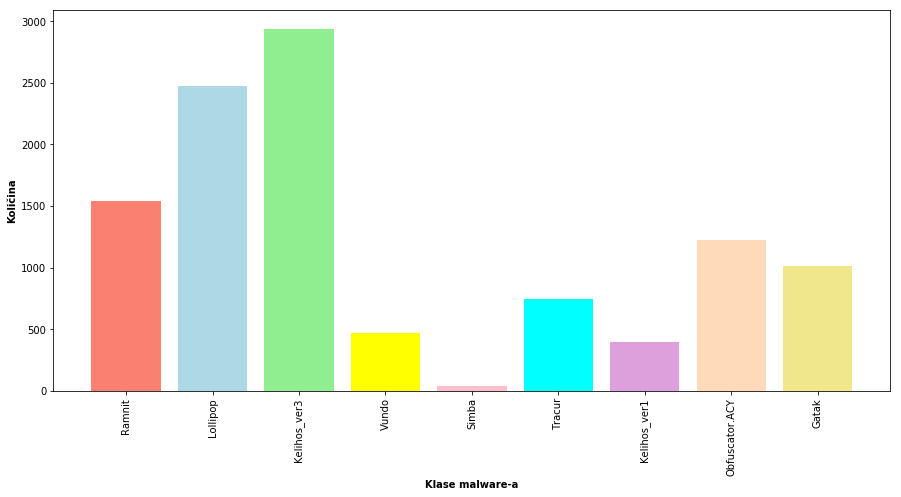

In [8]:
# raspodjela podataka u klase malware-a
features_class_quantity = { }

for i in range(1,10):
    features_class_quantity[i] = classes_begining_and_end_in_features[i][1] - classes_begining_and_end_in_features[i][0]  

classes = list(malware_dict.values())
quantity = list(features_class_quantity.values())
print(features_class_quantity.values())

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(classes, quantity, color = ['Salmon', 'lightblue', 'lightgreen', 'yellow', 'pink', 'cyan', 'plum', 'peachpuff', 'khaki'])
plt.xticks(rotation='vertical')
plt.xlabel('Klase malware-a', fontweight='bold')
plt.ylabel('Količina', fontweight='bold')

plt.show()

Primjećujemo neravnomjernu raspodjelu broja *malware*-a po klasama. Očekujemo veću točnost pri detektiranju klase *malware*-a koji pripada npr. *Kelihos_ver1* nego nekoj klasi s manjim brojem podataka. Unatoč tome, mislimo da zbog sveukupno velikog broja podataka za treniranje to neće stvarati neke probleme.

<br>

Budući da baratamo s velikim brojem značajki, želimo odabrati najbitnije među njima. Podsjetimo kako smo značajke podijelili u [13 kategorija](#Kategorije-značajki). 
Pretpostavljamo da će značajke unutar iste kategorije imati slična svojstva. Zato prvo zasebno analiziramo svaku od navedenih kategorija podataka.   

## Značajke dobivene iz _.bytes_ datoteka

### unigram 
_1G_

Sljedeća tablica prikazuje vrijednosti značajki unigram kategorije za svaki od *malware*-a.

In [9]:
# ONE GRAM značajke
# one_gram = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/byte_oneg.csv")
one_gram_features = features.iloc[:,2:258]
one_gram_features.head()

byte_1G_00  byte_1G_01  byte_1G_02  byte_1G_03  byte_1G_04  byte_1G_05  \
0       21091        1213         726         817        1257         625   
1       40030        1980        1226        1193        1971        1096   
2       19419         955         693         656         832         463   
3       79568        6445        3143        2517        4982        1824   
4       25791        1202         569         750         948         456   

   byte_1G_06  byte_1G_07  byte_1G_08  byte_1G_09  ...  byte_1G_f6  \
0         550         523        1078         473  ...         446   
1         961         755        2406         550  ...         585   
2         370         510         836         449  ...         348   
3        2125        2964        8301        1530  ...        2626   
4         405         517         754         494  ...         385   

   byte_1G_f7  byte_1G_f8  byte_1G_f9  byte_1G_fa  byte_1G_fb  byte_1G_fc  \
0         478         873         485         462         516        1133   
1         377         806         479         357         394        1114   
2         434         463         354         472         393         384   
3        3753        4012        1511        1604        2407        5196   
4         402         500         316         297         343         452   

   byte_1G_fd  byte_1G_fe  byte_1G_ff  
0         471         761        7998  
1         507        1080       10826  
2         303         390        2104  
3        4614        4448       47484  
4         283         401        4532  

[5 rows x 256 columns]

Za prvi dojam kakvoće podataka promatramo korelaciju s ciljnom značajkom. Radi lakše analize vrijednosti smo sortirali.

In [10]:
one_gram_features.corrwith(features['Class']).dropna().sort_values() 

byte_1G_89   -0.404886
byte_1G_f0   -0.397366
byte_1G_fc   -0.364538
byte_1G_e9   -0.361362
byte_1G_c3   -0.361340
byte_1G_c7   -0.345989
byte_1G_eb   -0.345509
byte_1G_c6   -0.345476
byte_1G_c1   -0.344923
byte_1G_7d   -0.337797
byte_1G_88   -0.330831
byte_1G_c4   -0.322382
byte_1G_83   -0.299938
byte_1G_f8   -0.298035
byte_1G_84   -0.291637
byte_1G_b6   -0.282373
byte_1G_8b   -0.281135
byte_1G_ec   -0.268163
byte_1G_ff   -0.259695
byte_1G_8d   -0.249475
byte_1G_c0   -0.225129
byte_1G_33   -0.215678
byte_1G_85   -0.209777
byte_1G_fe   -0.206600
byte_1G_20   -0.202264
byte_1G_01   -0.198866
byte_1G_e8   -0.186352
byte_1G_80   -0.169739
byte_1G_cc   -0.161395
byte_1G_11   -0.145438
                ...   
byte_1G_58   -0.043412
byte_1G_6c   -0.043064
byte_1G_34   -0.042992
byte_1G_70   -0.042344
byte_1G_51   -0.042243
byte_1G_29   -0.042034
byte_1G_2f   -0.041598
byte_1G_79   -0.040917
byte_1G_47   -0.040582
byte_1G_3e   -0.040547
byte_1G_42   -0.040546
byte_1G_4a   -0.039946
byte_1G_36 

U ovoj kategoriji korelacijska vrijednost ima veliku amplitudu zbog čega pretpostavljamo da će nam neke značajke ovog tipa biti bitne u konačnoj selekciji značajki za treniranje.

Postoji 256 unigram značajki. Sada, nastavljamo analizu nad 31 najboljih po univarijantnoj metodi odabira značajki. Do tog broja smo došli promatrajući donji graf i uspoređujući kako točnost varira u odnosu na broj odabranih značajki. Jednakom logikom se vodimo i pri analizi sljedećih kategorija s velikim brojem značajki. Finalnu selekciju ćemo naknadno odrediti iz ovako izabranih najboljih značajki svake kategorije.  

U ``univariate_plot`` funkciji se prije samog odabira značajki brišu sve konstantne značajke iz proslijeđene kategorije.

- izbačeno  0  konstantnih značajki


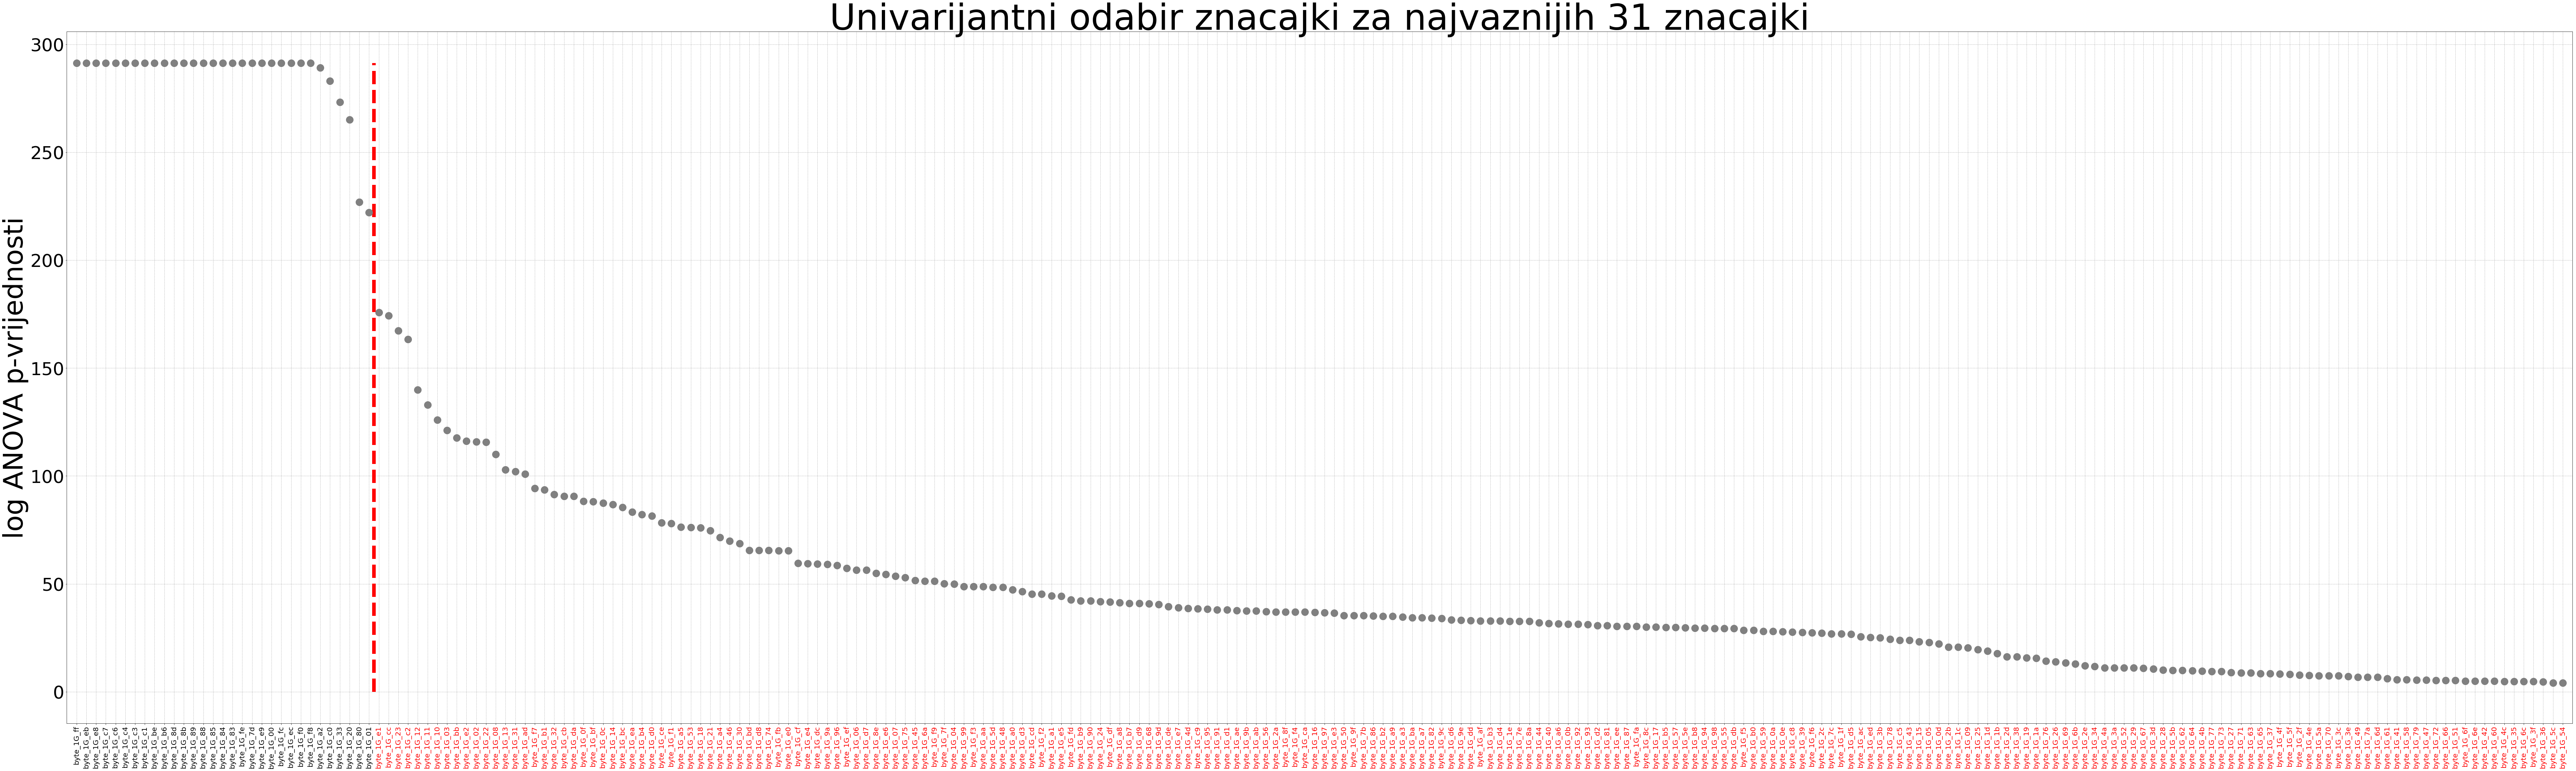

In [11]:
one_gram_features_univariate = univariate_plot( features['Class'], one_gram_features, 31)

Kao rezultat smo dobili dolje ispisane značajke. Sve od navedenih imaju visoku p-vrijednost po ANOVA testu.

In [12]:
one_gram_features_univariate

array(['byte_1G_ff', 'byte_1G_eb', 'byte_1G_e8', 'byte_1G_c7',
       'byte_1G_c6', 'byte_1G_c4', 'byte_1G_c3', 'byte_1G_c1',
       'byte_1G_be', 'byte_1G_b6', 'byte_1G_8d', 'byte_1G_8b',
       'byte_1G_89', 'byte_1G_88', 'byte_1G_85', 'byte_1G_84',
       'byte_1G_83', 'byte_1G_fe', 'byte_1G_7d', 'byte_1G_e9',
       'byte_1G_00', 'byte_1G_fc', 'byte_1G_ec', 'byte_1G_f0',
       'byte_1G_f8', 'byte_1G_a2', 'byte_1G_c0', 'byte_1G_33',
       'byte_1G_20', 'byte_1G_80', 'byte_1G_01'], dtype=object)

Slijedi analiza koreliranosti gornjih značajki.

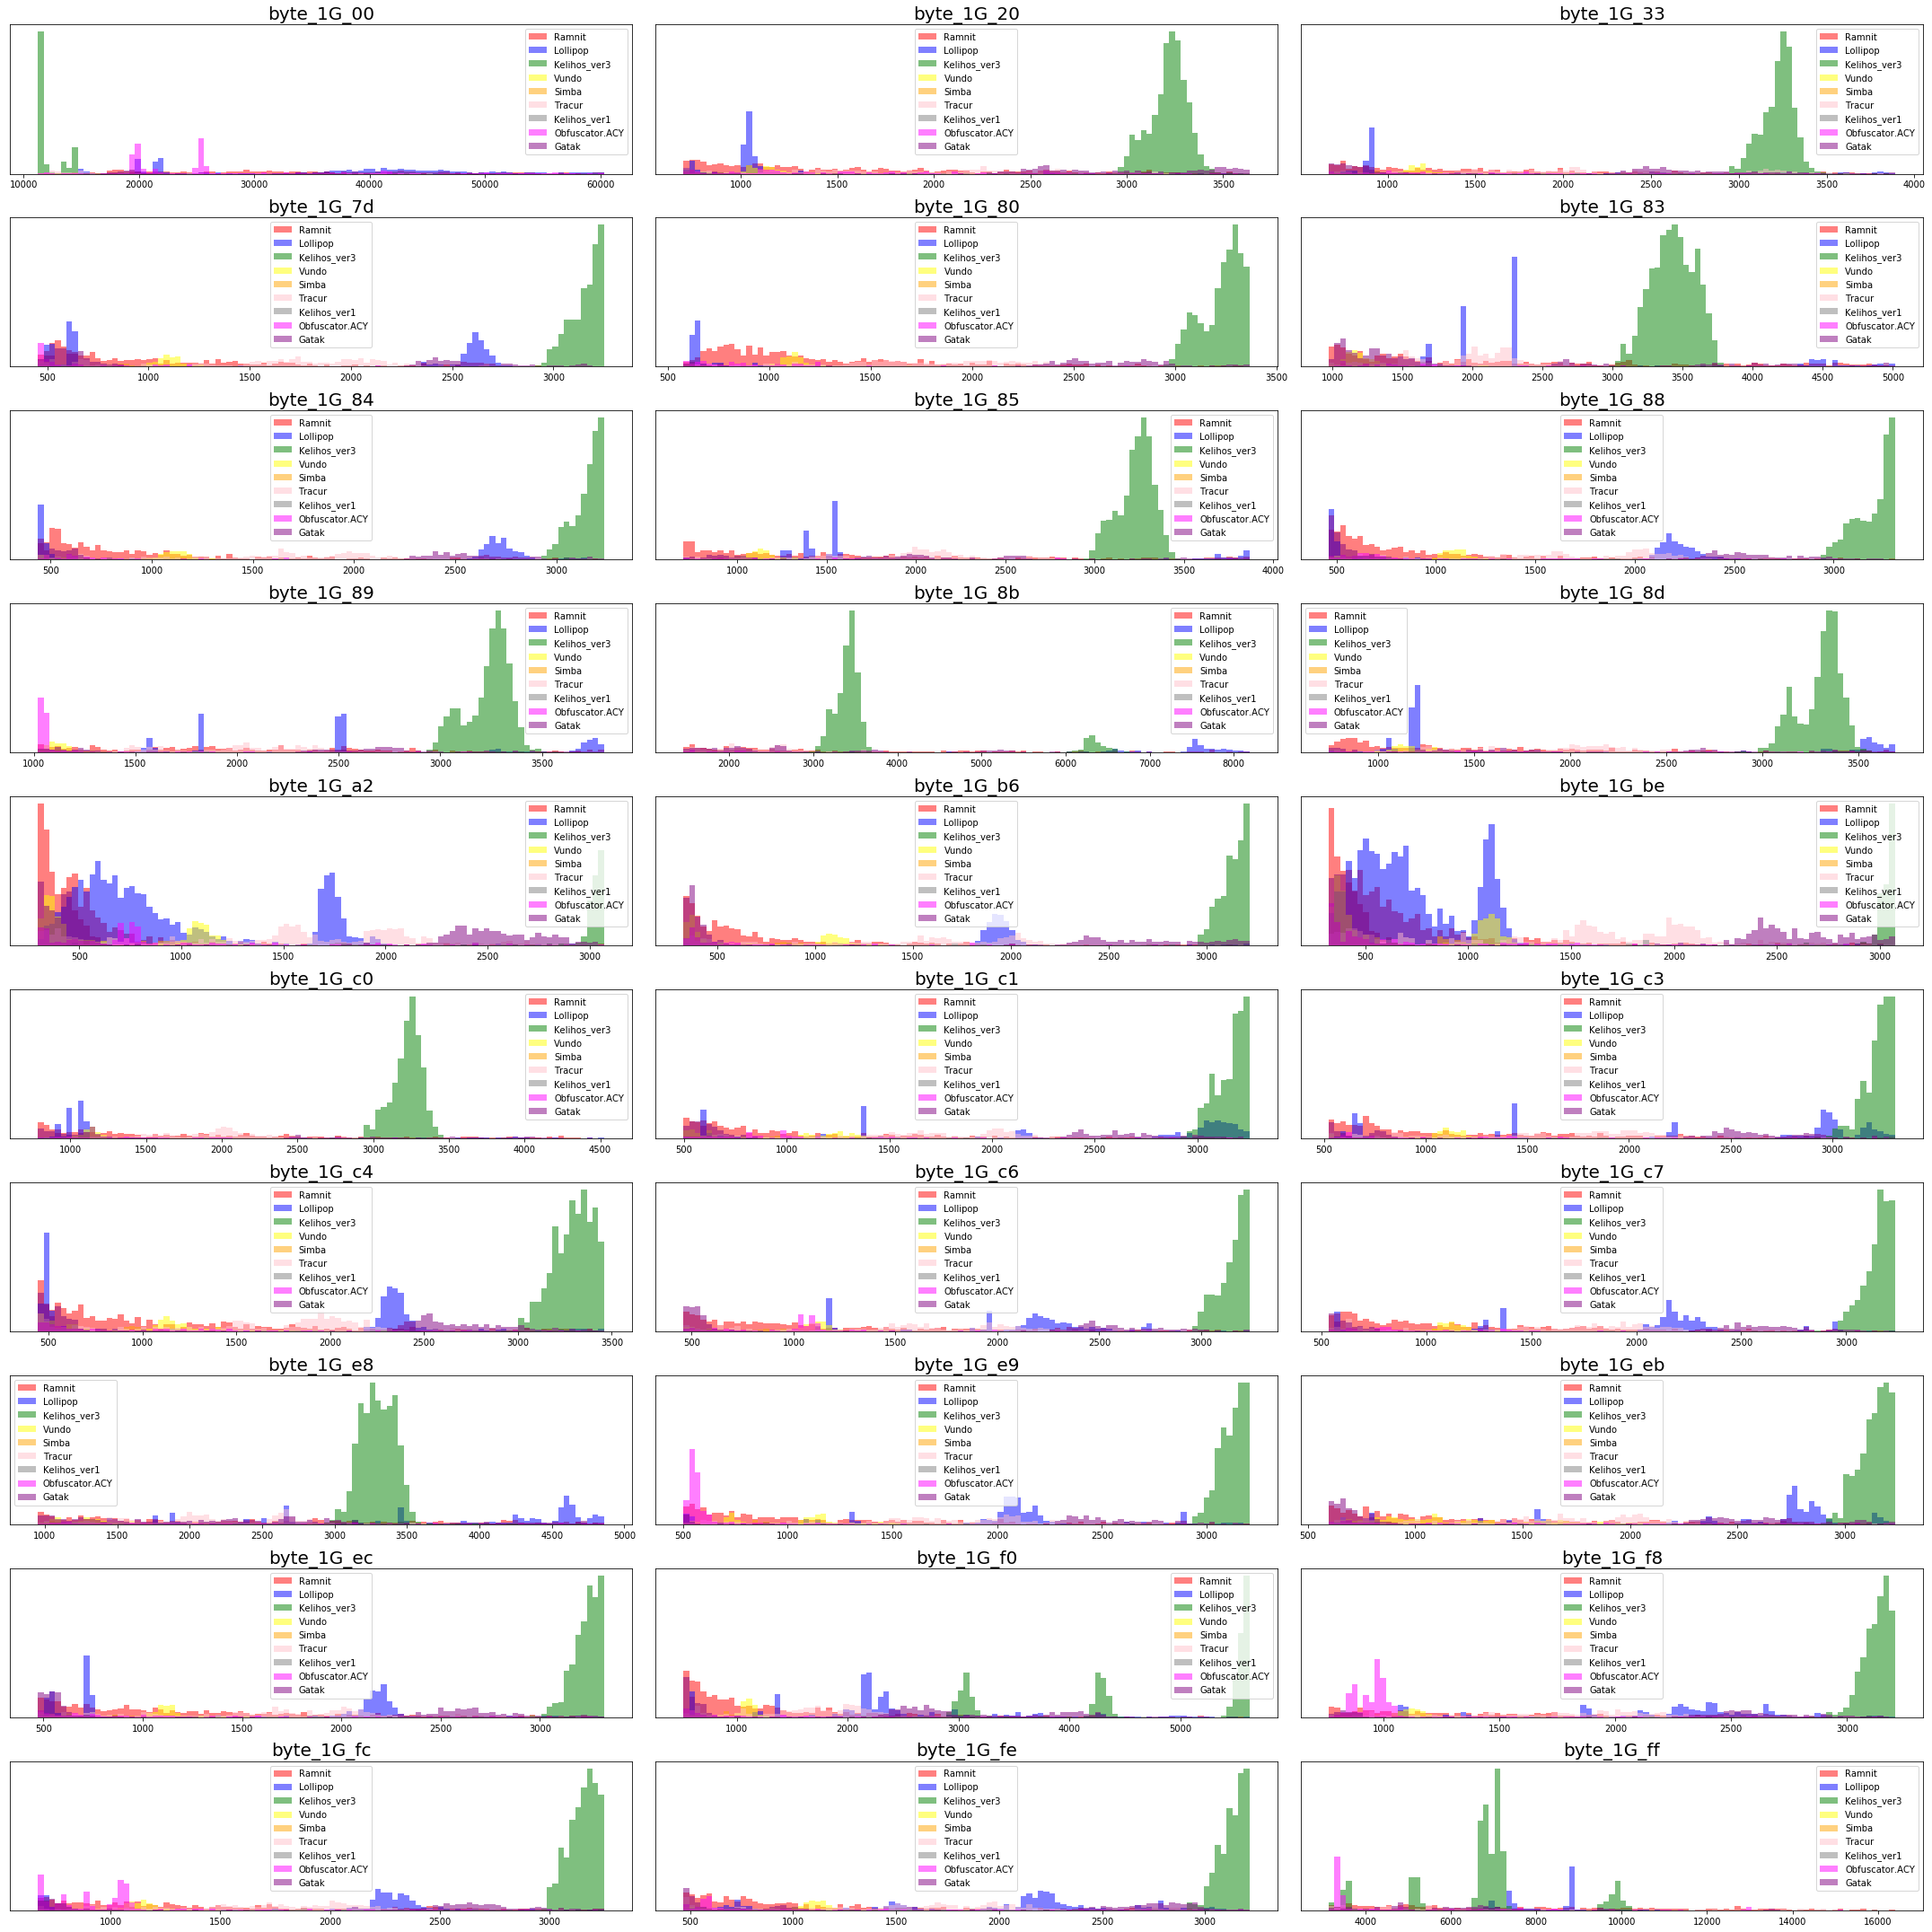

In [13]:
draw_histograms_rows_quantile(data = one_gram_features, 
                              classes = classes_begining_and_end_in_features,
                              features = get_best_features_in_category_index_list(one_gram_features, one_gram_features_univariate[:30]), 
                              sections = 100, 
                              no_rows = 10, no_cols = 3, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*30)

Na x osi priloženih histograma nalazi se broj pojavljivanja određenog <code>byte</code>-a dok visina stupca označava količinu malware-a iz određene skupine koji sadrže pripadni broj pojavljivanja tog <code>byte</code>-a. Različite boje su pridružene različitim kategorijama malware-a. Promotrimo primjerice histogram <code>byte_1G_20</code>. Iz njega vidimo da malware-i iz skupine <i>Kelihos_ver3</i> (zeleni) uglavnom sadrže između 3000 i 3500 pojavljivanja tog bajta, skupina <i>Lollipop</i> (plav) uglavnom oko 1000 dok se kod primjerice skupine <i>Gatak</i> (ljubičasti) ne primjećuje nikakva pravilnost.


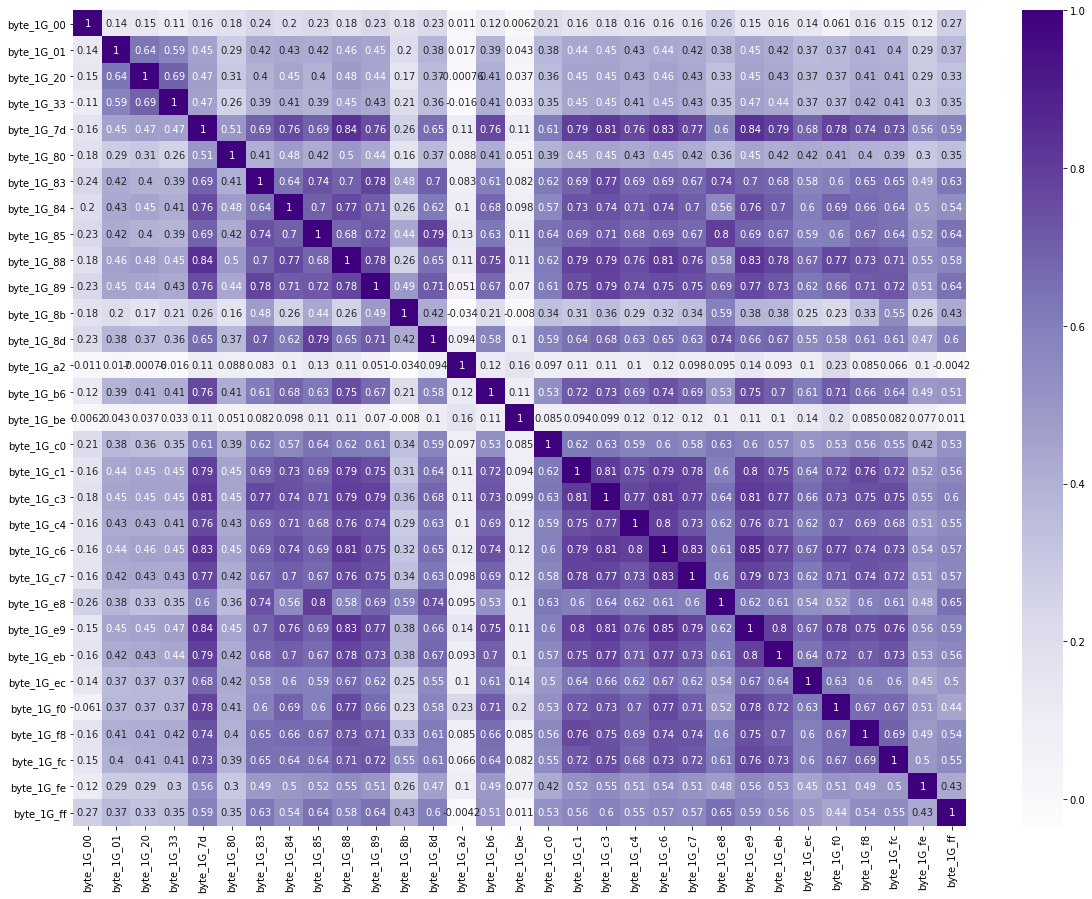

In [14]:
draw_heatmap(one_gram_features, one_gram_features_univariate)

Na karti postoji popriličan broj tamnije označenih polja što potvrđuje pretpostavljenu korelaciju. Možemo uočiti čitave skupine koreliranih značajki iz čega zaključujemo da ćemo ovu skupinu, uz dobar odabir značajki koje ćemo zadržati, moći još dosta smanjiti, a da dobijemo približno jednaku točnost. Projekciju podataka u novi prostor značajki obavit ćemo naknadno.


Pogledajmo sada kako podaci variraju u svakoj klasi <i>malware</i>-a za značajku <code>byte_1G_88</code> korišteći <i>boxplot</i>.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  89.28571428571429 %
Lollipop  -  99.47495961227787 %
Kelihos_ver3  -  86.94321659299558 %
Vundo  -  100.0 %
Simba  -  92.6829268292683 %
Tracur  -  99.86666666666667 %
Kelihos_ver1  -  81.86397984886649 %
Obfuscator.ACY  -  84.10757946210269 %
Gatak  -  99.60474308300395 %


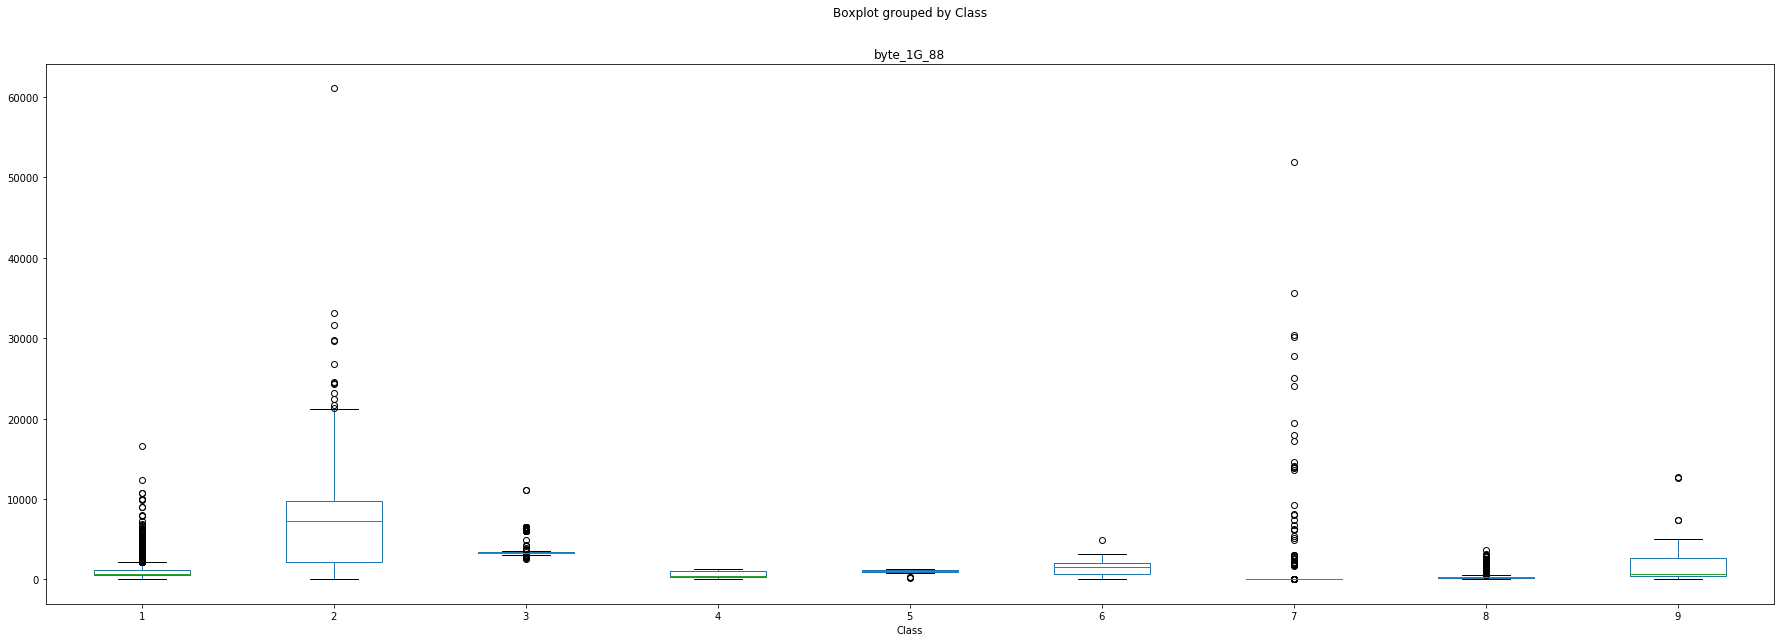

In [15]:
col = one_gram_features.columns.get_loc('byte_1G_88')

features.boxplot(column=[one_gram_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( one_gram_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>byte_1G_88</code> vidimo da imamo <i>outlier</i>-a. No, s obzirom da baratamo s velikim skupom podataka, očekivano je da će ih biti. 
Na primjer, za familiju <i>Tracur</i> gotovo da ni nema <i>outlier</i>-a, no za familiju <i>Obfuscator</i> imamo 195 <i>outlier</i>-a od ukupno 1227 podataka, dakle 84.10% podataka nalazi se između gornjeg i donjeg brka.

Radi usporedbe, provodimo logističku regresiju sa značajkama izabranim univarijatnom metodom te sa svim metadata značajkama. Pri tome 40% trening podataka koristimo za testiranje modela.

In [16]:
df_one_gram_features_univariate = one_gram_features[one_gram_features_univariate.tolist()]

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( df_one_gram_features_univariate.dropna(), features['Class'], test_size=0.4, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=12000))]) 
model.fit(malware_train, malware_classes_train)
one_gram_accuracy_test_univariate = model.score(malware_test,malware_classes_test)
print(one_gram_accuracy_test_univariate)

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( one_gram_features.dropna(), features['Class'], test_size=0.4, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=12000))]) 
model.fit(malware_train, malware_classes_train)
one_gram_accuracy_test = model.score(malware_test,malware_classes_test)
print(one_gram_accuracy_test)

Vidimo da je dobiven poprilično dobar rezultat. Dakle, naš odabir univarijantne metode se pokazao dobrim budući da smo uspjeli smanjiti skup značajki sa 256 na 31 uz minimalno gubljenje na točnosti od 3%. Metodu ćemo primijeniti i na ostalim klasama značajki koje sadrže velik broj *feature*-a.

### (byte) metadata 
_MDB_

In [17]:
# METADATA značajke iz bytes datoteka
metadata_bytes_features = features.iloc[:,258:260]
metadata_bytes_features.head()

byte_filesize  byte_offset
0         244445    268439552
1         268254   1307774976
2         169207    268439552
3         771461   2112880640
4         167821    268439552

Tablica prikazuje vrijednosti metadata značajki za prvih 5 *malware*-a. Metadata značajki u *.bytes* datotekama ima samo dvije. Zato nema potrebe za selekcijom.

Promortimo korelaciju s ciljnom značajkom.

In [18]:
metadata_bytes_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

byte_filesize   -0.316945
byte_offset     -0.302309
dtype: float64

Korelacija obje značajke iz ove kategorije nije beznačajna.

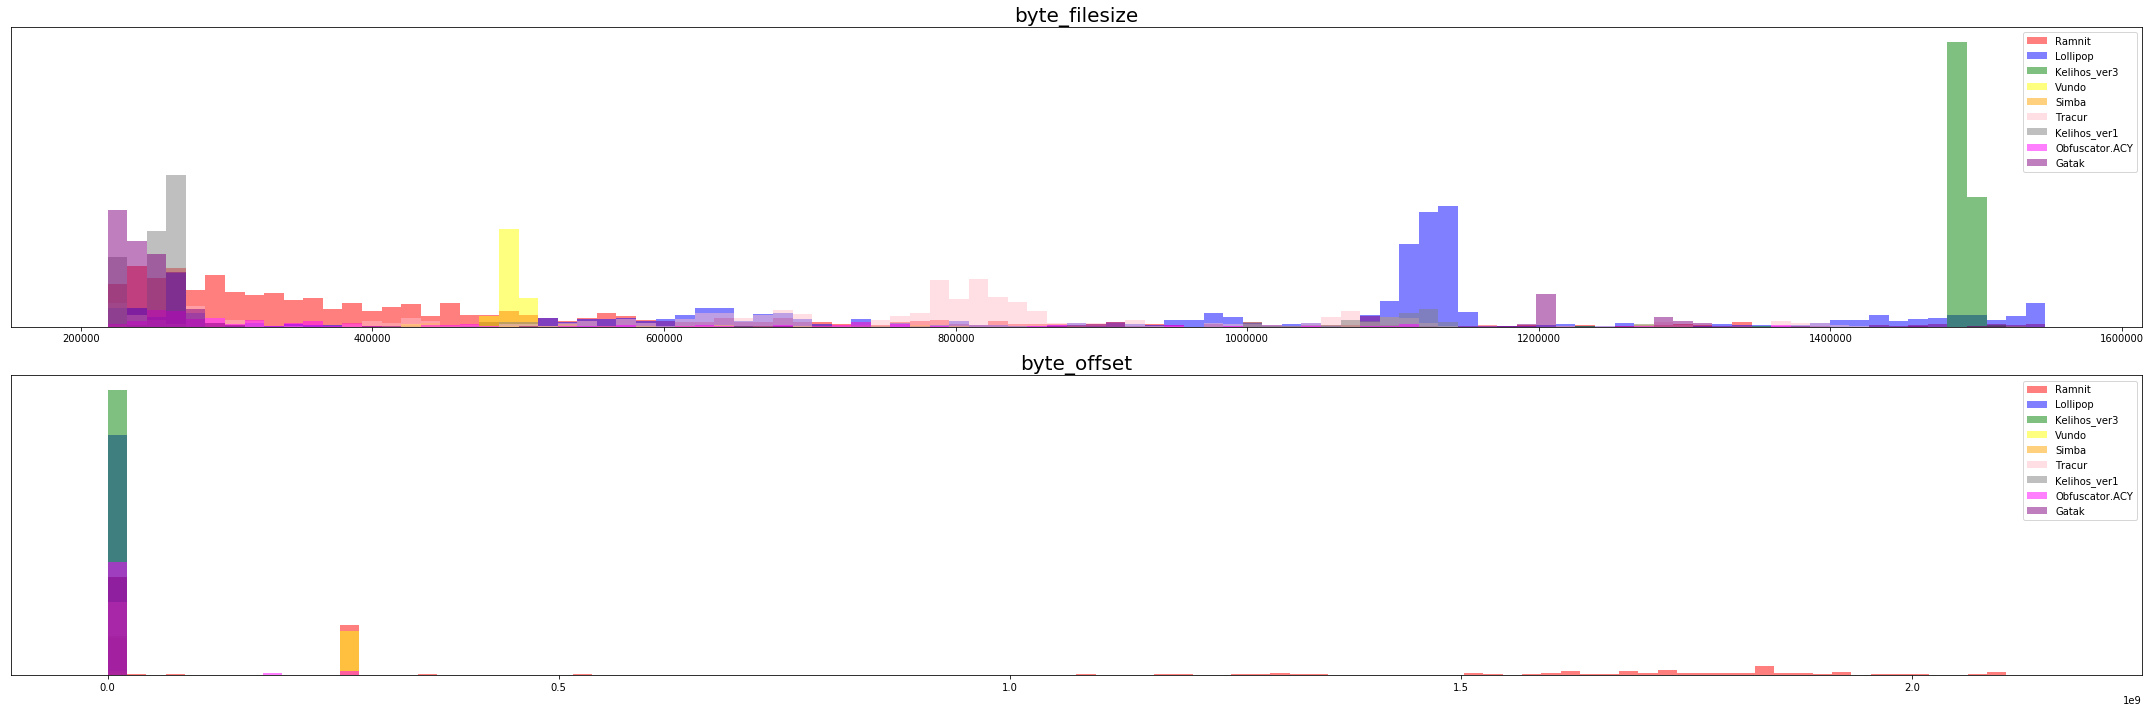

In [19]:
draw_histograms_rows_quantile( data = metadata_bytes_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1], 
                              sections = 100, 
                              no_rows = 2, no_cols = 1, 
                              fig_x = 30, fig_y = 10,
                              i_want_whole_range = [False, True])

Iz prvog histograma koji prikazuje veličinu .bytes datoteka vidimo da je veličina datoteke skupine Kelinos_ver3 (zelena) uglavnom veća od ostalih skupina te vidimo da neke skupine imaju značajno manju veličinu datoteke. Također, zbog velike razlike u izgledu histograma, da se naslutiti da ove dvije značajke nisu korelirane.

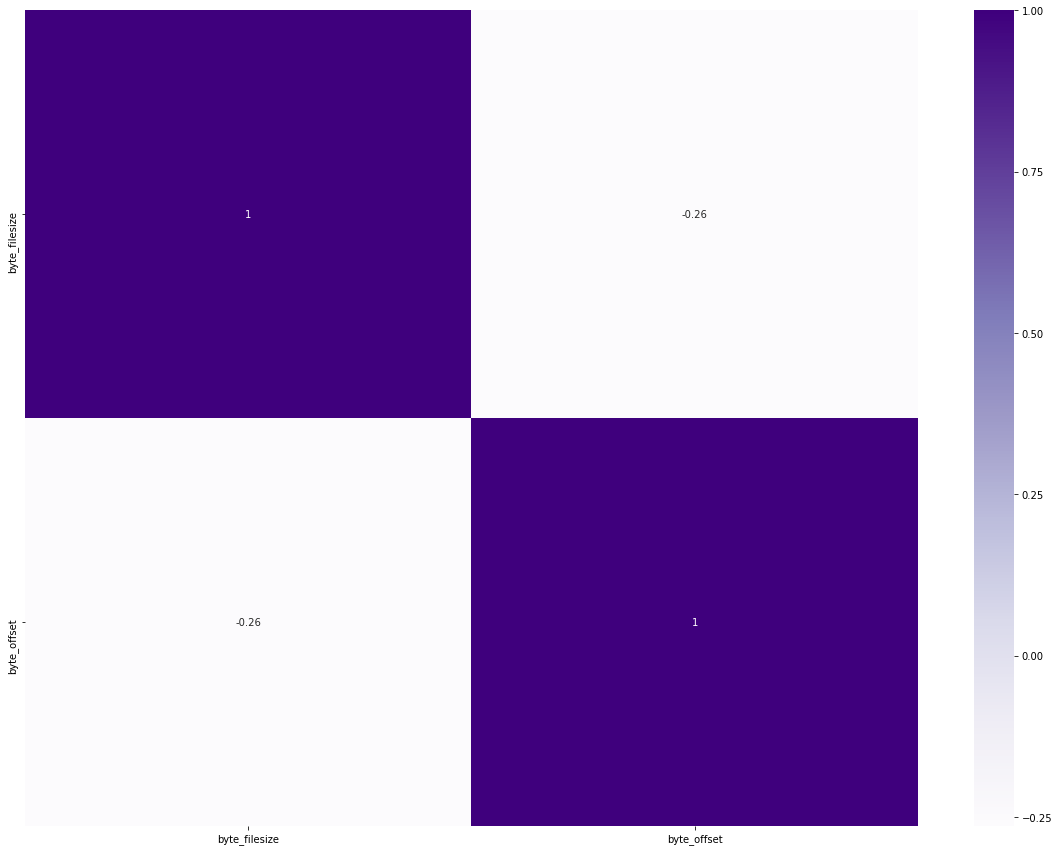

In [20]:
draw_heatmap(metadata_bytes_features, metadata_bytes_features.columns)

Prikazani histogrami vrlo jasno dočaravaju kako su značajke *byte_filesize* i *byte_offset* međusobno slabo korelirane. To potvrđuje i toplinska karta. Zato, ukoliko nam ova čitava skupina bude bitna za krajnju selekciju, ove značajke se međusobno neće isljučivati.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  90.64935064935065 %
Lollipop  -  100.0 %
Kelihos_ver3  -  67.39204352261136 %
Vundo  -  100.0 %
Simba  -  100.0 %
Tracur  -  100.0 %
Kelihos_ver1  -  63.72795969773299 %
Obfuscator.ACY  -  80.27709861450693 %
Gatak  -  100.0 %


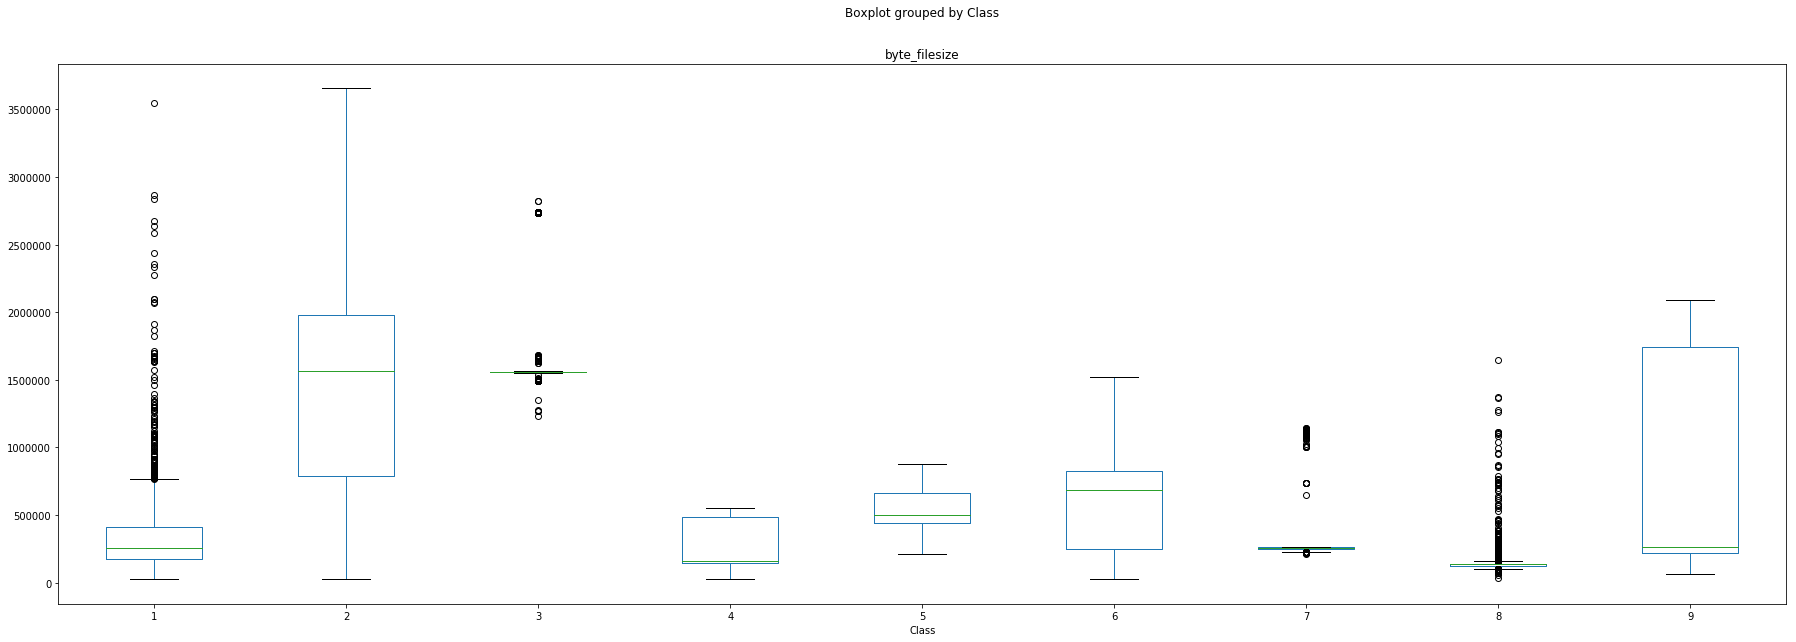

In [21]:
col = metadata_bytes_features.columns.get_loc('byte_filesize')

features.boxplot(column=[metadata_bytes_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( metadata_bytes_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>byte_filesize</code> vidimo da imamo <i>outlier</i>-a. No, s obzirom da baratamo s velikim skupom podataka, očekivano je da će ih biti. 
Na primjer, za familiju <i>Lollipop</i> nema <i>outlier</i>-a, no za familiju <i>Kelihos_ver1</i>(<i>boxplot</i>  broj 7) 63.72% podataka nalazi se između gornjeg i donjeg brka, odnosno imamo 114 <i>outlier</i>-a od ukupno 397 podataka. Iz slike vidimo da se većina tih <i>outlier</i>-a grupirana (za familiju <i>Kelihos_ver1</i>) , tako da bismo mogli reći da imamo dvije podklase te familije koje u prosjeku imaju različite veličine .bytes datoteka.

Radi usporedbe, provodimo logističku regresiju na svim metadata značajkama. Pri tome 40% trening podataka koristimo za testiranje modela.

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( metadata_bytes_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
metadata_bytes_accuracy_test = model.score(malware_test,malware_classes_test) 
print(metadata_bytes_accuracy_test)

### entropija
_ENT_

Prikazan je kratak uvid u tablicu svih entropijskih značaki *malvare*-a. 

In [22]:
# ENTROPY značajke 
entropy_features = features.iloc[:,260:462]
entropy_features.head()

ent_q_diffs_0  ent_q_diffs_1  ent_q_diffs_2  ent_q_diffs_3  ent_q_diffs_4  \
0       0.000000       0.000000       0.007566       0.002348       0.001304   
1       0.000000       0.000000       0.000000       0.000000       0.001661   
2       0.000000       0.000000       0.000000       0.000000       0.000000   
3       0.042895       0.003679       0.002993       0.004925       0.001247   
4       0.105760       0.002203       0.002518       0.003462       0.004721   

   ent_q_diffs_5  ent_q_diffs_6  ent_q_diffs_7  ent_q_diffs_8  ent_q_diffs_9  \
0       0.015914       0.003913       0.006261       0.004957       0.003652   
1       0.003738       0.002492       0.005399       0.012874       0.008306   
2       0.000000       0.000000       0.011930       0.008772       0.007368   
3       0.001559       0.001309       0.001683       0.002120       0.003429   
4       0.011331       0.001889       0.025181       0.027070       0.038401   

   ...  ent_p_diffs_10  ent_p_diffs_11  ent_p_diffs_12  ent_p_diffs_13  \
0  ...        0.023297        0.026589        0.032918        0.205912   
1  ...        0.012580        0.013367        0.014517        0.017450   
2  ...        0.017624        0.267654        0.037895        0.007731   
3  ...        0.011928        0.010840        0.011953        0.011937   
4  ...        0.014489        0.013735        0.075768        0.224453   

   ent_p_diffs_14  ent_p_diffs_15  ent_p_diffs_16  ent_p_diffs_17  \
0        0.000591        0.000359        0.000232        0.000230   
1        0.028586        0.205772        0.020981        0.002177   
2        0.002728        0.001414        0.001426        0.001377   
3        0.012959        0.015994        0.032501        0.183997   
4        0.000551        0.000227        0.000307        0.000312   

   ent_p_diffs_18  ent_p_diffs_19  
0        0.000256        0.000259  
1        0.002937        0.002568  
2        0.001329        0.003496  
3        0.028849        0.003329  
4        0.000231        0.000145  

[5 rows x 202 columns]

In [23]:
entropy_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

ent_q_diff_diffs_1_max-min   -0.264369
ent_p_15                     -0.260687
ent_q_diff_block_1_17        -0.257526
ent_q_diff_diffs_median      -0.250159
ent_p_16                     -0.242348
ent_q_diffs_16               -0.233748
ent_q_diff_block_2_17        -0.228930
ent_p_14                     -0.225248
ent_p_17                     -0.224587
ent_q_diff_block_0_16        -0.219858
ent_q_diffs_17               -0.219134
ent_q_diff_block_1_16        -0.216804
ent_p_18                     -0.215914
ent_p_19                     -0.215864
ent_q_diff_diffs_1_var       -0.212518
ent_q_diff_block_2_16        -0.209177
ent_q_diff_diffs_mean        -0.194626
ent_q_diffs_max              -0.184288
ent_q_diff_diffs_3_min       -0.172027
ent_q_diffs_var              -0.171526
ent_q_diff_block_3_16        -0.171063
ent_p_diffs_13               -0.169993
ent_p_diffs_5                -0.162044
ent_q_diff_diffs_3_max       -0.161200
ent_q_diff_block_3_17        -0.143982
ent_q_diff_diffs_12      

Iz navedenih korelacijskih vrijednosti primjećujemo kako ova skupina *featurea* ima dosta dobre rezultate. Uz to općenito znamo da je vrijednost entropije u datotekama koje reprezentiraju *malware* vrlo visoka u odnosnu na normalne datoteke. Sve to daje naslutiti da će nam ova skupina biti vrlo važna. Zato ćemo u ovom slučaju univarijantnom metodom odabrati veći broj značajki. Iako ćemo zbog toga i dalje imati popriličan broj značajki smatramo da ih je, zbog već naglašene važnosti kategorije, bolje za sad zadržati.

- izbačeno  94  konstantnih značajki


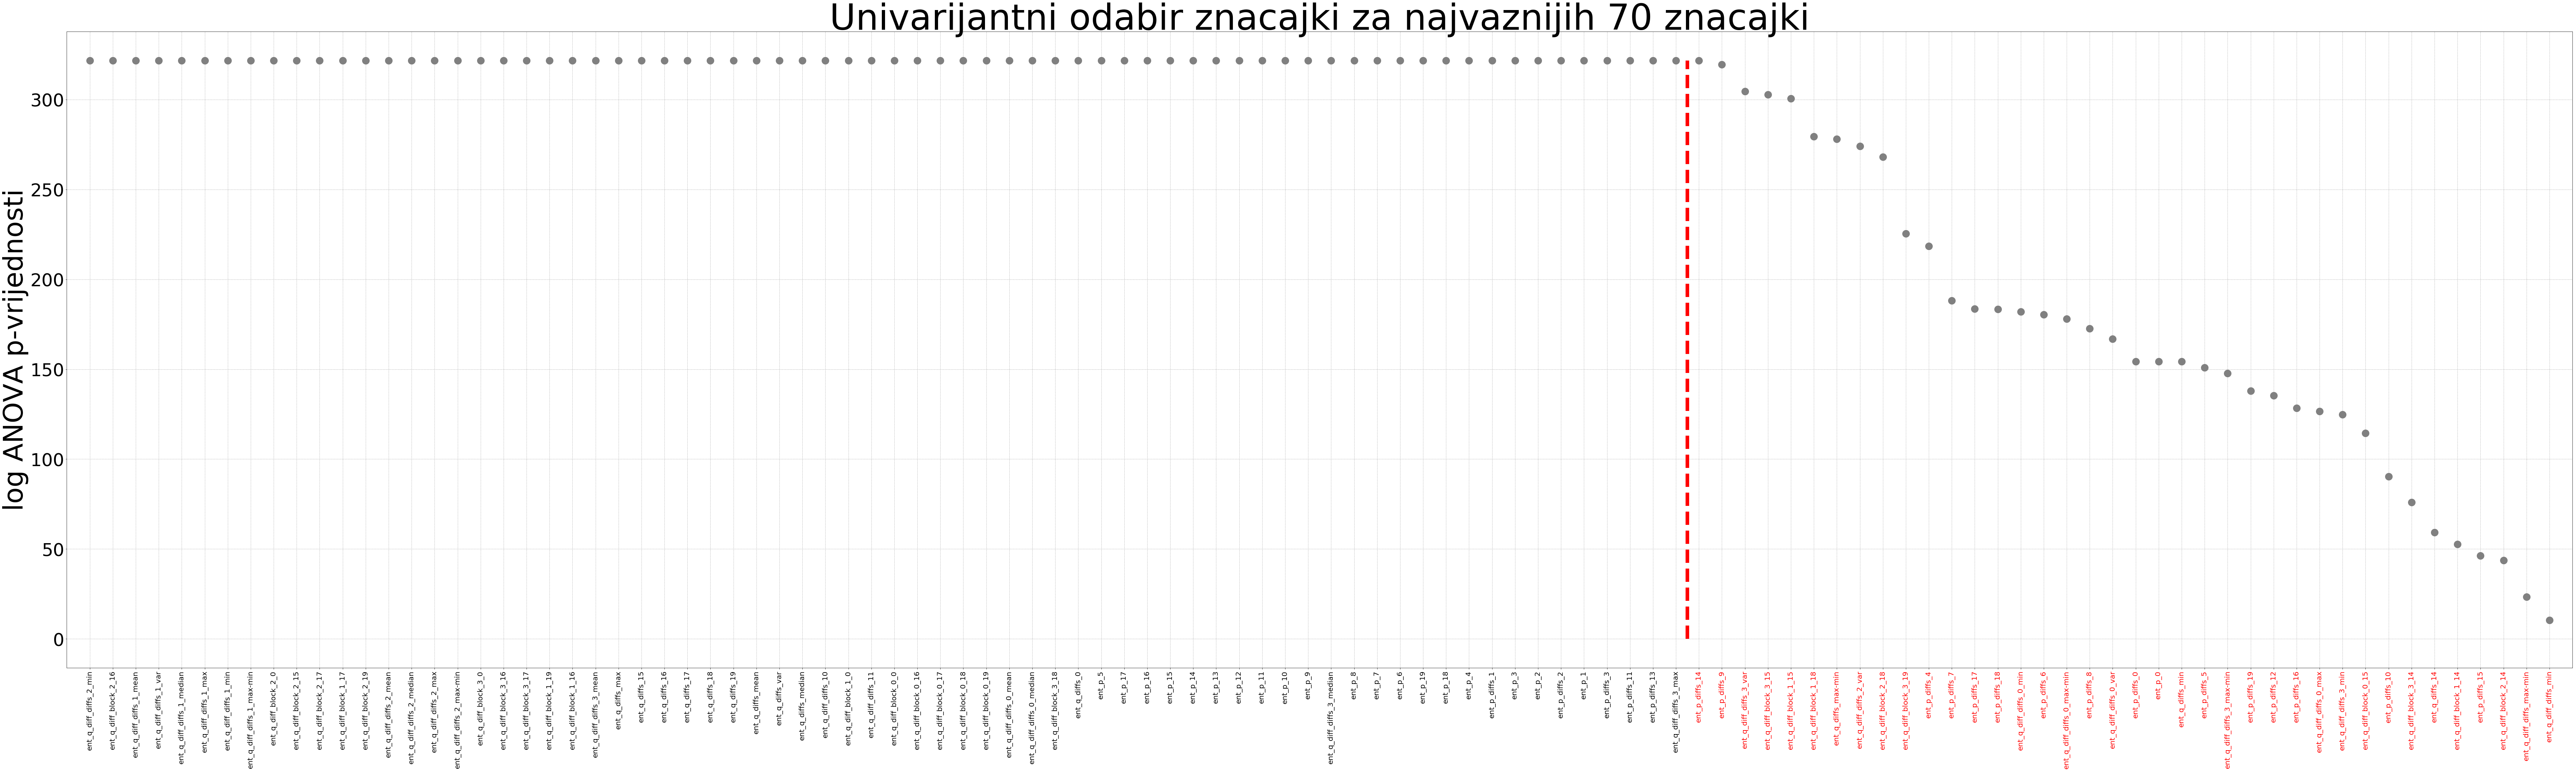

In [24]:
entropy_features_univariate = univariate_plot( features['Class'], entropy_features, 70 ) 

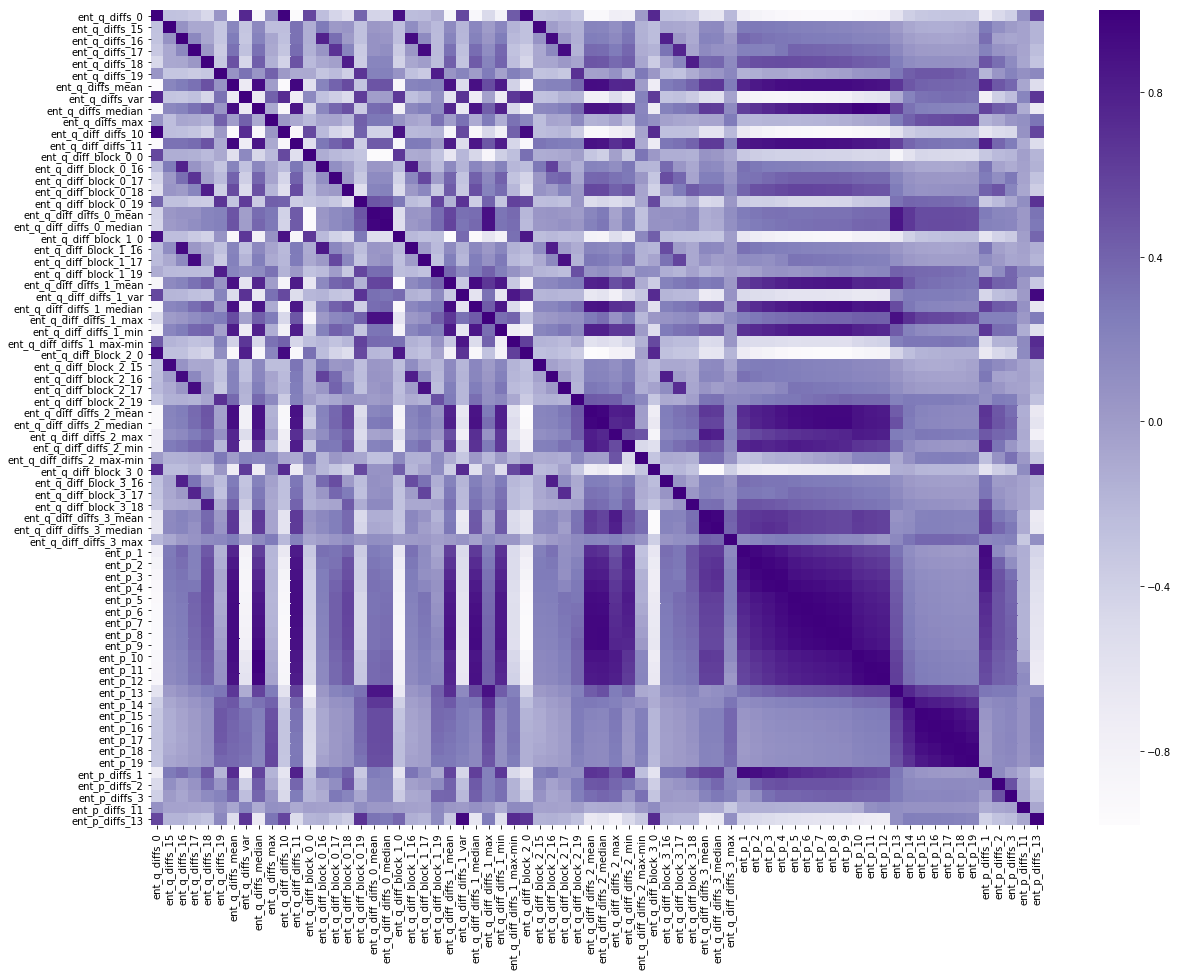

In [25]:
draw_heatmap_anNot(entropy_features, entropy_features_univariate)

Iz gornjih prikaza korelacije *feature*-a vidimo kako ćemo skup značajki moći još poprilično smanjiti. Primjećujemo nekoliko većih koreliranih skupina i još velik broj koreliranih parova.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  85.45454545454545 %
Lollipop  -  81.74474959612277 %
Kelihos_ver3  -  67.42604556273376 %
Vundo  -  100.0 %
Simba  -  100.0 %
Tracur  -  79.60000000000001 %
Kelihos_ver1  -  76.32241813602015 %
Obfuscator.ACY  -  100.0 %
Gatak  -  75.69169960474308 %


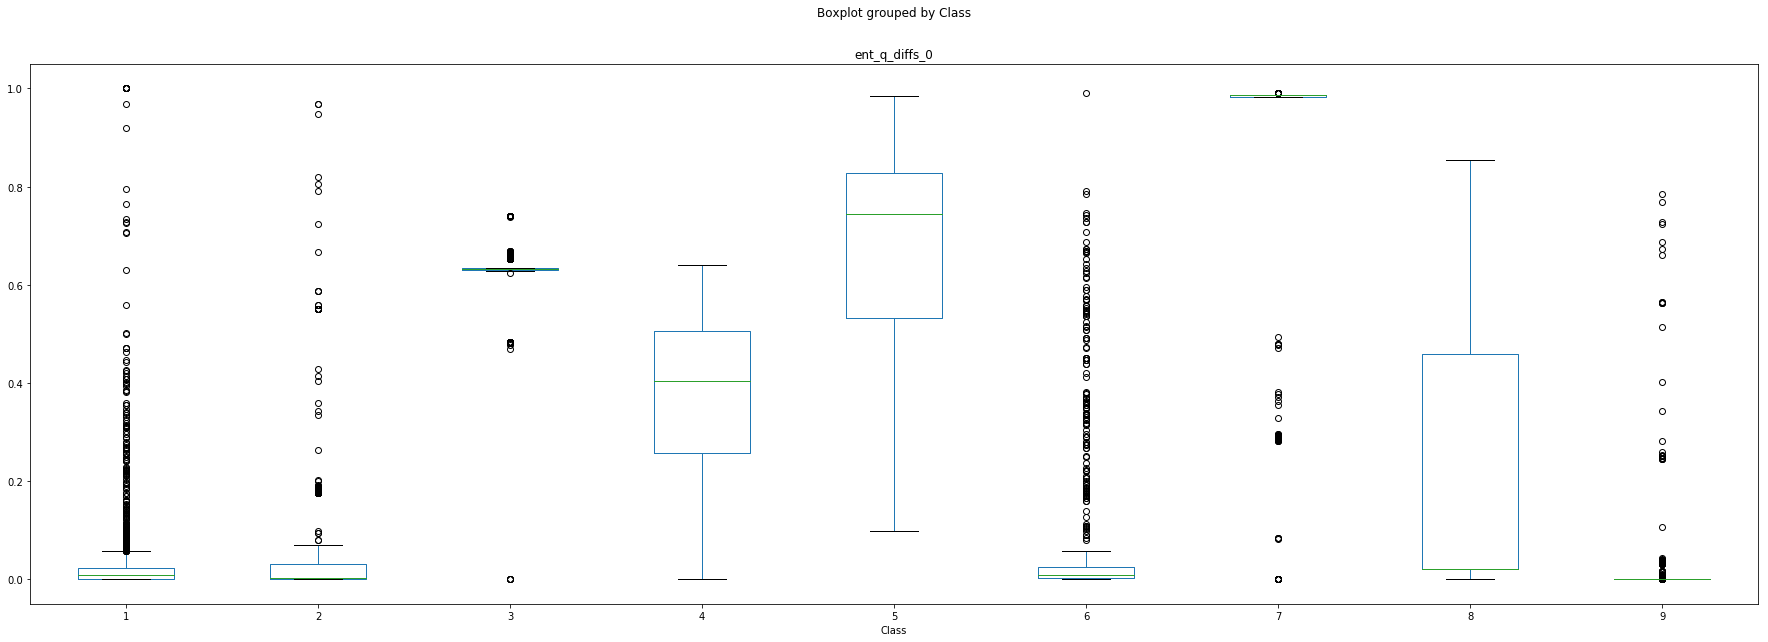

In [26]:
col = entropy_features.columns.get_loc('ent_q_diffs_0')

features.boxplot(column=[entropy_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( entropy_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>ent_q_diff_1_mean</code>  vidimo da imamo <i>outlier</i>-a u 6 od 9 familija. No, s obzirom da baratamo s velikim skupom podataka, očekivano je da će ih biti. 
Na primjer, za familiju <i>Vundo</i> i <i>Simba</i> svi su podaci unutar gornjeg i donjeg brka, no familija  <i>malware</i>-a <i>Kelihos_ver1</i>(<i>boxplot</i> broj 7) 32.58% podataka <i>outlier</i>-i. Iz slike se vidi da je zapravo jako mali raspon donjeg i gornjeg brka, te su se zbog toga, kao i u prethodno opisanom <i>boxplot</i>-u <code>bytes_filesize</code>, podaci grupirali u dvije podklase. Također uočavamo da familija <i>malware</i>-a <i>Ramnit</i> ima puno više <i>outlier</i> nego <i>Kelihos_ver1</i>, točnije, ima ih 95 više, no u odnosu na ukupan broj podataka u klasi <i>Ramnit</i>, to je prosječno mnogo manje.

Radi usporedbe, provodimo logističku regresiju sa značajkama izabranim univarijatnom metodom te sa svim entropijskim značajkama. 

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( entropy_features, features['Class'], test_size=0.4, random_state=0)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
entropy_accuracy_test = model.score(malware_test,malware_classes_test)
print(entropy_accuracy_test)

In [ ]:
df_entropy_features_univariate = entropy_features[entropy_features_univariate.tolist()]


In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( df_entropy_features_univariate.dropna(), features['Class'], test_size=0.4, random_state=0)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
entropy_accuracy_test_univariate = model.score(malware_test,malware_classes_test)
print(entropy_accuracy_test_univariate)

Uz to što je koreliranost čitave skupine s ciljnom varijablom velika, točnost s ovako selektiranim značajkama nam je ostala vrlo visoka. Zbog toga pretpostavljamo da će nam entropijske značajke biti od velike važnosti i u konačnoj selekciji značajki.

### slikovna reprezentacija _malwarea_
_IMG_

In [27]:
# IMAGE značajke 
image_features = features.iloc[:,462:514]
image_features.head()

byte_Img1_0   byte_Img1_1  byte_Img1_2  byte_Img1_3  byte_Img1_4  \
0     0.015560  10424.169276     0.281469  7253.810043     0.156883   
1     0.011125  10473.182086     0.271823  7191.372064     0.164023   
2     0.018087   9085.748498     0.337131  6853.347321     0.178820   
3     0.011778   9011.326305     0.365131  7096.999995     0.168553   
4     0.079121   8022.383513     0.453116  7334.630795     0.322679   

   byte_Img1_5   byte_Img1_6  byte_Img1_7  byte_Img1_8  byte_Img1_9  ...  \
0   212.615694  18591.070896     8.210199    13.388960     0.000084  ...   
1   211.027128  18292.306170     8.230688    12.850389     0.000091  ...   
2   200.000020  18327.640785     8.130132    13.127777     0.000109  ...   
3   211.663779  19376.673675     8.164637    12.428762     0.000091  ...   
4   168.166512  21316.139666     7.098649    11.328309     0.000376  ...   

   byte_Img1_42  byte_Img1_43  byte_Img1_44  byte_Img1_45  byte_Img1_46  \
0   7249.009377      0.124144    212.958541  17659.172940      8.326136   
1   7184.466418      0.086442    211.403879  15893.078448      8.487462   
2   6849.972073      0.127715    200.335102  16933.666122      8.316946   
3   7093.548415      0.106594    211.884756  16965.997099      8.429733   
4   7334.530615      0.264222    168.394193  19276.023700      7.346720   

   byte_Img1_47  byte_Img1_48  byte_Img1_49  byte_Img1_50  byte_Img1_51  
0     13.572401      0.000053      7.372721     -0.055253      0.733179  
1     13.539992      0.000026      7.537879     -0.041308      0.659622  
2     13.567806      0.000055      7.320932     -0.069984      0.791311  
3     13.363649      0.000039      7.417455     -0.046947      0.688479  
4     11.746061      0.000254      6.543933     -0.095994      0.833108  

[5 rows x 52 columns]

Budući da kategorija ima 52 značajke sve ćemo ih detaljnije promotriti.

In [28]:
image_features.corrwith(features['Class']).dropna().sort_values()

byte_Img1_51   -0.470732
byte_Img1_25   -0.469664
byte_Img1_12   -0.460057
byte_Img1_38   -0.299244
byte_Img1_32   -0.265812
byte_Img1_28   -0.201406
byte_Img1_19   -0.171105
byte_Img1_45   -0.170905
byte_Img1_42   -0.159141
byte_Img1_16   -0.159139
byte_Img1_29   -0.159130
byte_Img1_3    -0.158958
byte_Img1_6    -0.154834
byte_Img1_5    -0.103482
byte_Img1_31   -0.103427
byte_Img1_44   -0.103423
byte_Img1_18   -0.103422
byte_Img1_30   -0.065003
byte_Img1_1    -0.046981
byte_Img1_10   -0.035709
byte_Img1_40   -0.034016
byte_Img1_14   -0.033933
byte_Img1_33   -0.032933
byte_Img1_15   -0.031157
byte_Img1_41   -0.031091
byte_Img1_23   -0.029134
byte_Img1_49   -0.029102
byte_Img1_7    -0.026073
byte_Img1_20   -0.019850
byte_Img1_46   -0.019624
byte_Img1_35    0.021392
byte_Img1_21    0.028533
byte_Img1_47    0.028620
byte_Img1_2     0.029335
byte_Img1_36    0.031025
byte_Img1_8     0.036792
byte_Img1_34    0.048383
byte_Img1_27    0.066835
byte_Img1_17    0.070726
byte_Img1_43    0.070990


Kao i u svakoj skupini imamo bolje i lošije koreliranih značajki. Nadamo se odbaciti ih na temelju međusobne koreliranosti *feature*-a.

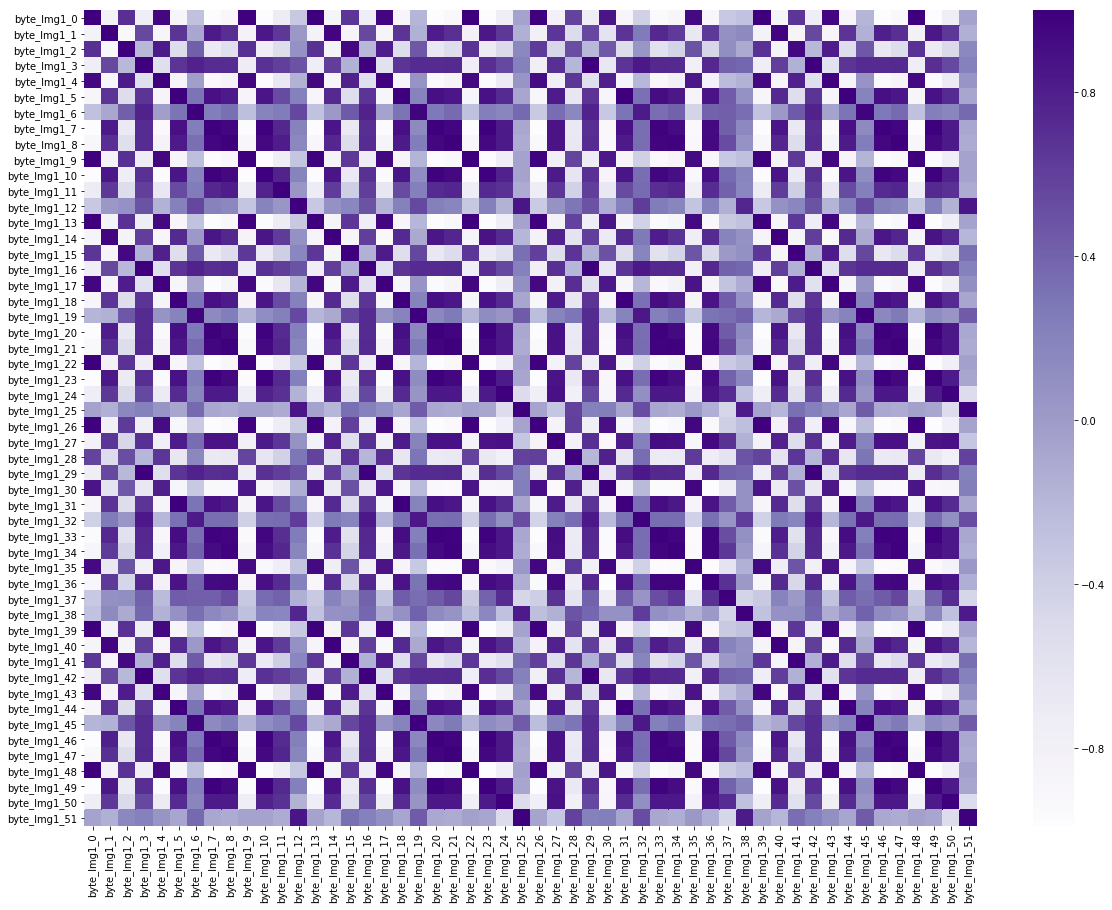

In [30]:
draw_heatmap_anNot(image_features, image_features)

Na toplinskoj karti uočavamo pravilnosti. Vrlo jasno vidimo jako korelirane značajke i grupe istih. To nam uvelike olakšava daljnju selekciju.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  92.92207792207792 %
Lollipop  -  99.11147011308562 %
Kelihos_ver3  -  67.39204352261136 %
Vundo  -  99.78902953586498 %
Simba  -  100.0 %
Tracur  -  85.06666666666666 %
Kelihos_ver1  -  81.10831234256926 %
Obfuscator.ACY  -  100.0 %
Gatak  -  99.30830039525692 %


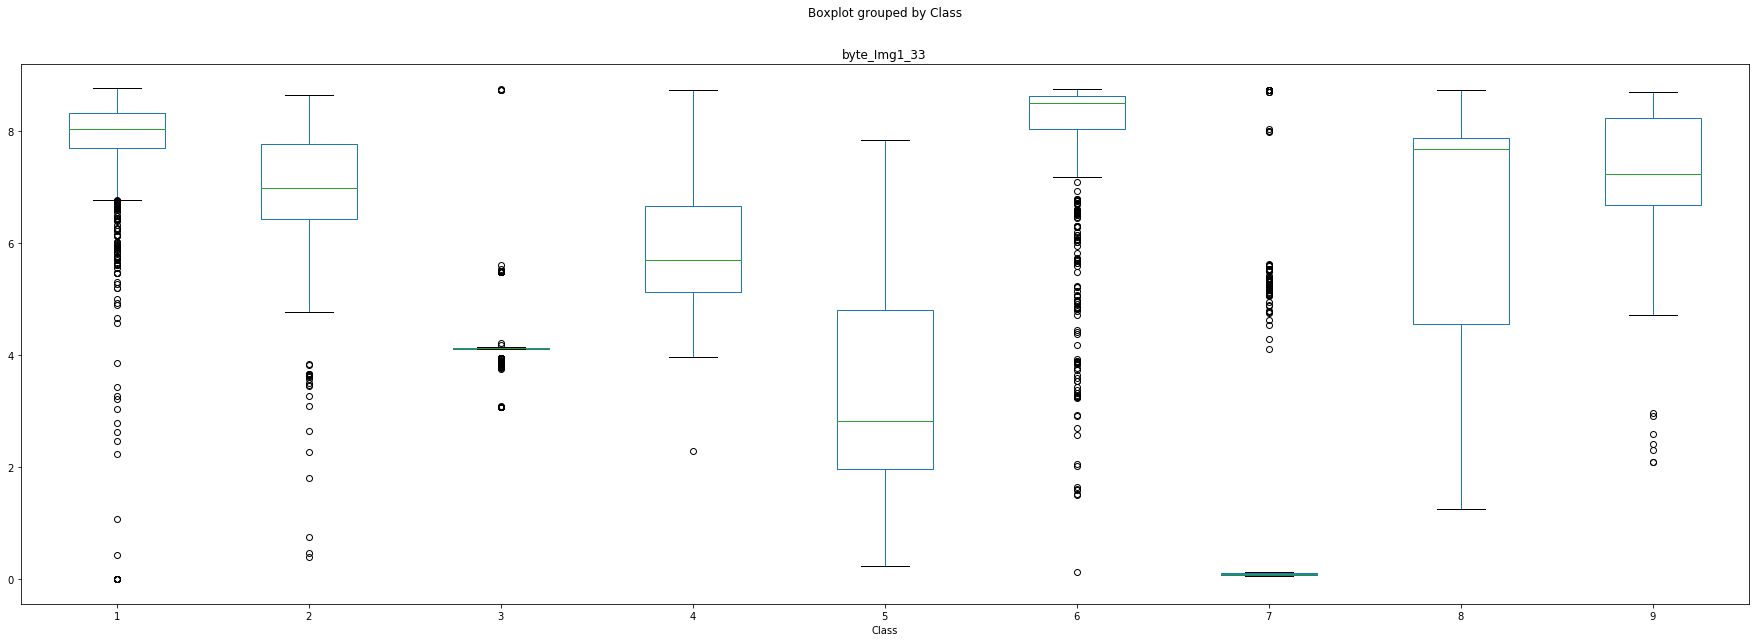

In [31]:
col = image_features.columns.get_loc('byte_Img1_33')

features.boxplot(column=[image_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( image_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>byte_Img1_33</code>  vidimo da imamo <i>outlier</i>-a u gotovo svim familijama <i>malware</i>-a. No, s obzirom da baratamo s velikim skupom podataka, očekivano je da će ih biti. 
Na primjer, za familiju <i>Obfuscator.ACY</i> i <i>Simba</i> svi su podaci unutar gornjeg i donjeg brka. S druge strane, možemo ponovno pogledati klasu <i>Kelihos_ver1</i>(<i>boxplot</i> broj 7) gdje su 29% podatka <i>outlier</i>-i. 

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( image_features, features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
image_accuracy_test = model.score(malware_test,malware_classes_test)
print(image_accuracy_test)

Značajnost ove kategorije je vrlo visoka pa je zasigurno uzimamo u daljnje razmatranje.

### duljina stringova
_STR_

In [32]:
# STRING LENGTH značajke 
string_length_features = features.iloc[:,514:630]
string_length_features.head()

string_len_counts_1  string_len_counts_2  string_len_counts_3  \
0                 3780                 1026                  513   
1                 7252                  961                  102   
2                 2854                  661                  488   
3                18932                  942                  251   
4                 1283                 1082                   78   

   string_len_counts_4  string_len_counts_5  string_len_counts_6  \
0                  173                  175                   79   
1                   56                   16                   25   
2                   21                   19                    5   
3                  131                   79                   46   
4                   41                   24                   18   

   string_len_counts_7  string_len_counts_8  string_len_counts_9  \
0                   28                   20                    6   
1                   12                   13                    9   
2                   14                    3                    7   
3                   46                   54                   61   
4                   17                    8                    9   

   string_len_counts_10  ...  string_len_counts_250_400  \
0                    10  ...                          0   
1                     8  ...                          0   
2                     5  ...                          0   
3                    54  ...                          0   
4                    15  ...                          0   

   string_len_counts_400_600  string_len_counts_600_900  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   string_len_counts_900_1300  string_len_counts_1300_2000  \
0                           0                            0   
1                           0                            1   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   string_len_counts_2000_3000  string_len_counts_3000_6000  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   string_len_counts_6000_15000  string_total_len  string_ratio  
0                             1              9664      0.049154  
1                             1             11961      0.048669  
2                             1             15716      0.106581  
3                             1             41668      0.051639  
4                             1              5252      0.032056  

[5 rows x 116 columns]

In [33]:
string_length_features.corrwith(features['Class']).dropna().sort_values() 

string_len_counts_52           -0.321184
string_len_counts_43           -0.272064
string_len_counts_98           -0.255179
string_len_counts_37           -0.249502
string_len_counts_36           -0.244991
string_len_counts_44           -0.228132
string_len_counts_26           -0.222266
string_len_counts_35           -0.189522
string_len_counts_40           -0.182373
string_len_counts_50           -0.162691
string_len_counts_30_60        -0.160623
string_len_counts_27           -0.157827
string_len_counts_14           -0.154818
string_len_counts_32           -0.154238
string_len_counts_11           -0.148732
string_len_counts_38           -0.137111
string_len_counts_34           -0.134482
string_len_counts_29           -0.129640
string_len_counts_23           -0.126496
string_len_counts_41           -0.125019
string_len_counts_10_30        -0.122655
string_len_counts_47           -0.117645
string_len_counts_9            -0.116249
string_len_counts_7            -0.115894
string_len_count

Vidimo da su neke značajke visoko korelirane s ciljnom značajkom, dok neke nisu. U nastavku standardno provodimo selekciju najboljih značajki dobivenih univarijantnom metodom. Za ovu kategoriju promatramo 30 najboljih.

- izbačeno  1  konstantnih značajki


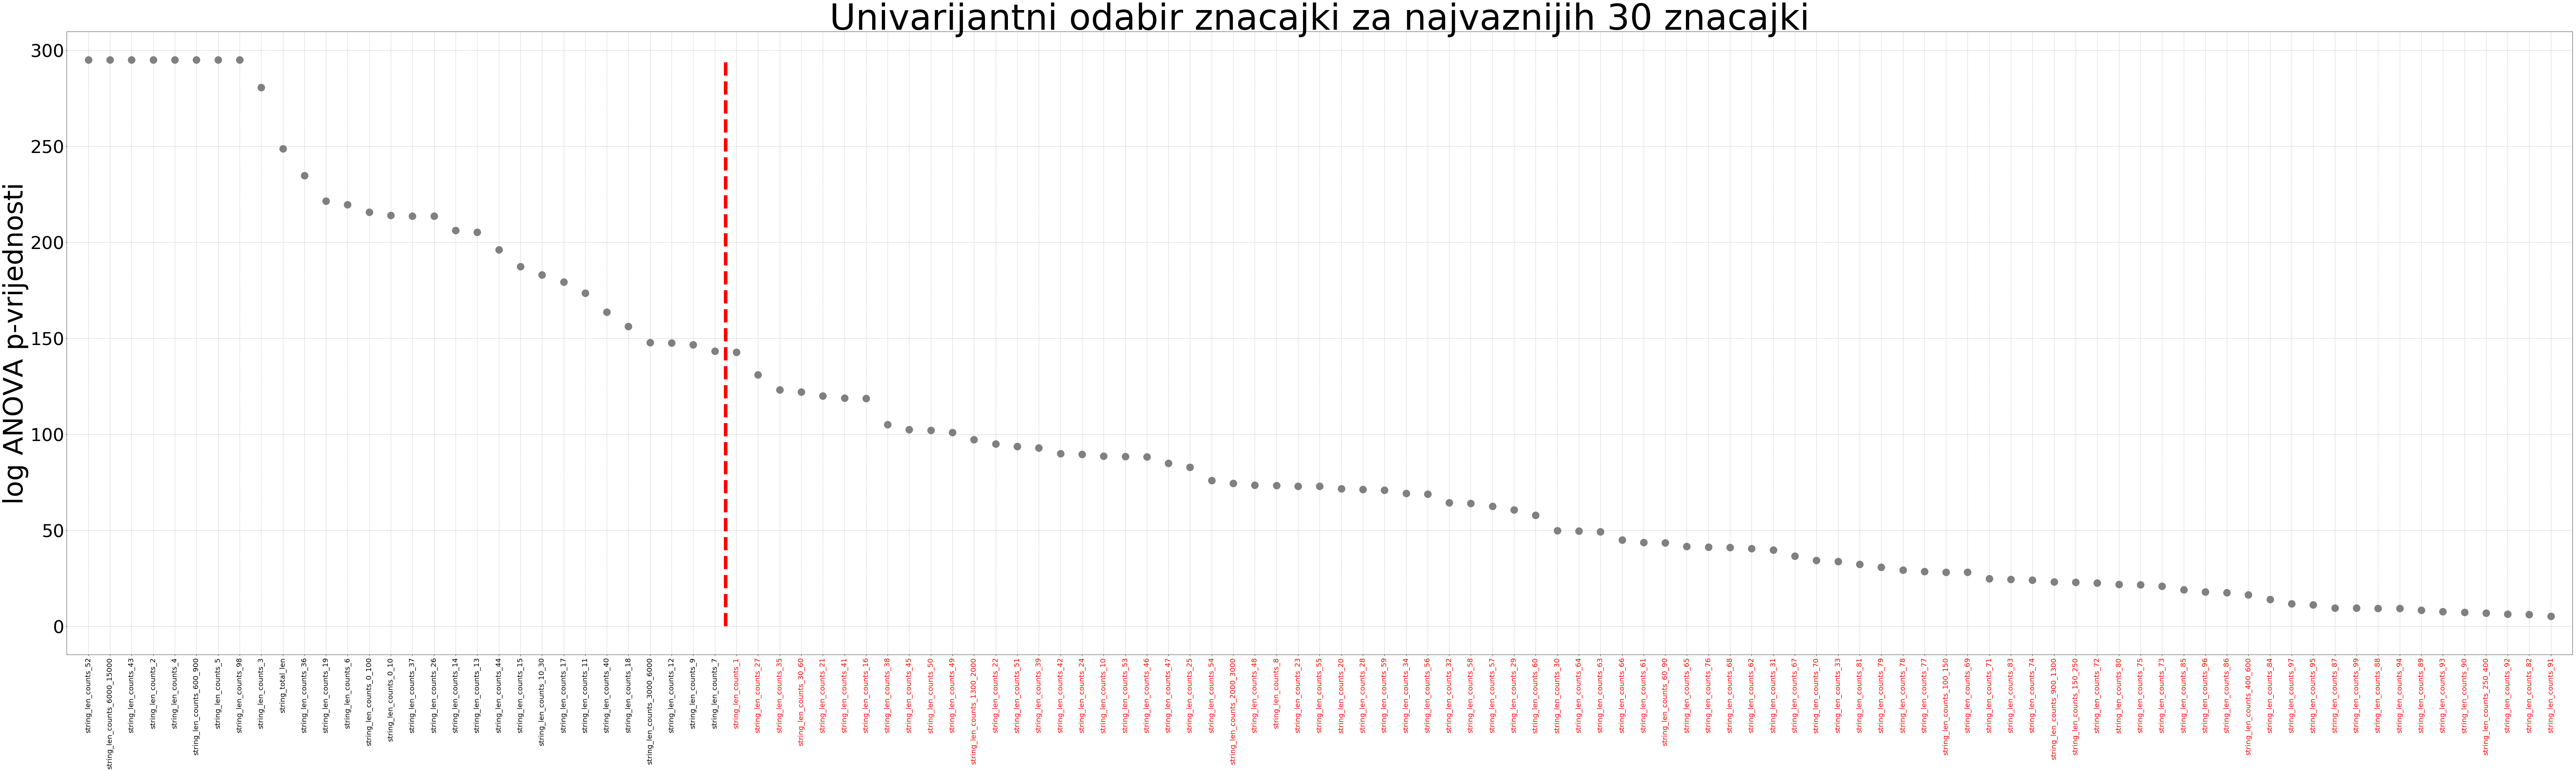

In [34]:
string_length_features_univariate = univariate_plot( features['Class'], string_length_features, 30)

In [35]:
string_length_features_univariate

array(['string_len_counts_52', 'string_len_counts_6000_15000',
       'string_len_counts_43', 'string_len_counts_2',
       'string_len_counts_4', 'string_len_counts_600_900',
       'string_len_counts_5', 'string_len_counts_98',
       'string_len_counts_3', 'string_total_len', 'string_len_counts_36',
       'string_len_counts_19', 'string_len_counts_6',
       'string_len_counts_0_100', 'string_len_counts_0_10',
       'string_len_counts_37', 'string_len_counts_26',
       'string_len_counts_14', 'string_len_counts_13',
       'string_len_counts_44', 'string_len_counts_15',
       'string_len_counts_10_30', 'string_len_counts_17',
       'string_len_counts_11', 'string_len_counts_40',
       'string_len_counts_18', 'string_len_counts_3000_6000',
       'string_len_counts_12', 'string_len_counts_9',
       'string_len_counts_7'], dtype=object)

In [ ]:
draw_histograms_rows_quantile(data = string_length_features, 
                              classes = classes_begining_and_end_in_features,
                              features = get_best_features_in_category_index_list(string_length_features, string_length_features_univariate), 
                              sections = 100, 
                              no_rows = 10, no_cols = 3, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*len(get_best_features_in_category_index_list(string_length_features, string_length_features_univariate)))

Iz gornjih histograma se dade naslutiti koreliranost između nekih značajki. Vidimo da postoje određene skupine unutar kojih postoji visoka koreliranost, dok je koreliranost između nekih značajki jako mala (npr. <code>string_len_counts_37</code> i <code>string_len_counts_2</code>). To bolje vidimo na sljedećoj toplinskoj karti.

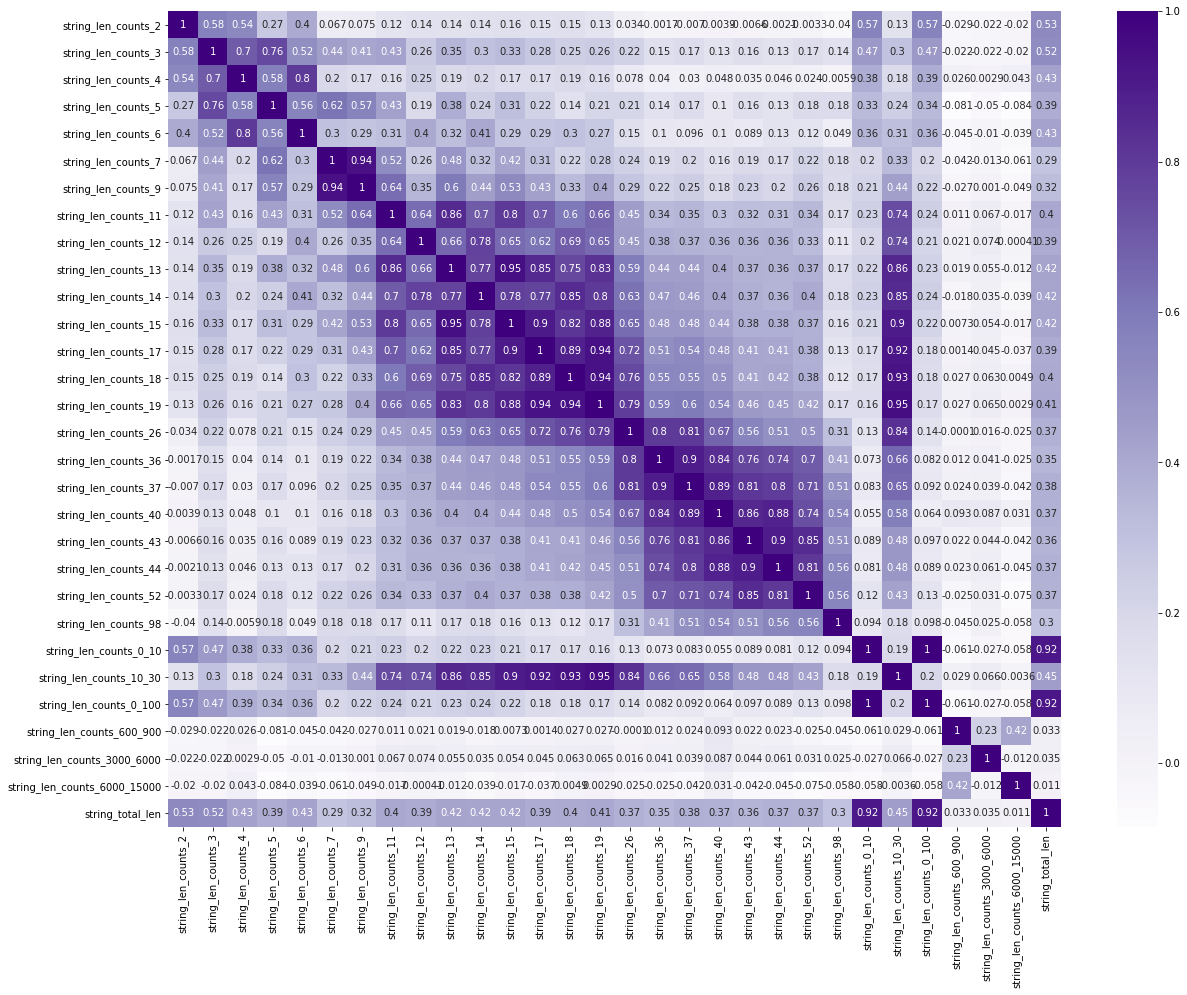

In [36]:
draw_heatmap(string_length_features, string_length_features_univariate)

Iz navedenih prikaza korelacija značajki iščitavamo kako i u ovoj skupini postoji korelacija među određenim varijablama kojojm ćemo se naknadno pozabaviti.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  90.51948051948052 %
Lollipop  -  89.8626817447496 %
Kelihos_ver3  -  67.39204352261136 %
Vundo  -  84.38818565400844 %
Simba  -  92.6829268292683 %
Tracur  -  99.86666666666667 %
Kelihos_ver1  -  81.36020151133502 %
Obfuscator.ACY  -  98.53300733496333 %
Gatak  -  85.7707509881423 %


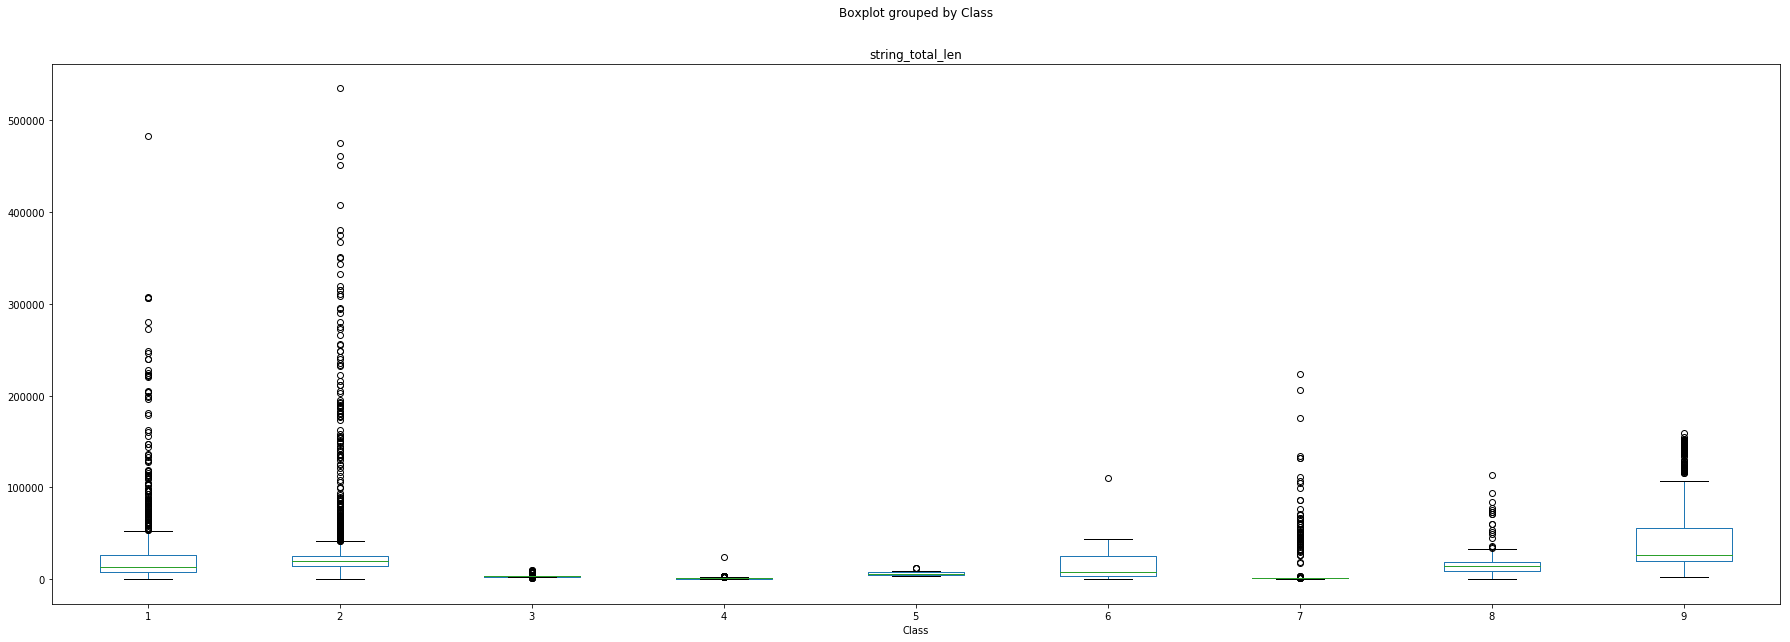

In [37]:
col = string_length_features.columns.get_loc('string_total_len')

features.boxplot(column=[string_length_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( string_length_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>string_total_len</code>  vidimo da imamo dosta <i>outlier</i>-a. No, s obzirom da baratamo s velikim skupom podataka i da se radi o značajki koja reprezentira ukupnu duljinu stringova u .bytes datoteci, očekivano je da će ih biti. 
U ovoj značajki, najbolje se pokazala klasa <i>Tracur</i>(<i>boxplot</i> broj 6) sa samo jednim <i>outlier</i>.

In [ ]:
df_string_length_features_univariate = string_length_features[string_length_features_univariate.tolist()

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( df_string_length_features_univariate.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
string_length_accuracy_test_univariate = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(string_length_accuracy_test_univariate)

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( string_length_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
string_length_accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(string_length_accuracy_test)

Usporedbom točnosti zaključujemo da smo uspjeli, uz smanjenje točnosti od 4%, smanjiti skup značajki sa 116 na 30 značajki.

<br>
<br>

## značajke dobivene iz _.asm_ datoteka

### (asm) metadata
_MDA_

Sljedeća tablica prikazuje vrijednosti značajki metapodataka (veličina .asm datoteke i broj linija unutar nje). 

In [38]:
# METADATA značajke iz asm datoteka
metadata_asm_features = features.iloc[:,630:632]
metadata_asm_features.head()

asm_md_filesize  asm_md_loc
0            14726        1276
1           606128       64610
2           133226       15897
3          1906854      231388
4           131451       16827

Za prvi dojam kakvoće podataka promatramo korelaciju s ciljnom značajkom.

In [39]:
metadata_asm_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_md_loc        -0.183667
asm_md_filesize   -0.162931
dtype: float64

Ove značajke su, jednako kao i metapodaci iz *.bytes* datoteka, dosta loše korelirane s ciljnom značajkom. 

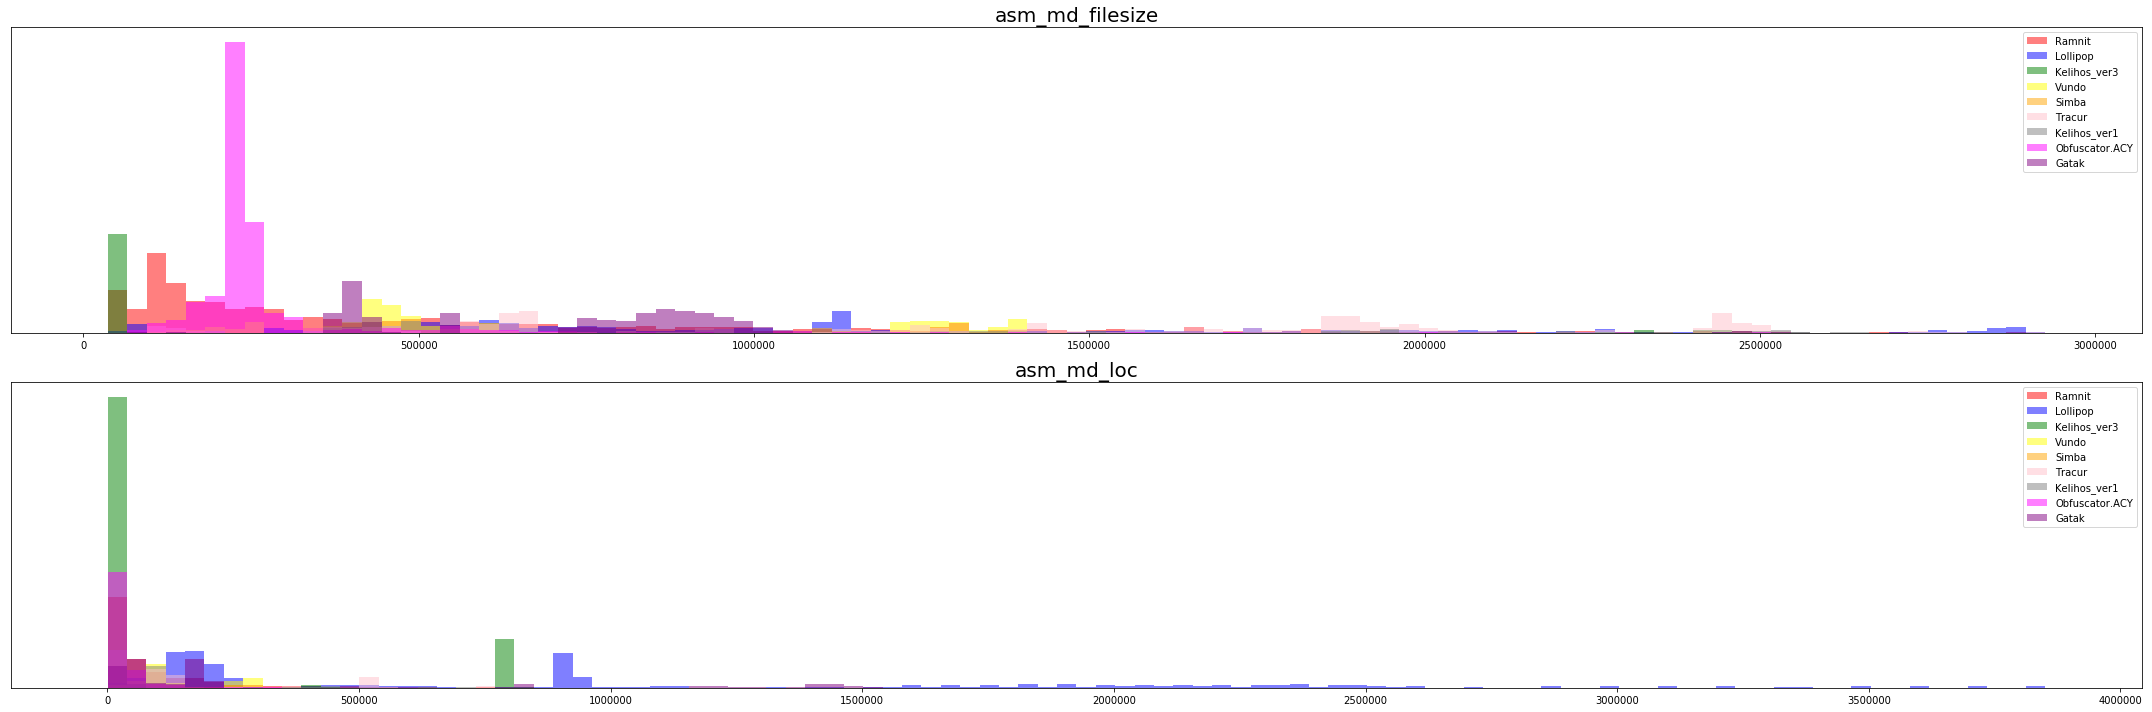

In [40]:
draw_histograms_rows_quantile( data = metadata_asm_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1], 
                              sections = 100, 
                              no_rows = 2, no_cols = 1, 
                              fig_x = 30, fig_y = 10,
                              i_want_whole_range = [False, True])

Iz gornjih histograma nije lako zaključiti o koreliranosti ovih dviju značajki. Vidimo da skupina <i>Kelihos_ver3</i> (zelena) ima značajno manju veličinu datoteke od ostalih skupina, skupina _Obfuscator.ACY_ (tamno roza).


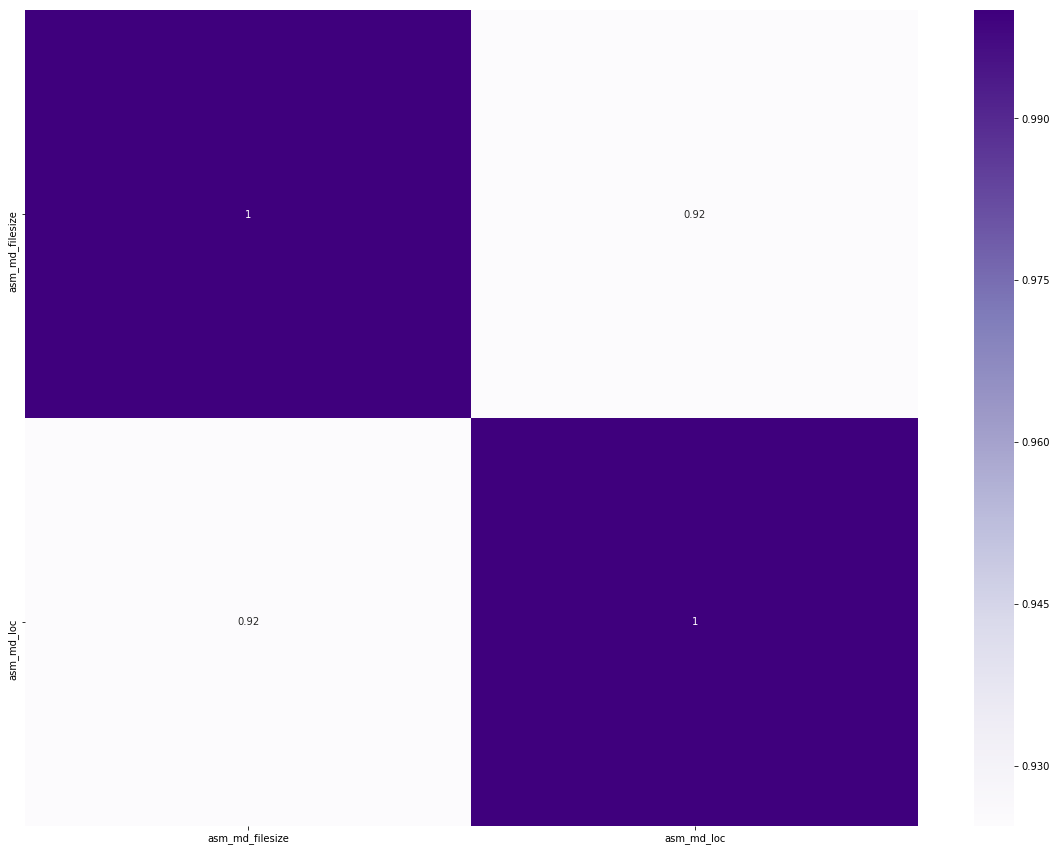

In [41]:
draw_heatmap(metadata_asm_features, metadata_asm_features.columns)

Korelacijska vrijednost ovih dviju značajki je iznimno visoka, iako *heatmap*-a to ne dočarava na prvi pogled već tek nakon detaljnijeg pogleda na legendu. Dakle, ovu kategoriju moći čemo reducirati na samo jednu značajku.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  91.03896103896105 %
Lollipop  -  95.84006462035542 %
Kelihos_ver3  -  84.32505950357022 %
Vundo  -  100.0 %
Simba  -  100.0 %
Tracur  -  100.0 %
Kelihos_ver1  -  75.56675062972292 %
Obfuscator.ACY  -  76.69111654441728 %
Gatak  -  99.90118577075098 %


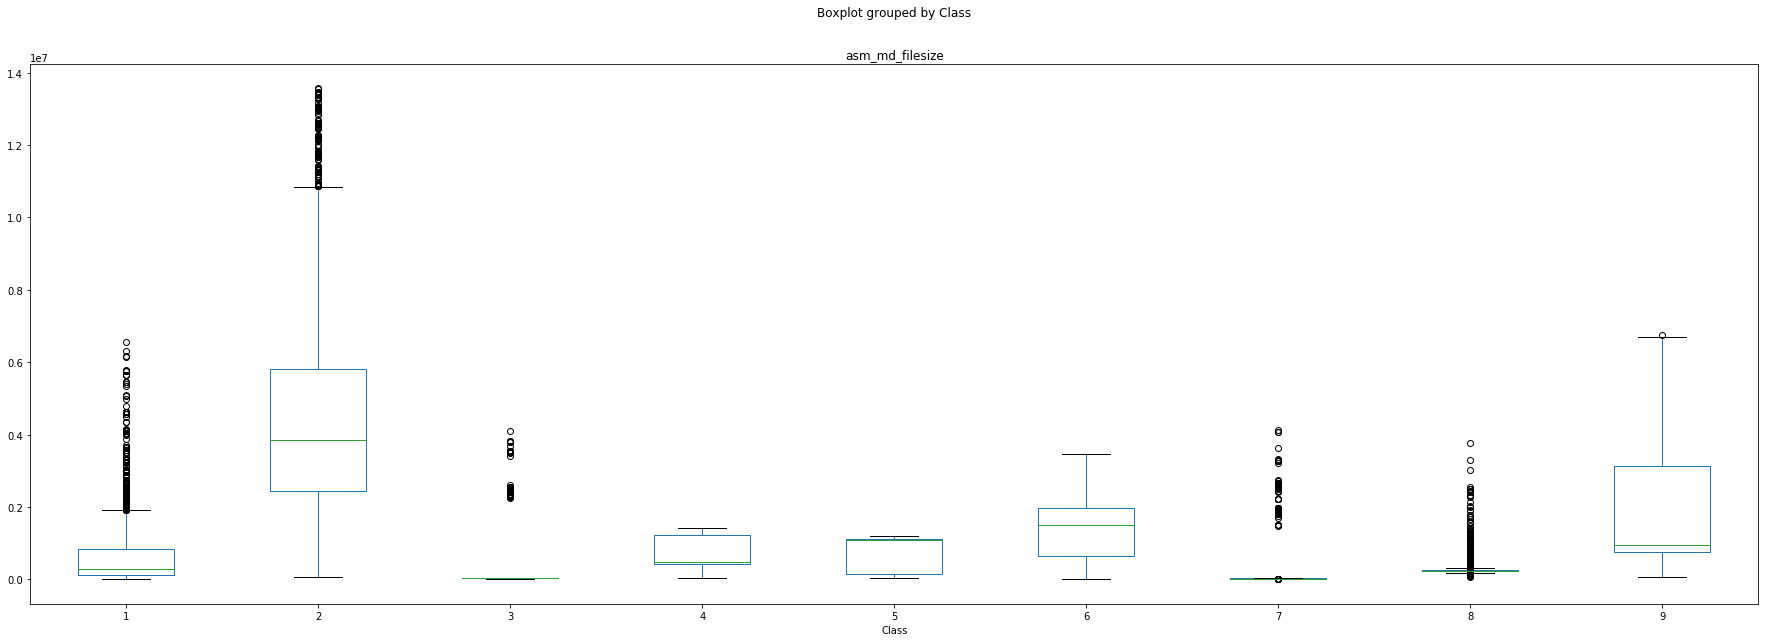

In [42]:
col = metadata_asm_features.columns.get_loc('asm_md_filesize')

features.boxplot(column=[metadata_asm_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( metadata_asm_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>asm_md_filesize</code>.
Vidimo dosta <i>outlier</i>-a u <i> boxplot</i>-ovima koji prikazuju stanje familija <i>Ramnit, Lollipop, Kelihos_ver3, Kelihos_ver1, Obfuscator.ACY</i>, no s obzirom na broj podataka, to je i očekivano. 

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( metadata_asm_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
metadata_asm_accuracy_test = model.score(malware_test, malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(metadata_asm_accuracy_test)

Točnost ove kategorije koja sadrži dvije značajke je samo 22% što je dosta loš rezultat u odnosu na većinu preostalih kategorija.

### simboli
_SYM_

In [43]:
# SYMBOLS značajke
symbols_features = features.iloc[:,632:639]
symbols_features.head()

asm_symb_Star  asm_symb_Dash  asm_symb_Plus  asm_symb_Bracket_Open  \
0             10             94            216                    125   
1           6876           5085          14173                  11375   
2            651            664           3263                   2287   
3            826          14382          56341                  41569   
4            123            774           3661                   2663   

   asm_symb_Bracket_Close  asm_symb_AtSign  asm_symb_Question  
0                     125               34                 53  
1                   11375             5551               5045  
2                    2287             1350               1349  
3                   41573               24                608  
4                    2663               12                138

In [44]:
symbols_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_symb_Bracket_Close   -0.191981
asm_symb_Bracket_Open    -0.172280
asm_symb_Plus            -0.138143
asm_symb_AtSign          -0.079919
asm_symb_Dash            -0.077858
asm_symb_Question        -0.046166
asm_symb_Star            -0.034939
dtype: float64

Vidimo da su sve značajke dosta loše korelirane sa ciljnom značajkom. 

U daljnoj analizi promatramo sve dobivene značajke.

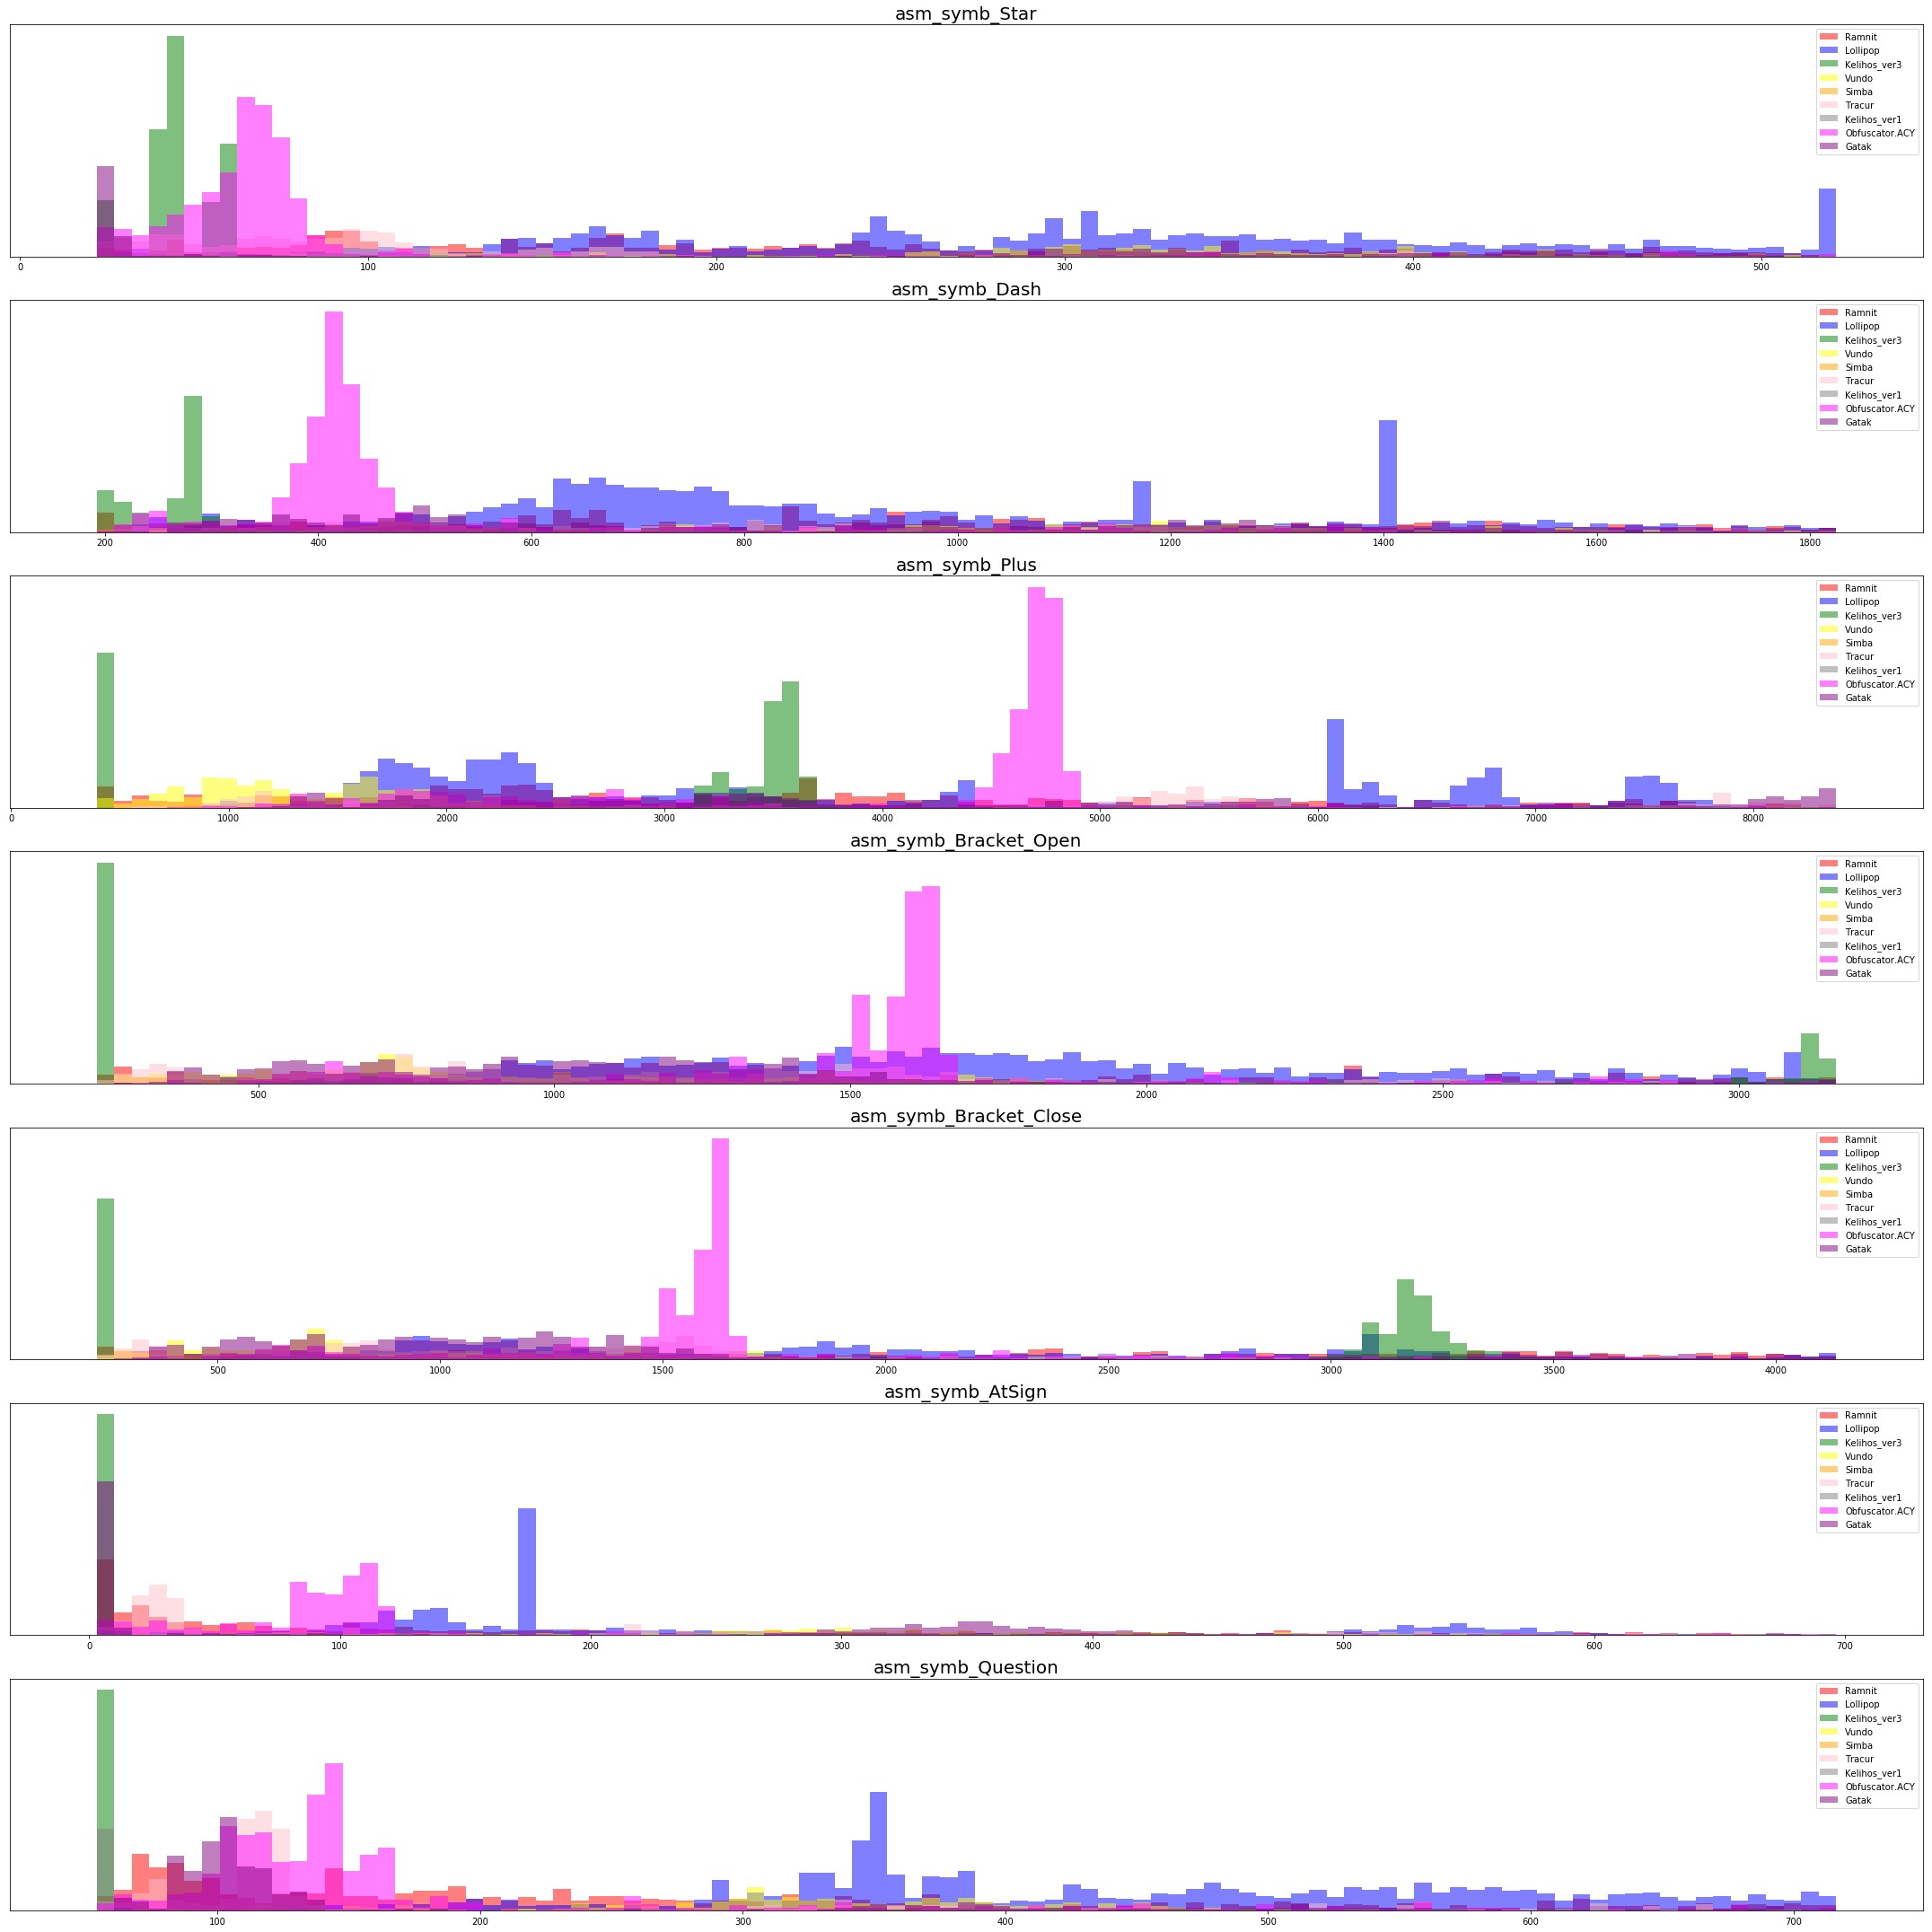

In [77]:
draw_histograms_rows_quantile(data = symbols_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5,6], 
                              sections = 100, 
                              no_rows = 7, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*7)

Iz prikazanih histograma nije očita koreliranost među varijablama. Promotrimo histogram asm_symb_Star koji prikazuje broj pojavljivanja znaka <code> * </code> u datotekama. Vidimo da skupine <i>Kelihos_ver3</i> (zelena) i _Obfuscator.ACY_ (tamno roza) imaju uglavnom broj pojavljivanja znaka <code>*</code> do 100. Također vidimo da kod primjerice skupine _Lollipop_ (plava) ne primjećujemo nikakvu pravilnost.

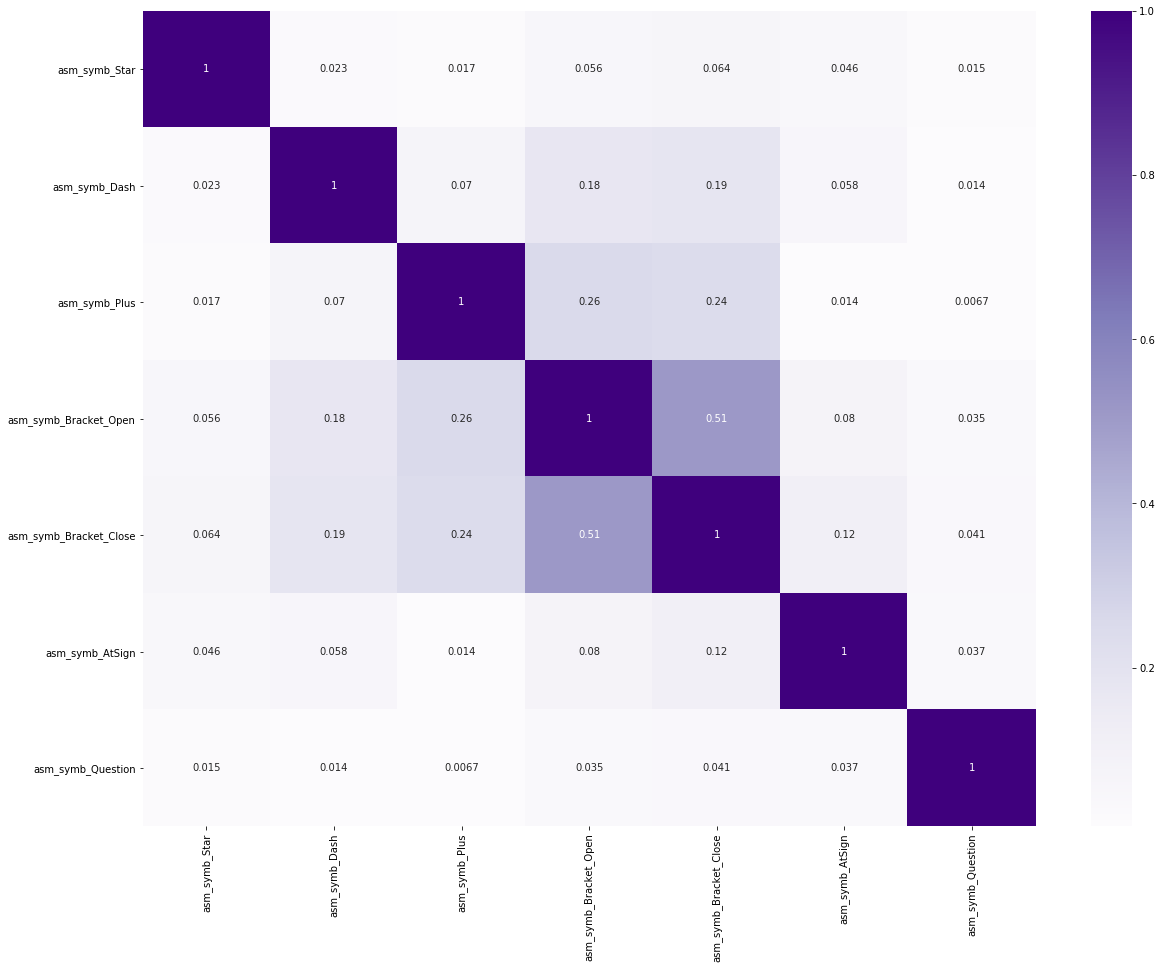

In [45]:
draw_heatmap(symbols_features, symbols_features.columns)

Toplinska karta potvrđuje pretpostavljeno. Vidimo da je većuna korelacijskih vrijednosti je blizu nule. 

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  85.84415584415585 %
Lollipop  -  82.06785137318255 %
Kelihos_ver3  -  84.59707582454948 %
Vundo  -  100.0 %
Simba  -  100.0 %
Tracur  -  79.46666666666667 %
Kelihos_ver1  -  81.10831234256926 %
Obfuscator.ACY  -  83.29258353708231 %
Gatak  -  80.63241106719367 %


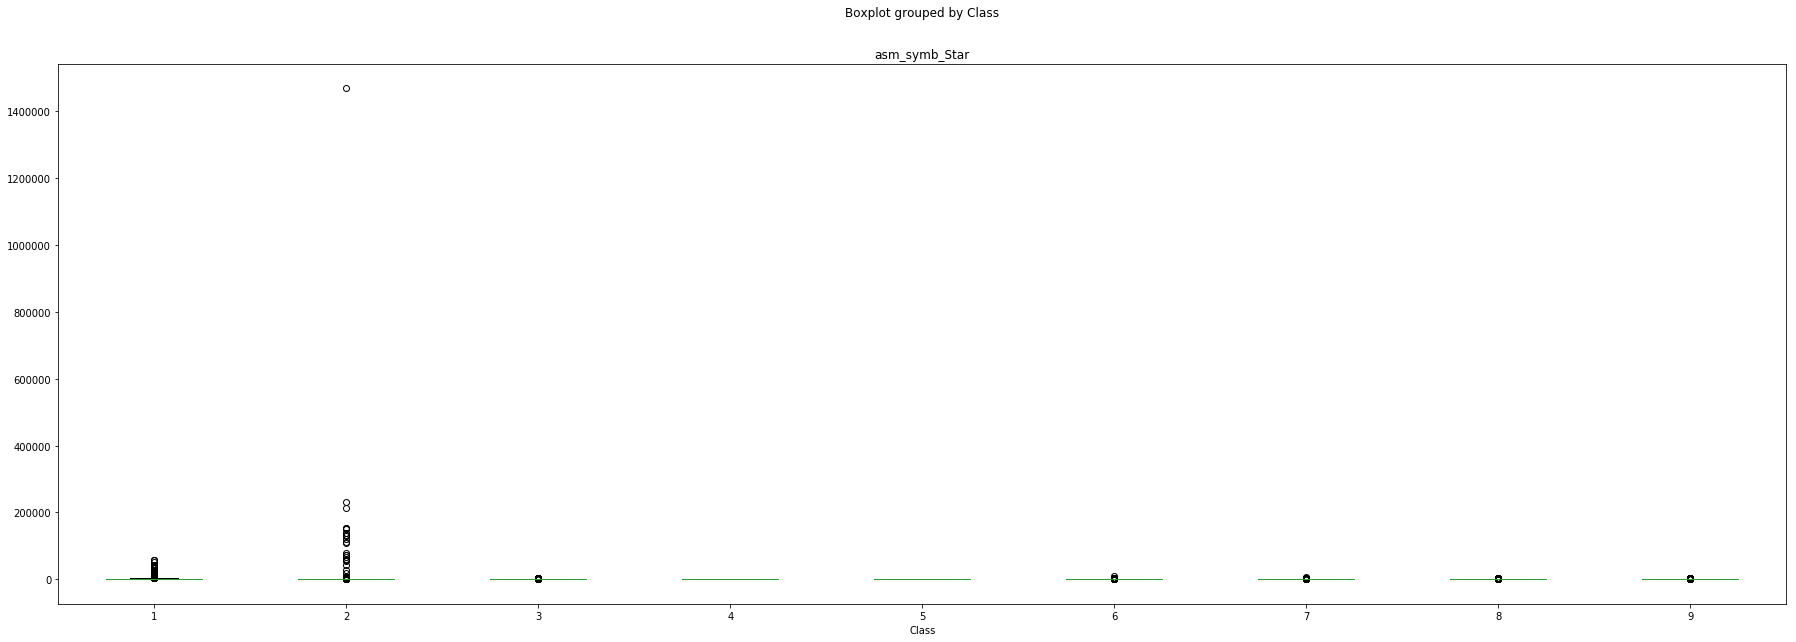

In [46]:
col = symbols_features.columns.get_loc('asm_symb_Star')

features.boxplot(column=[symbols_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( symbols_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>asm_symb_Star</code>.
Vidimo da su podaci uglavnom nalaze unutar gornjeg i donjeg brka svih podataka, osim za prve dvije klase <i>malware</i>-a, no s obzirom da te dvije klase imaju mnogo podataka, 1540 i 2941 respektivno, to je i očekivano. No, ova značajka poprima gotovo iste srednje vrijednosti u svim klasama <i>malware</i>-a, te zbog toga, kako smo predvidjeli prilikom analize korelacije te značajke sa ciljnom značajkom, ona nam neće dati mnogo informacija u konačnom modelu.

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( symbols_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
symbols_accuracy_test = model.score(malware_test,malware_classes_test)
print(symbols_accuracy_test)

### opcode
_OPC_

In [47]:
# OPCODE značajke
opcode_features = features.iloc[:,639:732]
opcode_features.head()

asm_opcodes_add  asm_opcodes_al  asm_opcodes_bt  asm_opcodes_call  \
0               11               1               0                53   
1              356              25               0              2900   
2              176              31               0               461   
3             1214             285               0             10686   
4              532               2               0               462   

   asm_opcodes_cdq  asm_opcodes_cld  asm_opcodes_cli  asm_opcodes_cmc  \
0                0                0                0                0   
1                1                0                0                0   
2                2                0                0                0   
3               25                5                1                0   
4                2                1                0                0   

   asm_opcodes_cmp  asm_opcodes_const  ...  asm_opcodes_sidt  asm_opcodes_stc  \
0               15                  4  ...                 0                0   
1             1585               2259  ...                 0                0   
2              320                123  ...                 0                0   
3             7071                176  ...                 0                2   
4              539                  5  ...                 0                0   

   asm_opcodes_std  asm_opcodes_sti  asm_opcodes_stos  asm_opcodes_sub  \
0                0                0                 0                5   
1                0                0                 0              311   
2                0                0                 0               73   
3                4                0                 0             1240   
4                0                0                 0              221   

   asm_opcodes_test  asm_opcodes_wait  asm_opcodes_xchg  asm_opcodes_xor  
0                14                 0                 0               17  
1               817                 0                 1              739  
2               183                 0                 0              180  
3              4996                 1                 3             2901  
4               362                 0                38              254  

[5 rows x 93 columns]

In [48]:
opcode_features.corrwith(features['Class']).dropna().sort_values() 

asm_opcodes_jb      -0.227684
asm_opcodes_jnz     -0.222423
asm_opcodes_pop     -0.219832
asm_opcodes_mov     -0.216970
asm_opcodes_endp    -0.213391
asm_opcodes_retn    -0.212550
asm_opcodes_setz    -0.210896
asm_opcodes_near    -0.210732
asm_opcodes_lea     -0.208323
asm_opcodes_cdq     -0.202362
asm_opcodes_test    -0.198449
asm_opcodes_dec     -0.197427
asm_opcodes_jz      -0.196706
asm_opcodes_cmp     -0.192492
asm_opcodes_call    -0.190419
asm_opcodes_int     -0.189620
asm_opcodes_push    -0.178440
asm_opcodes_rep     -0.174234
asm_opcodes_jl      -0.174004
asm_opcodes_jmp     -0.166324
asm_opcodes_db      -0.161023
asm_opcodes_movzx   -0.156600
asm_opcodes_popf    -0.153998
asm_opcodes_pushf   -0.153498
asm_opcodes_inc     -0.152881
asm_opcodes_add     -0.138110
asm_opcodes_al      -0.137930
asm_opcodes_shr     -0.134693
asm_opcodes_jnb     -0.126171
asm_opcodes_rcr     -0.122515
                       ...   
asm_opcodes_rdtsc   -0.043811
asm_opcodes_rol     -0.036969
asm_opcode

U korelacijskim vrijednostima za sada ne uočavamo nikakvu pravilnost. Budući da su opcode instrukcije koje specificiraju koje operacije procesor treba učiniti ova kategorija nam je poprilično važna. Zato u univarijantnoj metodi odabira uzimamo popriličan udio podataka. Time želimo spriječiti i smanjenje točnosti ove bitne kategorije.

- izbačeno  4  konstantnih značajki


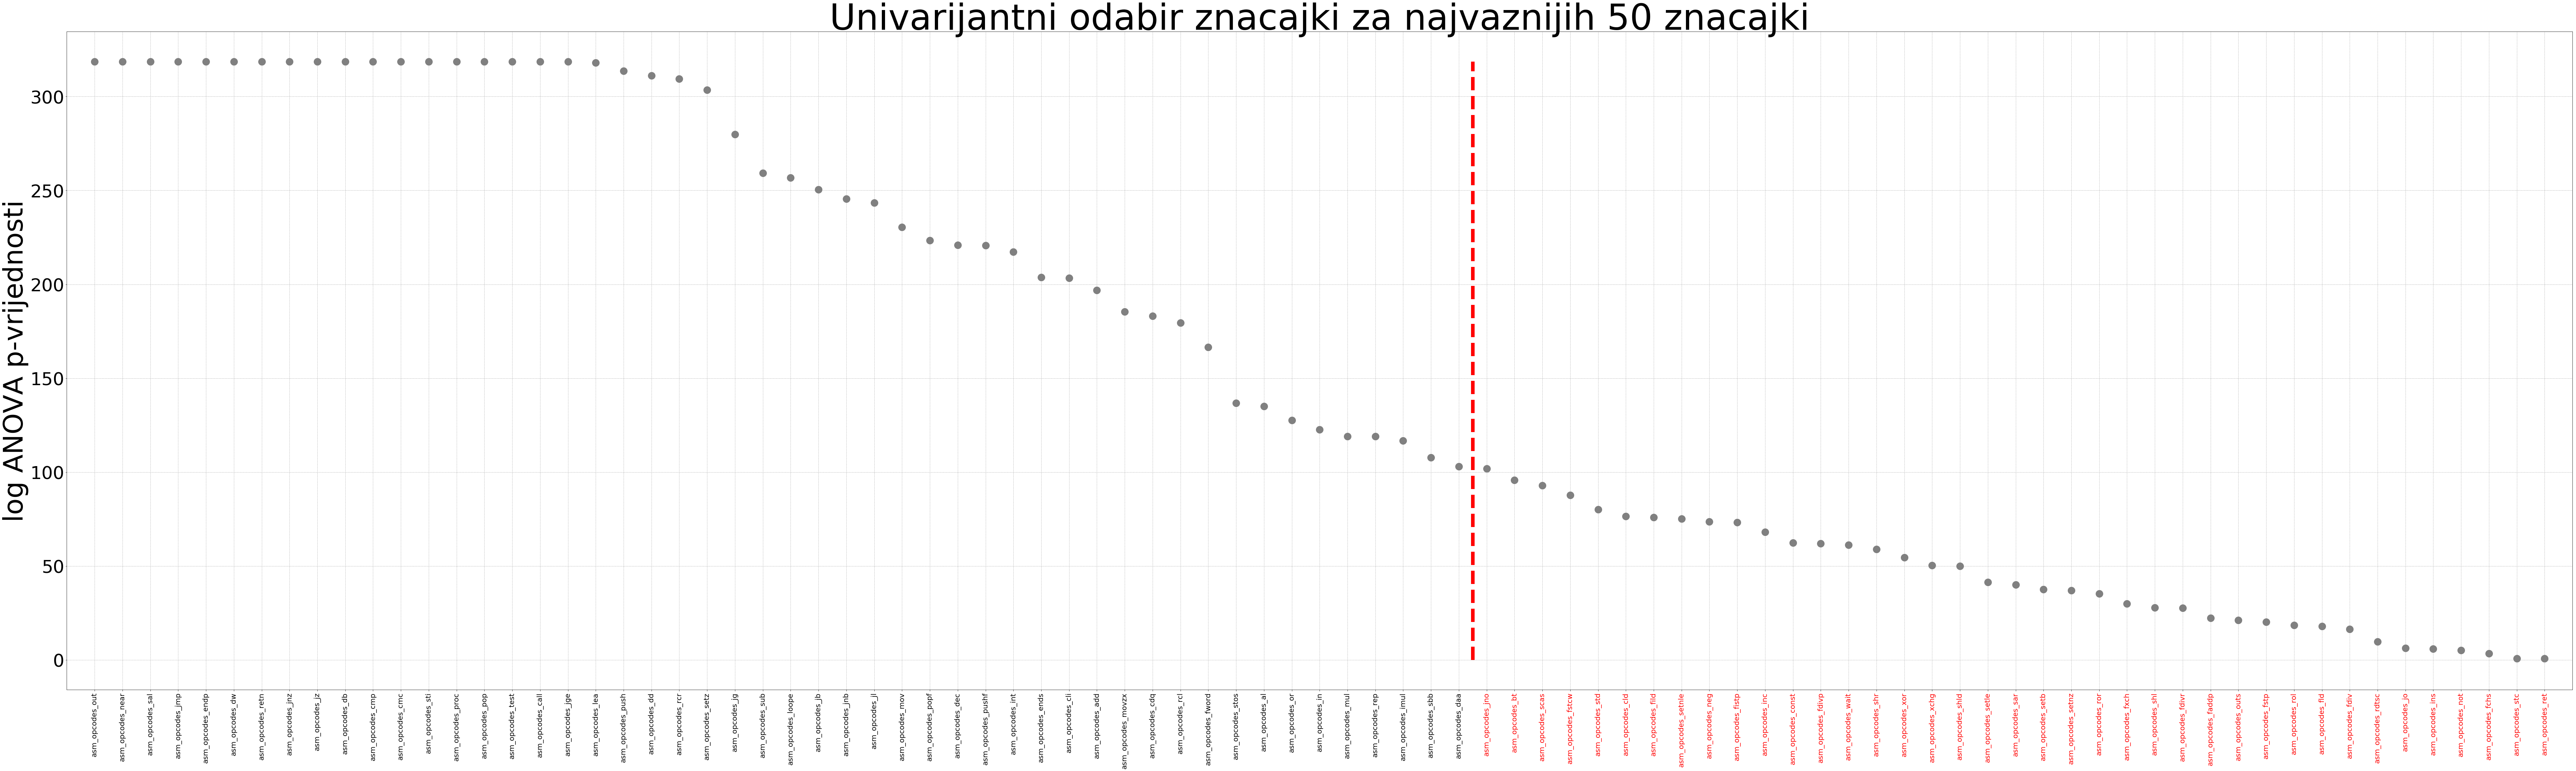

In [49]:
opcode_features_univariate = univariate_plot( features['Class'], opcode_features, 50 ) 

In [50]:
opcode_features_univariate

array(['asm_opcodes_out', 'asm_opcodes_near', 'asm_opcodes_sal',
       'asm_opcodes_jmp', 'asm_opcodes_endp', 'asm_opcodes_dw',
       'asm_opcodes_retn', 'asm_opcodes_jnz', 'asm_opcodes_jz',
       'asm_opcodes_db', 'asm_opcodes_cmp', 'asm_opcodes_cmc',
       'asm_opcodes_sti', 'asm_opcodes_proc', 'asm_opcodes_pop',
       'asm_opcodes_test', 'asm_opcodes_call', 'asm_opcodes_jge',
       'asm_opcodes_lea', 'asm_opcodes_push', 'asm_opcodes_dd',
       'asm_opcodes_rcr', 'asm_opcodes_setz', 'asm_opcodes_jg',
       'asm_opcodes_sub', 'asm_opcodes_loope', 'asm_opcodes_jb',
       'asm_opcodes_jnb', 'asm_opcodes_jl', 'asm_opcodes_mov',
       'asm_opcodes_popf', 'asm_opcodes_dec', 'asm_opcodes_pushf',
       'asm_opcodes_int', 'asm_opcodes_ends', 'asm_opcodes_cli',
       'asm_opcodes_add', 'asm_opcodes_movzx', 'asm_opcodes_cdq',
       'asm_opcodes_rcl', 'asm_opcodes_fword', 'asm_opcodes_stos',
       'asm_opcodes_al', 'asm_opcodes_or', 'asm_opcodes_in',
       'asm_opcodes_mul', 'asm_

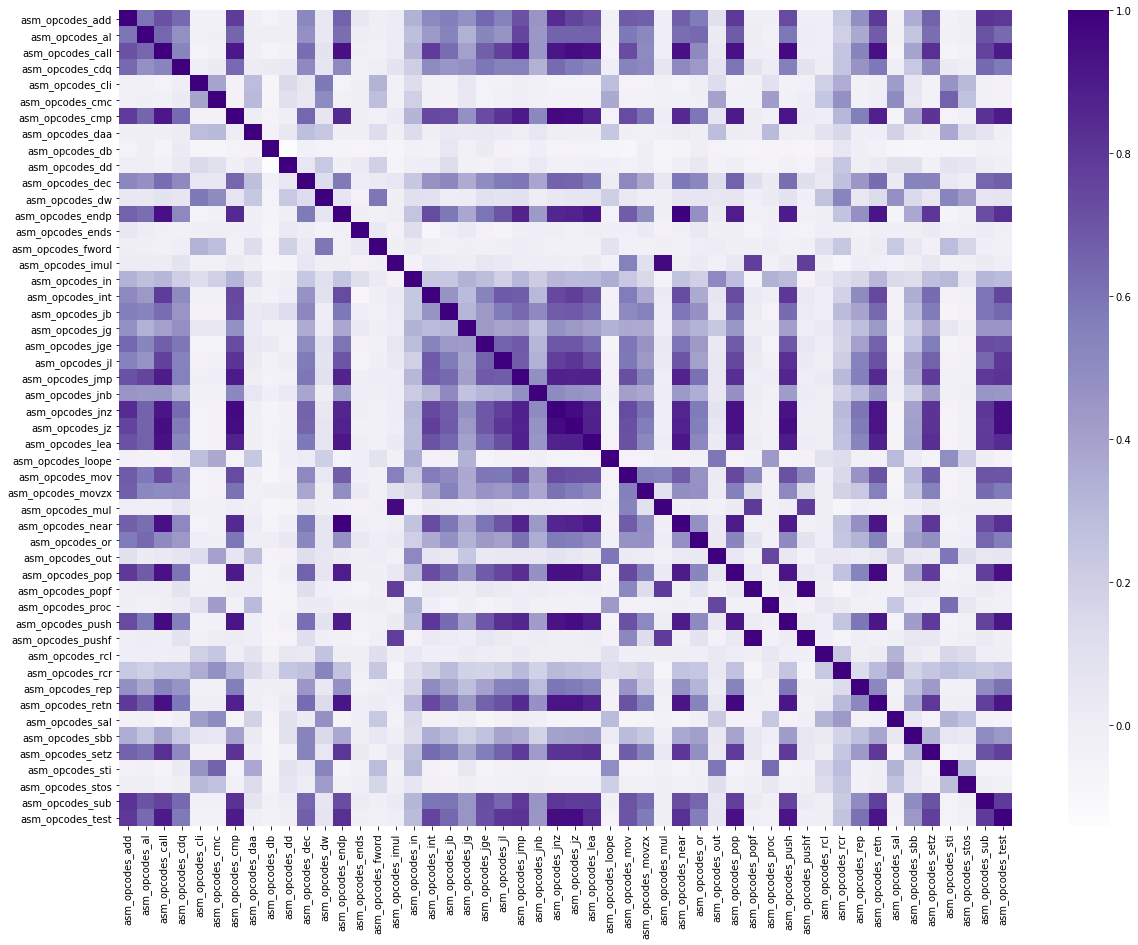

In [51]:
draw_heatmap_anNot(opcode_features, opcode_features_univariate)

Unatoč velikom broju slabo koreliranih, jasno uočavamo visoku koreliranost pojedinih značajki.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  91.03896103896105 %
Lollipop  -  94.9919224555735 %
Kelihos_ver3  -  78.61271676300578 %
Vundo  -  95.9915611814346 %
Simba  -  80.48780487804879 %
Tracur  -  97.33333333333334 %
Kelihos_ver1  -  78.58942065491183 %
Obfuscator.ACY  -  96.7400162999185 %
Gatak  -  98.71541501976284 %


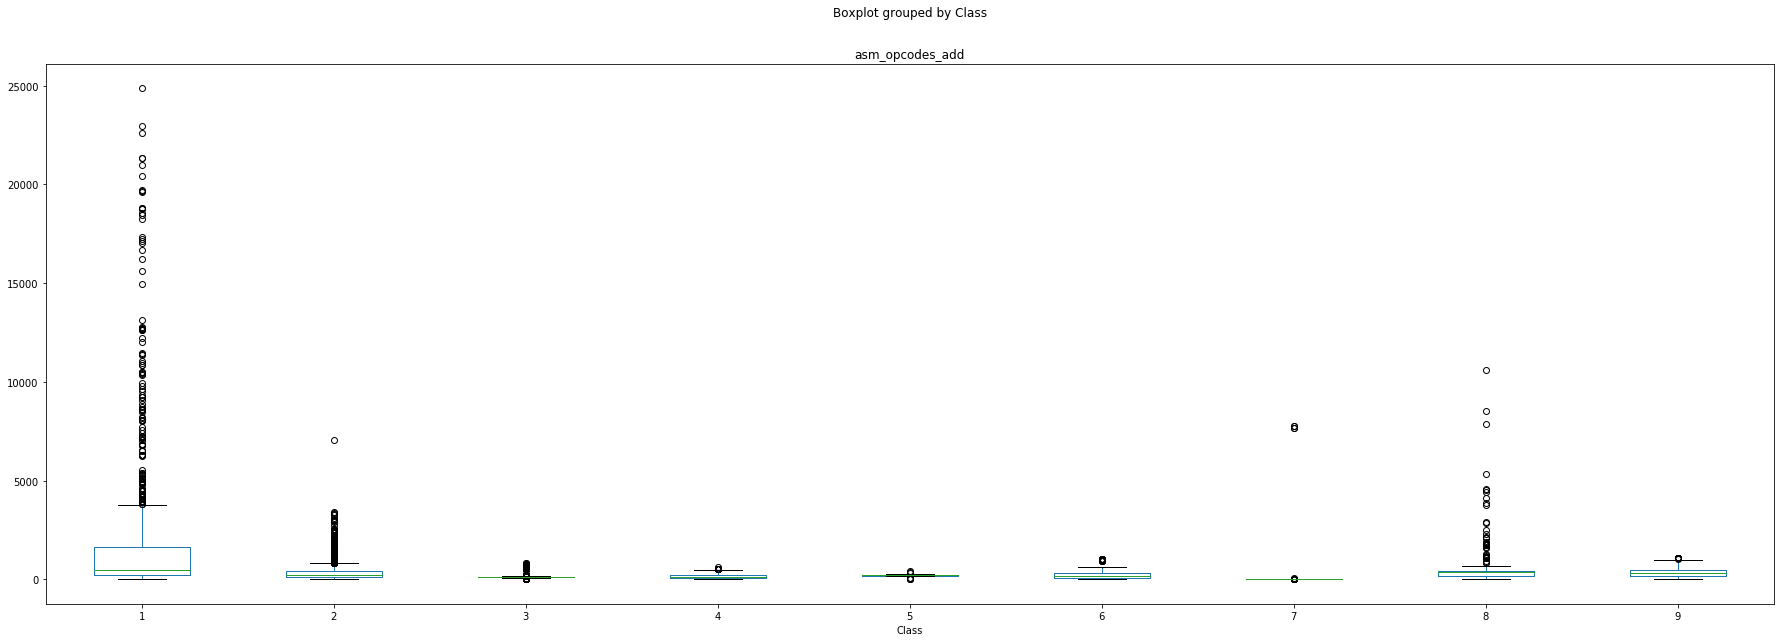

In [52]:
col = opcode_features.columns.get_loc('asm_opcodes_add')

features.boxplot(column=[opcode_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( opcode_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>asm_opcodes_add</code>.
Vidimo da su podaci uglavnom nalaze unutar gornjeg i donjeg brka svih podataka, osim za prve tri klase <i>malware</i>-a, no s obzirom da te dvije klase imaju mnogo podataka, 1540 i 2941 respektivno, to je i očekivano. No, ova značajka poprima gotovo iste srednje vrijednosti u svim klasama <i>malware</i>-a, te zbog toga, kako smo predvidjeli prilikom analize korelacije te značajke sa ciljnom značajkom, ona nam neće dati mnogo informacija u konačnom modelu.

In [ ]:
df_opcode_features_univariate = opcode_features[opcode_features_univariate.tolist()]

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( df_opcode_features_univariate.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
opcode_accuracy_test_univariate = model.score(malware_test,malware_classes_test) 
print(opcode_accuracy_test_univariate)

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( opcode_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
opcode_accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(opcode_accuracy_test)

### registri
_REG_

In [53]:
# REGISTER značajke
reg_features = features.iloc[:,732:758]
reg_features.head()

asm_regs_edx  asm_regs_esi  asm_regs_es  asm_regs_fs  asm_regs_ds  \
0            23            35            0            0            0   
1           936          5027            1            1            1   
2          1011           895            0            1            0   
3          3942         19687            1            1            1   
4          1058          1402            1            1            1   

   asm_regs_ss  asm_regs_gs  asm_regs_cs  asm_regs_ah  asm_regs_al  ...  \
0            0            0            0            0            3  ...   
1            1            1            1            3           45  ...   
2            0            1            0            0           60  ...   
3            2            1            1           28          597  ...   
4            1            1            1            0           22  ...   

   asm_regs_cx  asm_regs_dh  asm_regs_dl  asm_regs_dx  asm_regs_eax  \
0            0            0            0            0           137   
1           33            4           15           20          9839   
2            4            0           15            0          2111   
3           94            8          232           46         41449   
4            2            0            5            0          2637   

   asm_regs_ebp  asm_regs_ebx  asm_regs_ecx  asm_regs_edi  asm_regs_esp  
0            43            19            66            15            81  
1          6382          2511          5024          3972           713  
2           446           444          1378           562           730  
3         28751         11489         15737         16619          2832  
4           930           930          1561          1240           844  

[5 rows x 26 columns]

Broj značajki je dovoljno mali pa ih nećemo reducirati.

In [54]:
reg_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

asm_regs_esi   -0.250088
asm_regs_eax   -0.231631
asm_regs_edi   -0.227145
asm_regs_ecx   -0.222115
asm_regs_ebx   -0.213319
asm_regs_cl    -0.184096
asm_regs_cx    -0.181143
asm_regs_ebp   -0.179819
asm_regs_bl    -0.178614
asm_regs_edx   -0.173050
asm_regs_dx    -0.171895
asm_regs_esp   -0.171745
asm_regs_ax    -0.166863
asm_regs_al    -0.136881
asm_regs_bx    -0.127162
asm_regs_dl    -0.113398
asm_regs_ah    -0.082052
asm_regs_fs    -0.015427
asm_regs_gs    -0.007415
asm_regs_dh    -0.006703
asm_regs_ch    -0.004324
asm_regs_es     0.017658
asm_regs_bh     0.036370
asm_regs_ds     0.064211
asm_regs_ss     0.090720
asm_regs_cs     0.107755
dtype: float64

In [ ]:
draw_histograms_rows_quantile(data = reg_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [i for i in range(26)], 
                              sections = 100, 
                              no_rows = 13, no_cols = 2, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*26)

Iz gornjih histograma primjećujemo da postoje određene skupine unutar kojih postoji visoka koreliranost, dok je koreliranost među različitim skupinama mala. Primjerice, možemo pretpostaviti da su asm_regs_edx i asm_regs_esi korelirani te da su asm_regs_es i asm_regs_fs korelirani, dok je korelacija između asm_regs_edx i asm_regs_es jako mala. Ako promotrimo primjerice histogram asm_regs_ecx vidimo da skupina Kelihos_ver3 (zelena) pripadni registar ne koristi mnogo te vidimo da ga najviše koristi skupina Obfuscator.ACY (tamno roza)

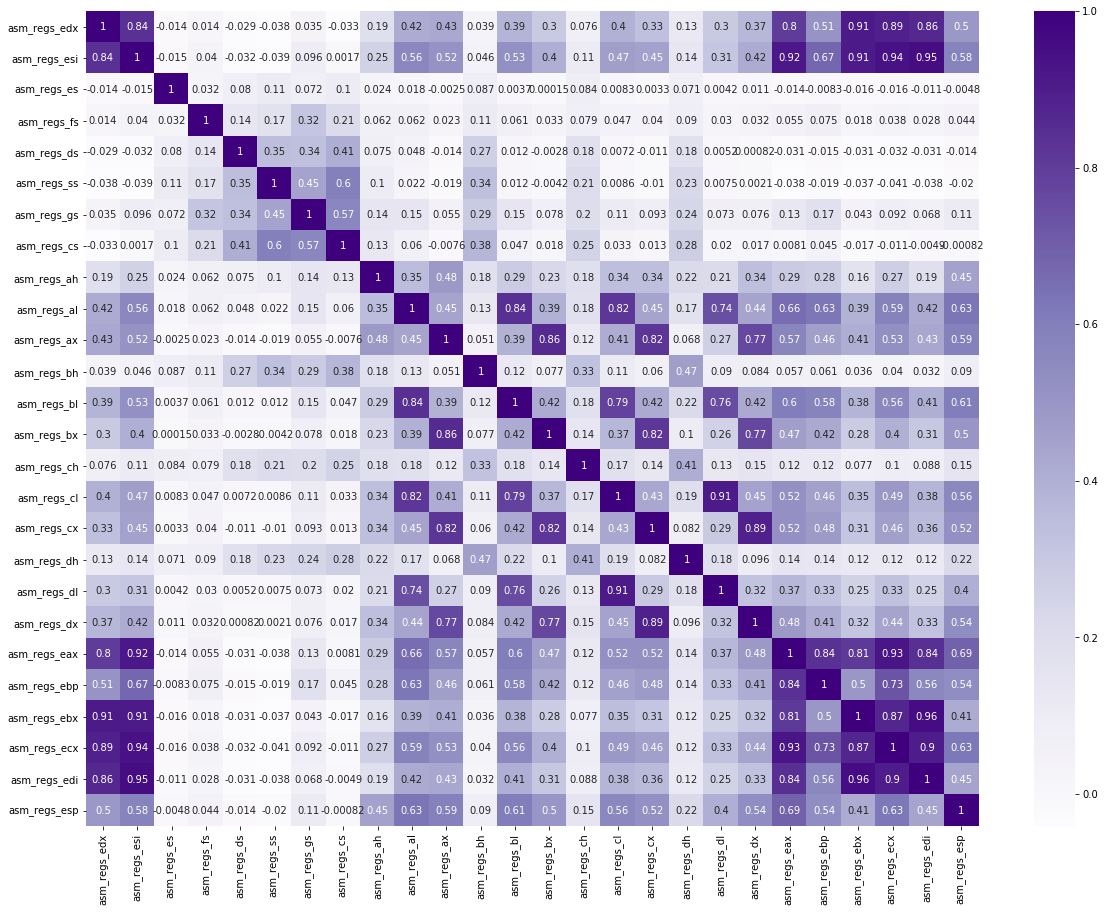

In [55]:
draw_heatmap(reg_features, reg_features.columns)

Uočavamo visoku koreliranost, kako značajki u parovima, tako i skupina značajki koje ćemo moći odbaciti.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  89.74025974025975 %
Lollipop  -  82.06785137318255 %
Kelihos_ver3  -  91.73750425025501 %
Vundo  -  100.0 %
Simba  -  75.60975609756098 %
Tracur  -  83.86666666666667 %
Kelihos_ver1  -  88.41309823677582 %
Obfuscator.ACY  -  77.75061124694376 %
Gatak  -  98.81422924901186 %


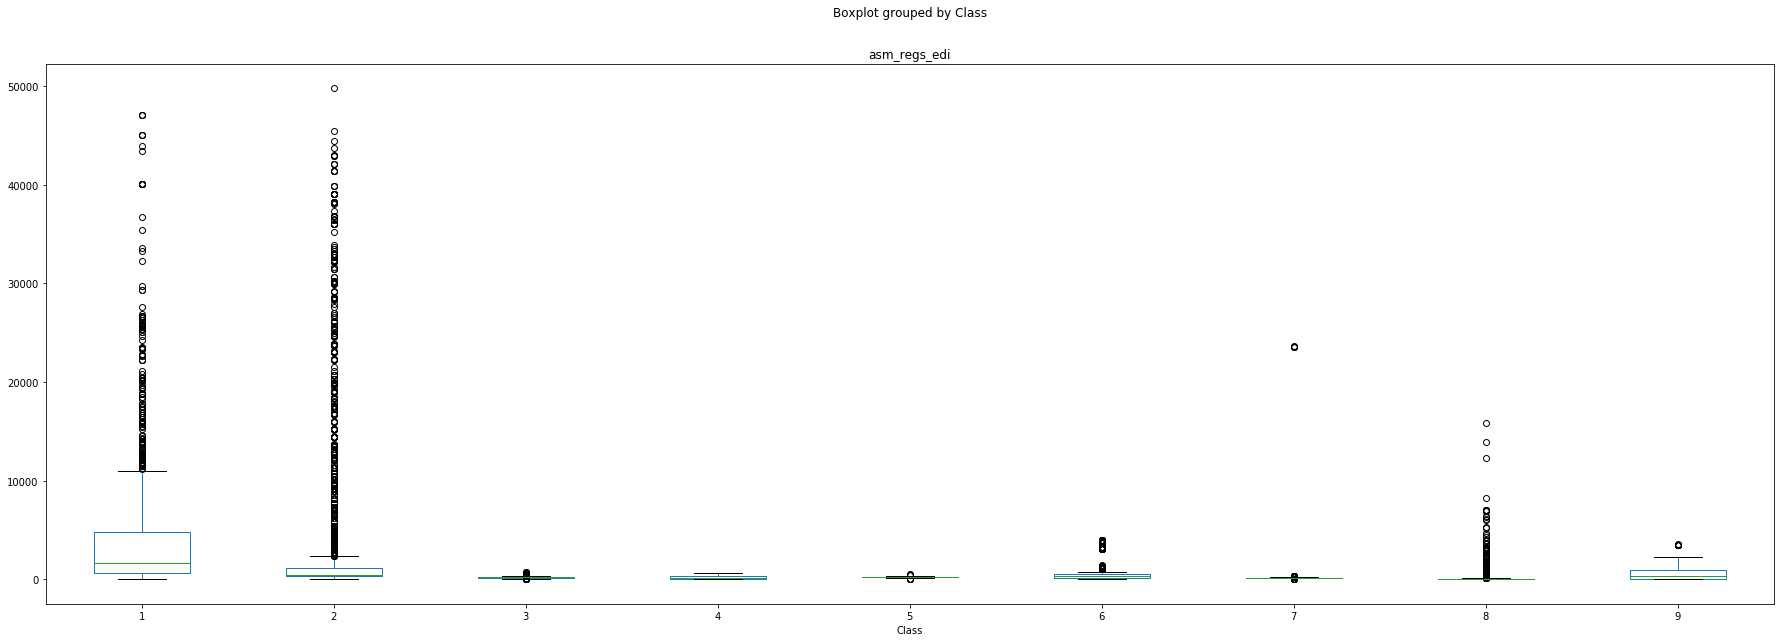

In [56]:
col = reg_features.columns.get_loc('asm_regs_edi')

features.boxplot(column=[reg_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( reg_features, col, classes_begining_and_end_in_features)

Uočavamo visoku koreliranost, kako značajki u parovima, tako i skupina značajki koje ćemo moći odbaciti. No u ovoj skupini imamo i popriličan broj nekoreliranih varijabli koje nećemo moći odbaciti.

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>asm_regs_edi</code>.
Ova značajka poprima gotovo iste srednje vrijednosti u svim klasama <i>malware</i>-a, korelacije te značajke sa ciljnom značajkom vrlo mala, zaključujemo da nam ona neće dati mnogo informacija u konačnom modelu. Također, možemo vidjeti da familije <i>Lollipop</i> i <i>Ramnit</i> imaju mnogo <i>outlier</i>-a, to jest 158 i 445 respektivno.

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( reg_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
reg_accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(reg_accuracy_test)

Skupina značajki koja govori o frekvenciji korištenja registara postiže visoku točnost zbog čega je svrstavamo među bitne.

### sekcije
_SEC_

In [57]:
# SECTION značajke
section_features = features.iloc[:,758:782]
section_features.head()

.text    .data  .bss  .rdata  .edata  .idata  .rsrc  .tls  .reloc  \
0     744.0     57.0   0.0   323.0     0.0   127.0    3.0   0.0     3.0   
1   60476.0   3760.0   0.0     0.0     0.0   349.0    3.0   0.0     3.0   
2   11119.0   1047.0   0.0  3385.0     0.0   323.0    3.0   0.0     3.0   
3  208048.0  19267.0   0.0     0.0     0.0  1746.0    3.0   0.0     3.0   
4   12773.0   3160.0   0.0   639.0     0.0   230.0    3.0   0.0     3.0   

   Num_Sections  ...  .bss_por  .rdata_por  .edata_por  .idata_por  .rsrc_por  \
0           7.0  ...       0.0    0.253135         0.0    0.099530   0.002351   
1           6.0  ...       0.0    0.000000         0.0    0.005402   0.000046   
2           7.0  ...       0.0    0.212933         0.0    0.020318   0.000189   
3           7.0  ...       0.0    0.000000         0.0    0.007546   0.000013   
4           7.0  ...       0.0    0.037975         0.0    0.013669   0.000178   

   .tls_por  .reloc_por  known_Sections_por  Unknown_Sections_por  \
0       0.0         0.0            0.714286              0.142857   
1       0.0         0.0            0.666667              0.166667   
2       0.0         0.0            0.714286              0.142857   
3       0.0         0.0            0.571429              0.285714   
4       0.0         0.0            0.714286              0.142857   

   Unknown_Sections_lines_por  
0                    0.014890  
1                    0.000294  
2                    0.001069  
3                    0.010031  
4                    0.001129  

[5 rows x 24 columns]

In [58]:
section_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

.idata_por                   -0.013430
.text_por                    -0.009591
.rdata_por                   -0.007590
known_Sections_por           -0.006821
.text                        -0.004737
.tls                         -0.004194
.reloc                       -0.002501
.rdata                       -0.000757
.tls_por                     -0.000348
.edata                        0.000612
.rsrc_por                     0.001485
.data                         0.001523
.rsrc                         0.002890
.edata_por                    0.003358
Unknown_Sections_lines        0.003759
Unknown_Sections_por          0.007090
Unknown_Sections_lines_por    0.007561
Num_Sections                  0.008466
.data_por                     0.009504
Unknown_Sections              0.011613
.idata                        0.017601
.bss_por                      0.020801
.bss                          0.021373
dtype: float64

In [ ]:
draw_histograms_rows_quantile(data = section_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [i for i in range(24)], 
                              sections = 100, 
                              no_rows = 12, no_cols = 2, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*24)

Gornji histogrami ukazuju na moguću korelaciju među nekim značajkama.

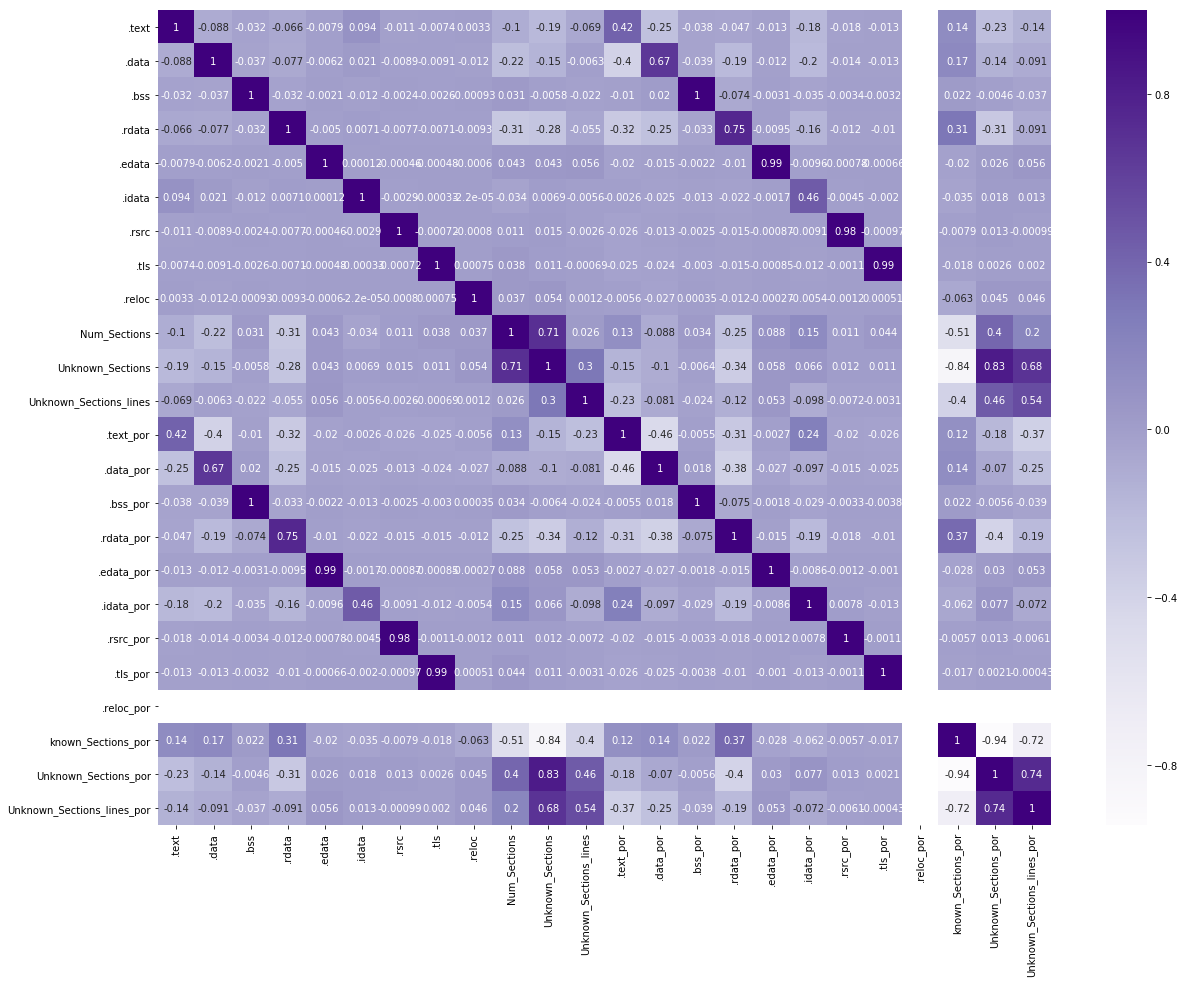

In [59]:
draw_heatmap(section_features, section_features.columns)

U ovoj kategoriji većina korealcijskih vrijednosti kreće se oko nule. Ipak, uočavamo par visoko koreliranih značajki kojima ćemo moći još, iako ne preznačajno, reducirati skup bitnih značajki ove skupine. Osim toga primjećujemo *reloc_por* značajku koja nam je potpuno irelevantna, a do sada je to nismo primijetili. Stoga i nju možemo odbaciti.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  75.06493506493507 %
Lollipop  -  80.53311793214863 %
Kelihos_ver3  -  79.87079224753485 %
Vundo  -  0.0 %
Simba  -  100.0 %
Tracur  -  76.26666666666667 %
Kelihos_ver1  -  79.59697732997482 %
Obfuscator.ACY  -  79.05460472697636 %
Gatak  -  77.5691699604743 %


/home/matea/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


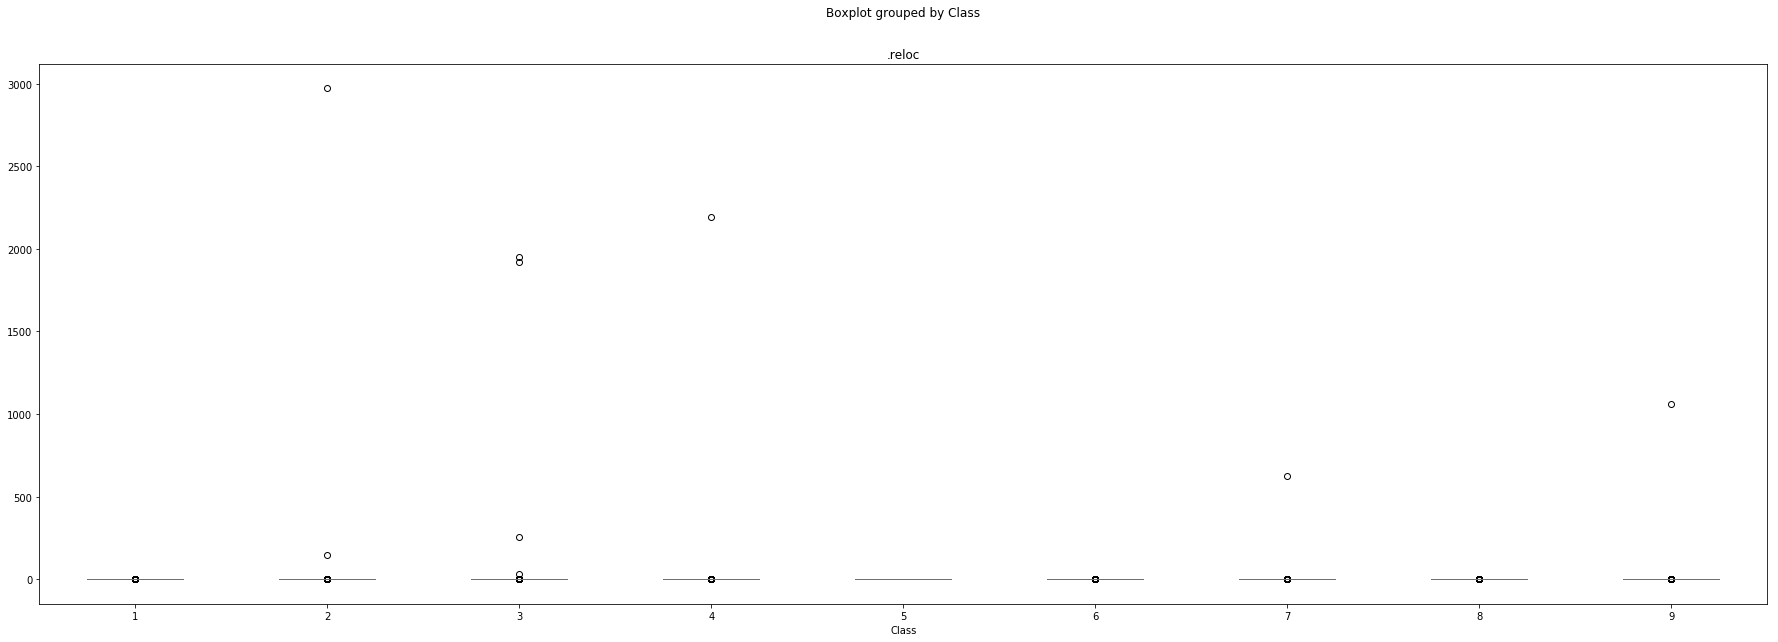

In [60]:
col = section_features.columns.get_loc('.reloc')

features.boxplot(column=[section_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( section_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>.reloc</code>, odnosno broj linija u .asm datoteci koje predstavljaju .reloc sekciju.
Vidimo ova značajka ima najmanji broj <i>outlier</i>-a od svih prethodno analiziranih značajki <i>boxplot</i>-ovima.

### _data define_
_DP_

In [63]:
# DATA DEFINE značajke
dd_features = features.iloc[:,782:806]
dd_features.head()

db_por    dd_por    dw_por    dc_por   db0_por  dbN0_por   dd_text  \
0  0.108934  0.083072  0.029781  0.221787  0.474820  0.525180  0.008065   
1  0.064309  0.048305  0.005262  0.117876  0.525150  0.474850  0.044414   
2  0.185570  0.057369  0.006857  0.249796  0.647119  0.352881  0.000540   
3  0.089382  0.017417  0.002178  0.108977  0.727589  0.272411  0.015506   
4  0.194687  0.015273  0.004814  0.214774  0.902320  0.097680  0.002584   

    db_text  dd_rdata  db3_rdata  ...    dd6   dd4_all   dd5_all   dd6_all  \
0  0.001344  0.287926   0.191950  ...    0.0  0.000000  0.002351  0.000000   
1  0.021744  0.000000   0.000000  ...    9.0  0.001068  0.000542  0.000139   
2  0.000540  0.250222   0.486263  ...    0.0  0.000252  0.000503  0.000000   
3  0.015775  0.000000   0.000000  ...  106.0  0.000337  0.000471  0.000458   
4  0.000470  0.270736   0.128326  ...    0.0  0.000238  0.000178  0.000000   

   db3_idata  db3_NdNt  dd4_NdNt  dd5_NdNt  dd6_NdNt  db3_all_zero  
0        0.0       0.0  0.000000  0.003822  0.000000      0.370787  
1        0.0       0.0  0.001561  0.000792  0.000204      0.396007  
2        0.0       0.0  0.000442  0.000884  0.000000      0.376826  
3        0.0       0.0  0.000619  0.000876  0.000852      0.435593  
4        0.0       0.0  0.000496  0.000372  0.000000      0.474631  

[5 rows x 24 columns]

In [62]:
dd_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

dd_rdata       -0.024129
dw_por         -0.012917
db3_all_zero   -0.010933
db0_por        -0.009924
db3_rdata      -0.009055
dd6            -0.007005
dd6_all        -0.003812
dd4_all        -0.001775
dd6_NdNt       -0.000537
dd4_NdNt       -0.000060
dd4             0.001594
db3_data        0.005775
dbN0_por        0.009179
db_por          0.010853
db3_all         0.011300
dd5             0.012640
db_text         0.012811
dd_por          0.016824
dd_text         0.018823
dd5_all         0.023018
dc_por          0.024433
dd5_NdNt        0.025442
dtype: float64

In [ ]:
draw_histograms_rows_quantile(data = dd_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [i for i in range(24)], 
                              sections = 100, 
                              no_rows = 12, no_cols = 2, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*24)

Iz gornjih histograma naslućujemo koreliranost među nekim značajkama. Također vidimo primjerice iz histograma db3_idata da se instrukcije db sa jednim ne $0$ parametrom u .idata sekciji uopće ne koriste.

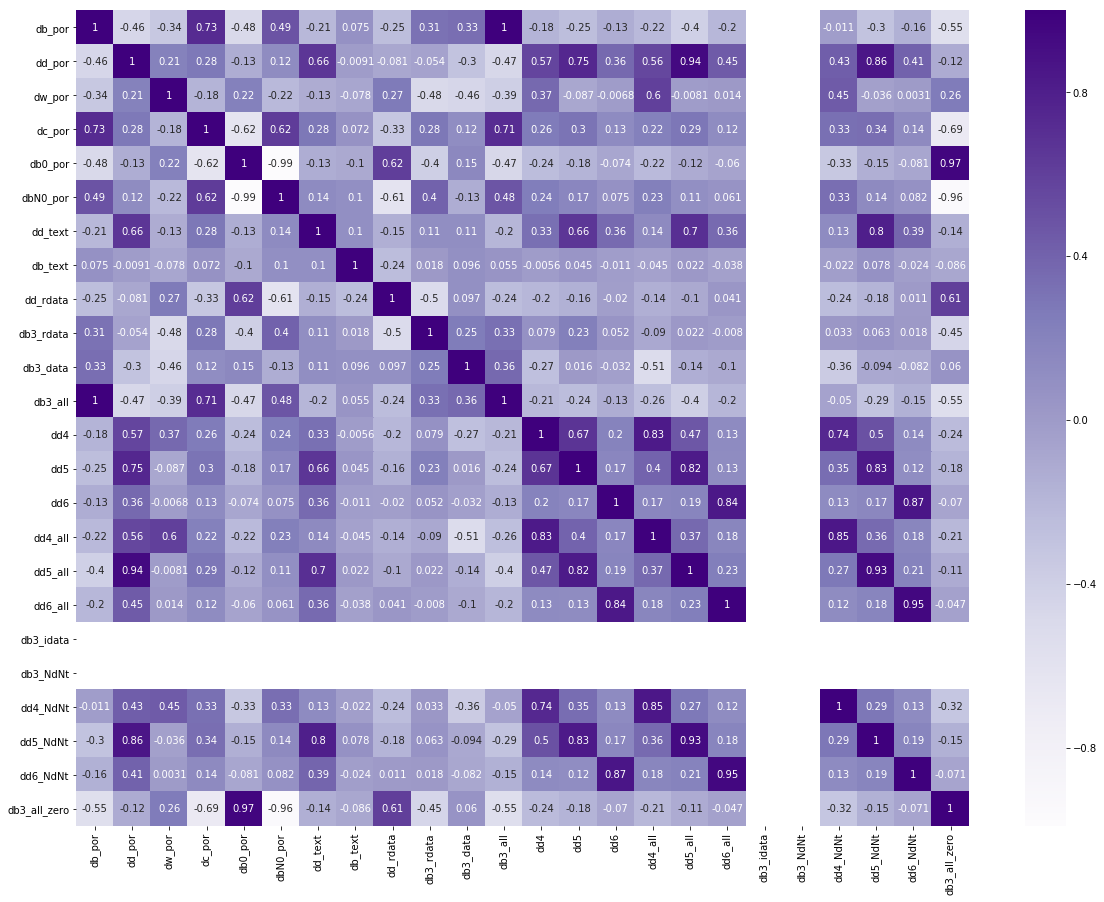

In [64]:
draw_heatmap(dd_features, dd_features.columns)

Na prvi pogled karta nam govori kako *db3_idata* i *db3_NdNt* značajke možemo izostaviti iz daljnje analize. Pogledom u *.asm* datoteku vidimo da su sve vrijednosti ovih značajki nula. Daljnjom analizom uočavamo da među značajkama ima onih koje su visoko korelirane, pa će nam to kao i kod ostalih kategorija pomoći pri smanjenju finalnog skupa značajki.

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  79.28571428571428 %
Lollipop  -  80.08885298869144 %
Kelihos_ver3  -  79.29275756545393 %
Vundo  -  0.0 %
Simba  -  80.48780487804879 %
Tracur  -  80.66666666666666 %
Kelihos_ver1  -  80.10075566750629 %
Obfuscator.ACY  -  86.22656886715566 %
Gatak  -  79.64426877470355 %


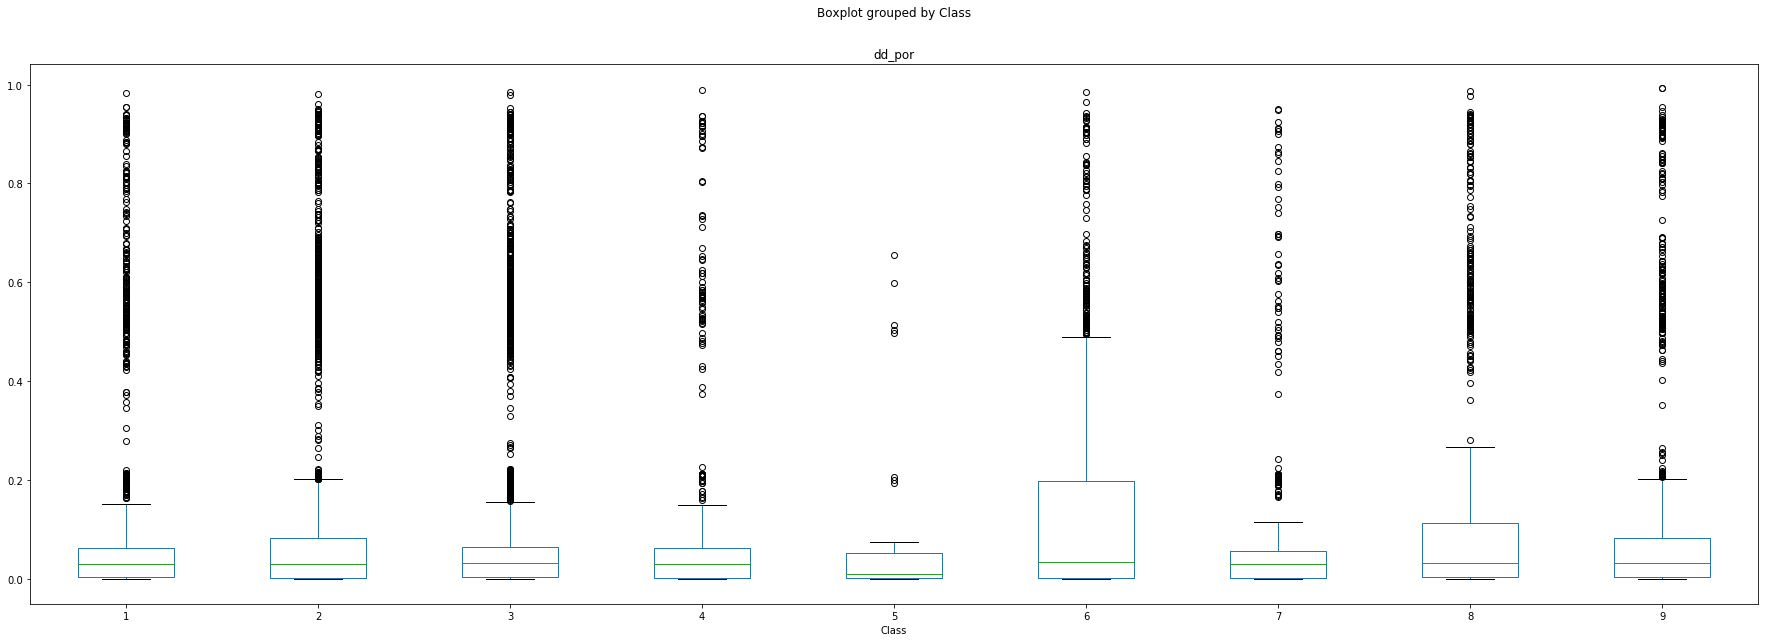

In [65]:
col = dd_features.columns.get_loc('dd_por')

features.boxplot(column=[dd_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( dd_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>dd_por</code>.

### API
_API_

In [66]:
# API značajke
api_features = features.iloc[:,806:1600]
api_features.head()

wcslen  __vbaUI1I2  send  MoveFileExA  VariantCopyInd  __vbaStrI2  \
0       0           0     0            0               0           0   
1     123           0     0            0               0           0   
2       0           0     0            0               0           0   
3       0           0     2            0               0           0   
4       0           0     0            0               0           0   

   DispatchMessageW  WaitForMultipleObjects  CoGetClassObject  IsEqualGUID  \
0                 6                       0                 0            0   
1                 0                       0                 0           11   
2                 0                       0                 0            0   
3                 0                       5                57            0   
4                 0                       0                 0            0   

   ...  GetEnhMetaFilePaletteEntries  IsBadCodePtr  OpenMutexA  __vbaStrI4  \
0  ...                             0             0           0           0   
1  ...                             0             0           0           0   
2  ...                             0             0           0           0   
3  ...                             0             0           0           0   
4  ...                             0             0           0           0   

   __vbaVarCopy  CopyEnhMetaFileA  LocalReAlloc  srand  __vbaAryCopy  \
0             0                 0             0      0             0   
1             0                 0             0      0             0   
2             0                 0             0      0             0   
3             0                 0             0      0             0   
4             0                 0             0      0             0   

   CreateDCA  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 794 columns]

794 *feature*-a koja sadrži, API skupinu značajki čine najvećom skupinom.

In [67]:
api_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

HeapCreate                  -0.510643
DispatchMessageA            -0.476598
FreeEnvironmentStringsA     -0.457051
FreeEnvironmentStringsW     -0.395712
TlsAlloc                    -0.377199
GetLastActivePopup          -0.370289
GetEnvironmentStringsW      -0.365164
SetHandleCount              -0.363845
GetStringTypeA              -0.359778
HeapAlloc                   -0.355752
GetFileType                 -0.354540
UnhandledExceptionFilter    -0.353437
GetEnvironmentStrings       -0.347003
IsValidCodePage             -0.345686
HeapSize                    -0.333179
InitializeCriticalSection   -0.331999
LCMapStringA                -0.320927
GetACP                      -0.315984
QueryPerformanceCounter     -0.314917
GetCurrentProcess           -0.310626
IsDebuggerPresent           -0.303849
RtlUnwind                   -0.302122
TlsGetValue                 -0.298812
GetCPInfo                   -0.295444
TerminateProcess            -0.294328
MultiByteToWideChar         -0.292631
exit        

Kao najveća skupina, sadrži i najveće oscilacije u koreliranosti značajki s ciljnom značajkom. Samim time primjećujemo kako su najjače korelirane značajke ujedno i najjače korelirane, ne samo unutar skupine, već i općenito. Zato ćemo, imajući uz to na umu i veličinu skupine, uzeti 80 najboljih značajki dobivenih univarijantnom metodom.  

- izbačeno  57  konstantnih značajki


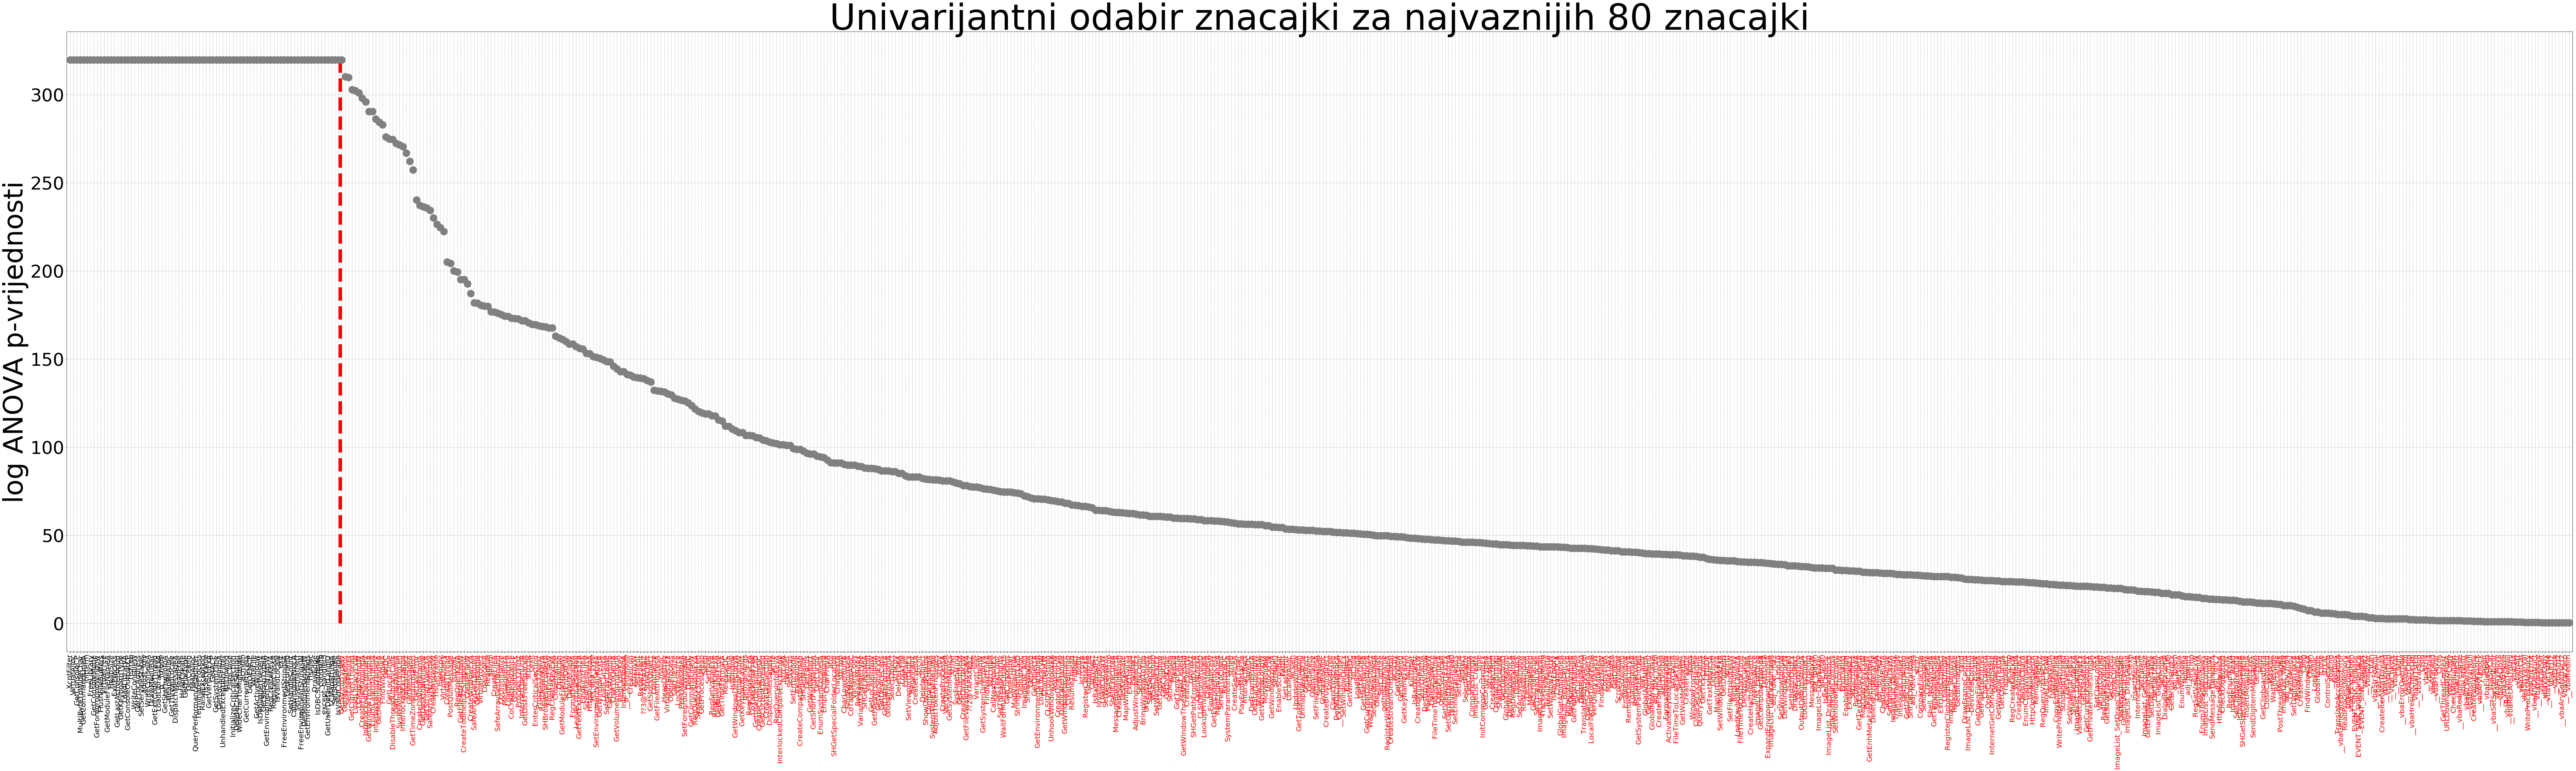

In [68]:
api_features_univariate = univariate_plot( features['Class'], api_features, 80)

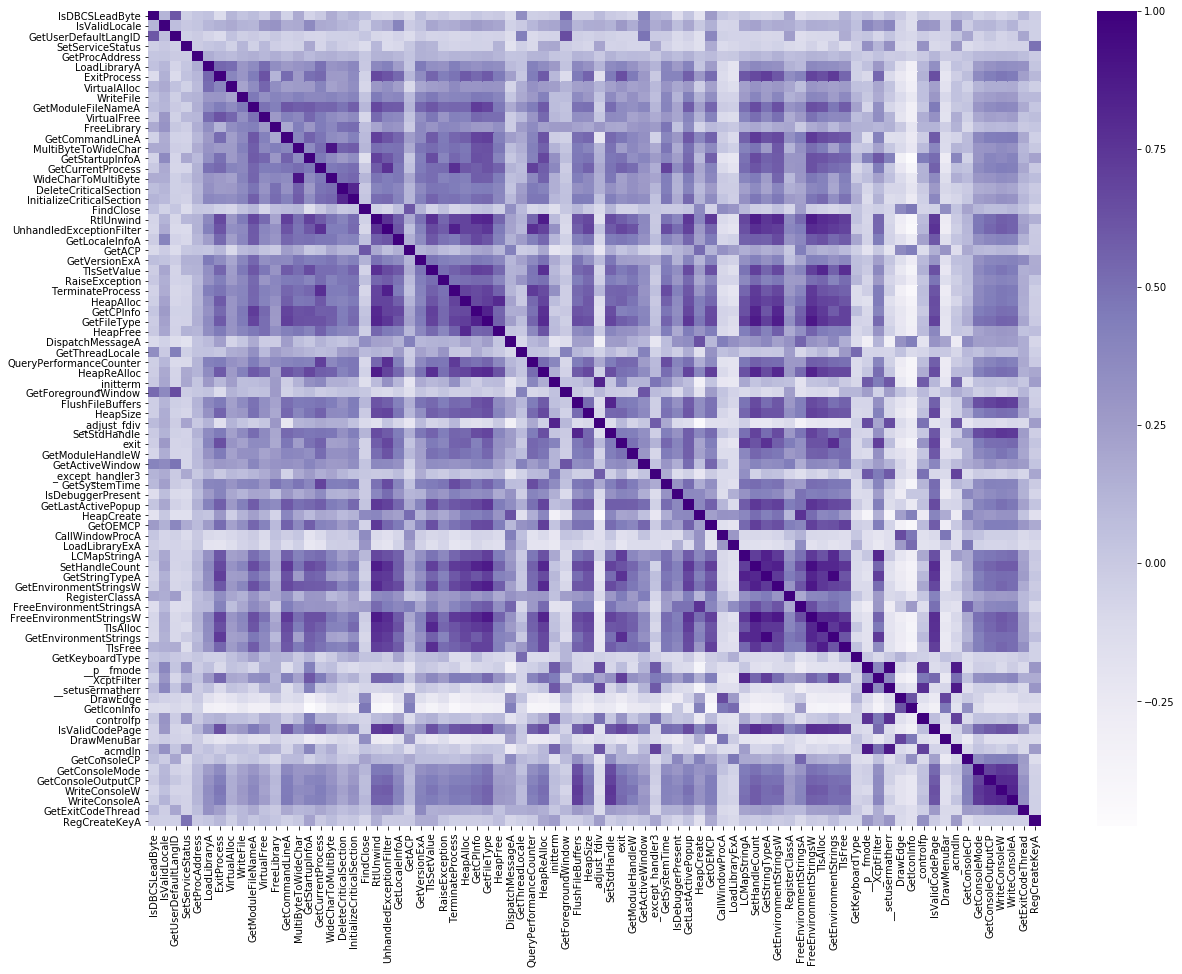

In [69]:
draw_heatmap_anNot(api_features, api_features_univariate)

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  90.97402597402598 %
Lollipop  -  98.46526655896606 %
Kelihos_ver3  -  99.9659979598776 %
Vundo  -  100.0 %
Simba  -  100.0 %
Tracur  -  99.86666666666667 %
Kelihos_ver1  -  99.49622166246851 %
Obfuscator.ACY  -  100.0 %
Gatak  -  79.1501976284585 %


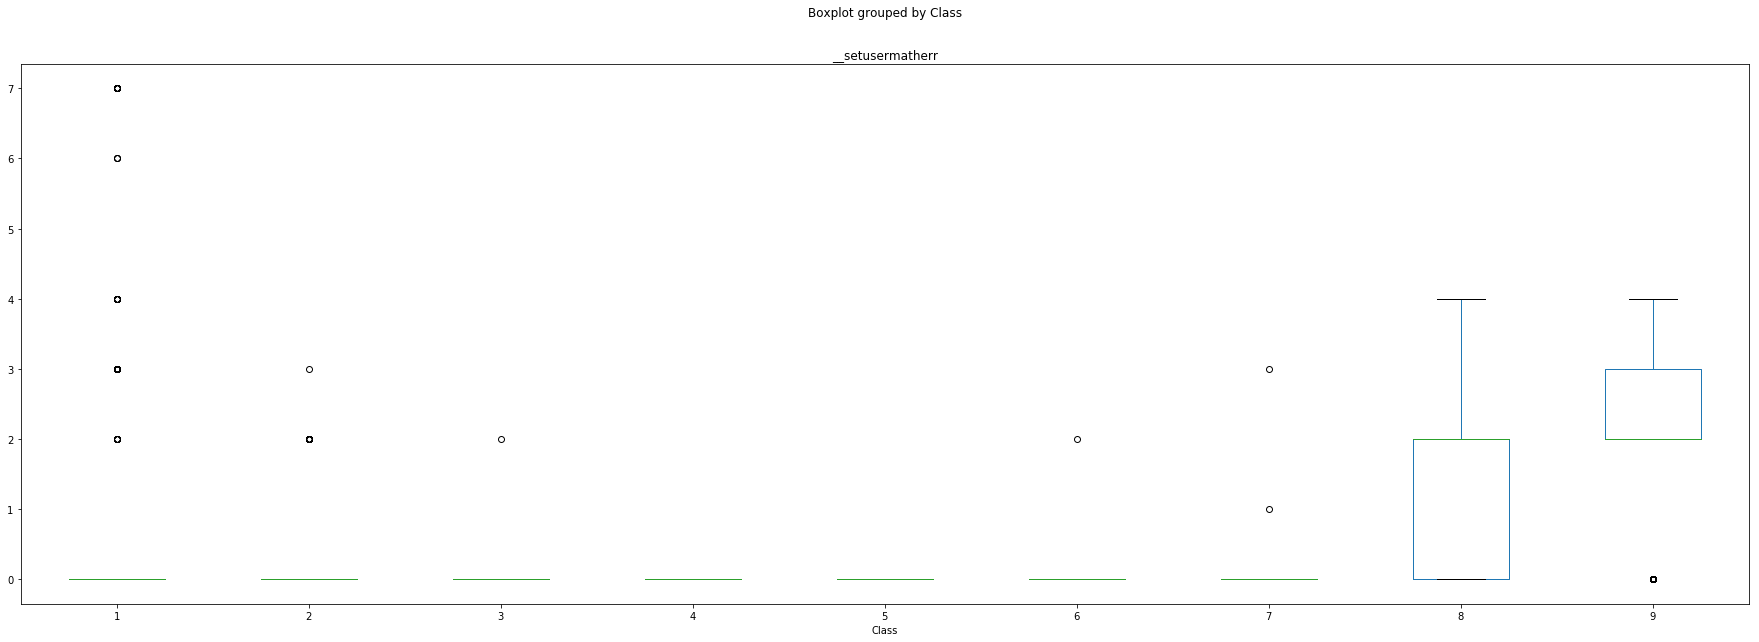

In [70]:
col = api_features.columns.get_loc('__setusermatherr')

features.boxplot(column=[api_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( api_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>__setusermatherr</code>. Iako se radi o velikom skupu pudataka, ovdje možemo vidjeti da su podaci ove značajke unutar gornjeg i donjeg brka ukupnog skupa podataka.

In [ ]:
df_api_features_univariate = api_features[api_features_univariate.tolist()]

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( df_api_features_univariate.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
api_accuracy_test_univariate = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(api_accuracy_test_univariate)

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( api_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
api_accuracy_test = model.score(malware_test,malware_classes_test) # Tocnost je default mjera za LogisticRegression()
print(api_accuracy_test)

Ovu skupinu, s iznimno visokom točnošću od gotovo 98%, uspjeli smo reducirati na veličinu od 80 značajki uz smanjenje točnosti od svega 2%. 

### ključne riječi
_KEYW_

In [71]:
# KEYWORDS značajke
key_features = features.iloc[:,1600:1695]
key_features.head()

Virtual  Offset    loc  Import  Imports    var  Forwarder  UINT  LONG  \
0        9       3    124      15        0     66          4     2     0   
1       36       2   8198      28        0   3806          7     2    10   
2        9      19   1198      19        0    455          5     2     2   
3       28       6  30848      44        0  12694          8    76    30   
4       32      15   2428      16        0    559          4     2     1   

   BOOL  ...  visualc  ___security_cookie  assume  callvirtualalloc  \
0     4  ...        0                   0       0                 0   
1    16  ...        0                   0       0                 0   
2     3  ...        0                   0       0                 0   
3   114  ...        0                   0       2                 0   
4    10  ...        0                   0       0                 0   

   exportedentry  hardware  hkey_current_user  hkey_local_machine  \
0              0         0                  0                   0   
1              0         0                  0                   0   
2              0         0                  0                   0   
3              0         0                  0                   0   
4              0         0                  0                   0   

   sp-analysisfailed  unableto  
0                  0         0  
1                  0         0  
2                  0         0  
3                  0         0  
4                  0         0  

[5 rows x 95 columns]

In [72]:
key_features.corrwith(features['Class']).dropna().sort_values() # korelacija značajki s klasama malwarea

Offset          -0.405891
BYTES           -0.310387
.text:          -0.244555
XREF            -0.233294
arg             -0.232161
loc             -0.214951
ptr             -0.210803
unk             -0.204118
align           -0.193524
WORD            -0.180030
HANDLE          -0.173173
WinMain         -0.172775
db              -0.161025
cookie          -0.160962
int             -0.157975
var             -0.147948
char            -0.146317
LPWSTR          -0.141985
large           -0.138835
void            -0.137449
DllEntryPoint   -0.135548
dll             -0.131978
word            -0.130122
stdcall         -0.120405
LPSTR           -0.107876
off             -0.107193
HMODULE         -0.095049
asc             -0.093523
short           -0.087911
__imp_          -0.084933
                   ...   
exe             -0.047547
ATOM            -0.047294
DLL             -0.046444
HLOCAL          -0.043794
DATA            -0.041716
HRESULT         -0.041616
config          -0.041599
UINT        

- izbačeno  32  konstantnih značajki


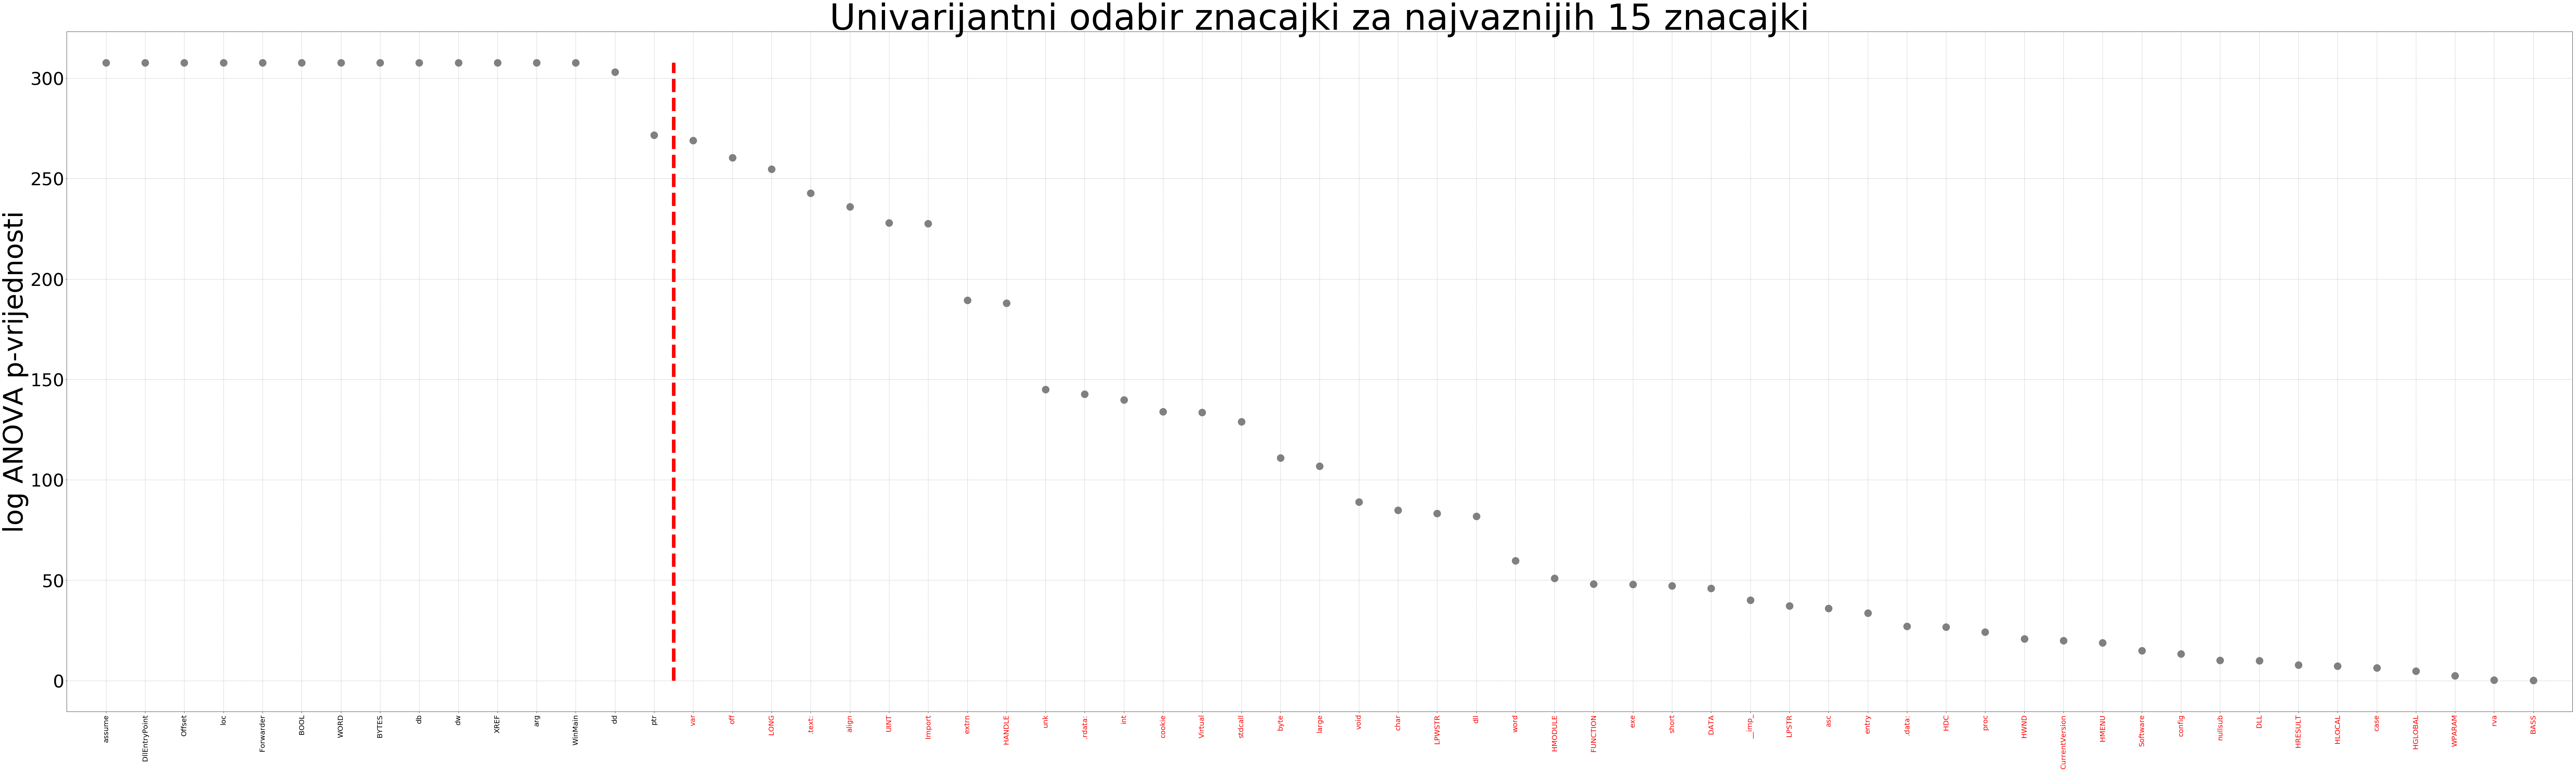

In [73]:
key_features_univariate = univariate_plot( features['Class'], key_features, 15)

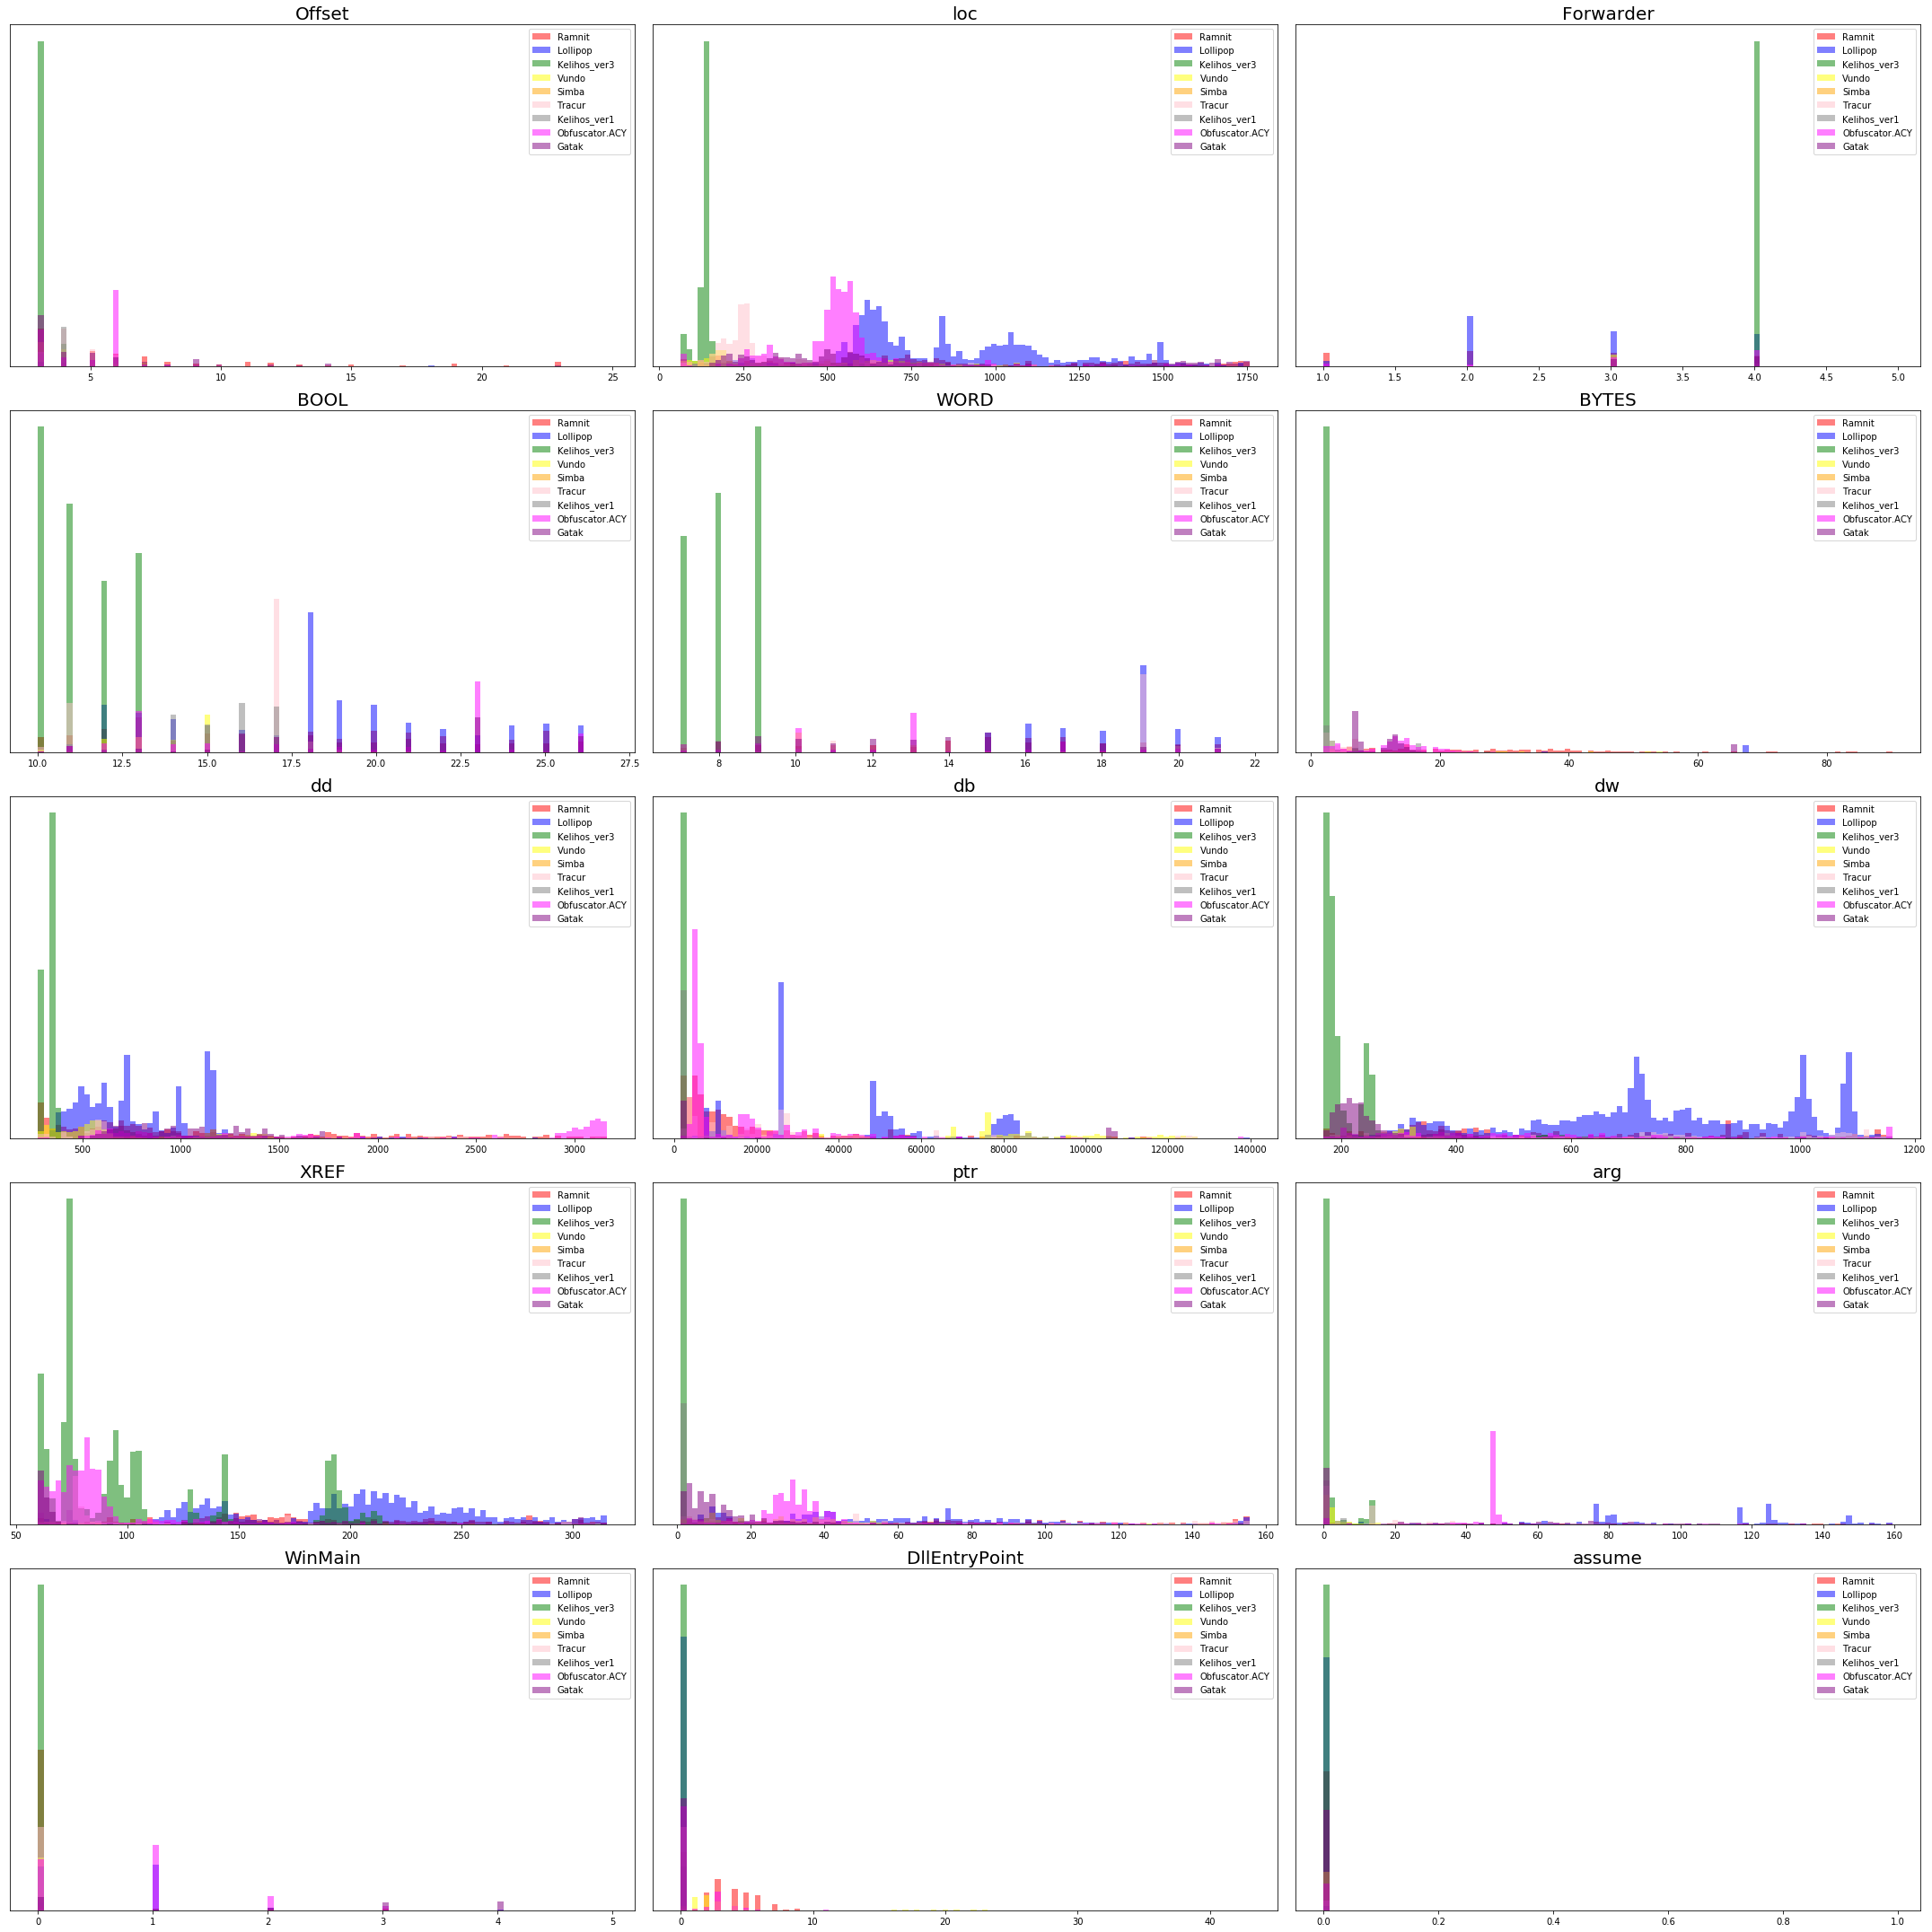

In [74]:
draw_histograms_rows_quantile(data = key_features, 
                              classes = classes_begining_and_end_in_features,
                              features = get_best_features_in_category_index_list(key_features, key_features_univariate), 
                              sections = 100, 
                              no_rows = 5, no_cols = 3, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*len(get_best_features_in_category_index_list(key_features, key_features_univariate)))

Iz priloženih histograma nije lako zaključiti o koreliranosti. Promotrimo primjerice histogram ključne riječi dw. Iz njega vidimo da skupina Kelihos_ver3 (zelena) koristi tu ključnu riječ u puno manjoj mjeri nego skupina Lollipop (plava), ali je broj korištenja u skupini Kelihos_ver3 uglavnom grupirana oko broja 200, dok su podaci za Lollipop jako rasprostranjeni.

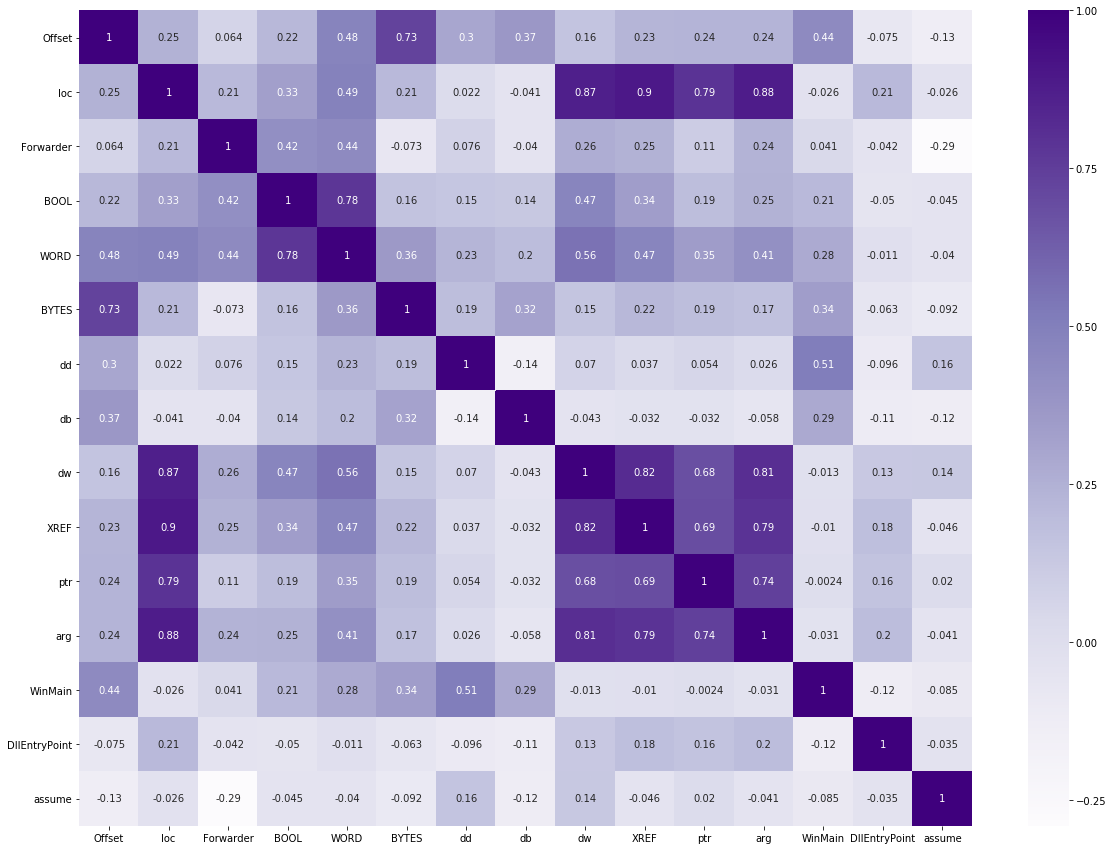

In [75]:
draw_heatmap(key_features, key_features_univariate)

Prosjek koliko se malware-a nalazi unutar 25 % najmanjih i 25 % najvećih elemenata skupa podataka:
Ramnit  -  82.98701298701299 %
Lollipop  -  99.1518578352181 %
Kelihos_ver3  -  92.99557973478409 %
Vundo  -  77.84810126582279 %
Simba  -  97.5609756097561 %
Tracur  -  92.66666666666666 %
Kelihos_ver1  -  83.87909319899244 %
Obfuscator.ACY  -  97.79951100244499 %
Gatak  -  91.89723320158103 %


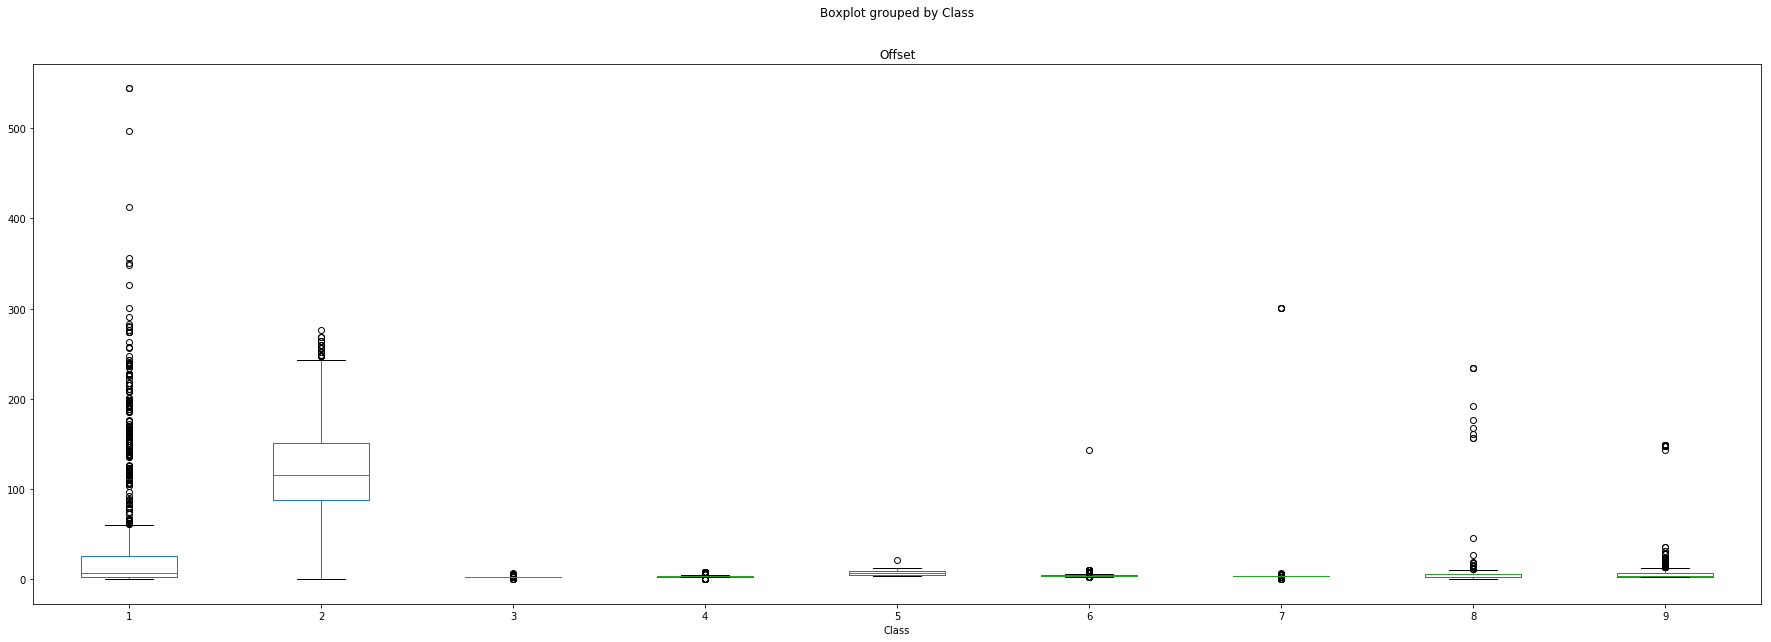

In [76]:
col = key_features.columns.get_loc('Offset')

features.boxplot(column=[key_features.columns.values[col]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

[in_range, outliers, prosjek] = in_good_range( key_features, col, classes_begining_and_end_in_features)

Na prethodnim <i>boxplot</i>-ovima za svaku klasu <i>malware</i>-a za značajku <code>Offset</code>, odnosno broj pojavljivanja riječi <i>Offset</i> u .asm datoteci. I kod ove značajke vidimo dosta <i>outlier</i>, posebice u familiji <i>malware</i>-a <i>Ramnit</i> gdje su 17% podataka izvan gornjeg brka ukupnog skupa podataka.

In [ ]:
key_features_univariate = key_features[key_features_univariate.tolist()]

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( key_features_univariate.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test)
print(accuracy_test)

In [ ]:
malware_train, malware_test, malware_classes_train, malware_classes_test = train_test_split( key_features.dropna(), features['Class'], test_size=0.3, random_state=47)
model = Pipeline([('logistic', LogisticRegression(max_iter=11000))]) 
model.fit(malware_train, malware_classes_train)
accuracy_test = model.score(malware_test,malware_classes_test)
print(accuracy_test)

<br>
<br>

# Usporedba

Usporedimo li rezultate dobivene logističkom regresijom na svakoj kategoriji značajki prije i nakon korištenja univarijantne metode odabira značajki, dobivamo rezultate kao u sljedećeoj tablici. Oni mogu mogu poslužiti za razumijevanje važnosti značajki.

Usporedili smo točnosti sljedećih kategorija značajki:
* 0 - unigram
* 1 - metapodaci iz .bytes datoteke
* 2 - entropija
* 3 - slikovna reprezentacija slike
* 4 - duljina stringa 
* 5 - metapodaci iz .asm datoteke
* 6 - simboli
* 7 - opcode
* 8 - registri
* 9 - API
* 10 -ključne riječi

In [ ]:
accuracy = [ one_gram_accuracy_test, 
           metadata_bytes_accuracy_test, 
           entropy_accuracy_test,
           image_accuracy_test, 
           string_length_accuracy_test, 
           metadata_asm_accuracy_test, 
           symbols_accuracy_test,
           opcode_accuracy_test,
           reg_accuracy_test,
           #section_accuracy_test
           api_accuracy_test,
           key_accuracy_test    
          ]

accuracy_univariate = [ one_gram_accuracy_test_univariate,
                        metadata_bytes_accuracy_test,
                        entropy_accuracy_test_univariate,
                        image_accuracy_test,
                        string_length_accuracy_test_univariate,
                        metadata_asm_accuracy_test,
                        symbols_accuracy_test,
                        opcode_accuracy_test_univariate,
                        reg_accuracy_test,
                        #section_accuracy_test
                        api_accuracy_test_univariate,
                        key_accuracy_test_univariate
                       ]

zippedlist = list(zip(sve, nase))
pd.DataFrame(zippedlist, columns = ['accuracy', 'accuracy_univariate']  ) 